In [1]:
import pandas as pd
import geopandas as gp
import os
import numpy as np
from math import sqrt
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
#Set options for pandas displays
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Arkansas 2018

## Election Results Documentation:

Election results from Arkansas Secretary of State (https://www.sos.arkansas.gov/elections/research/election-results)

For Benton county the Secretary of State results combine the Precinct 41 votes with the Precinct 4 votes. These were corrected according to precinct reports received from the county.

Johnson County switched to new vote centers for the November 2018 election. Due to a coding mismatch votes were then incorrectly assigned to precincts in the Secretary of State results, indicating some precincts had almost no votes and others had far too many. For the purpose of assigning votes as accurately as possible, the precincts are merged according to their assigned vote center with results by vote center received from the county. 

Votes that were reported countywide were then distributed based on the number of ballots cast by precinct according to the voter statistics report also received from the county.

Countywide votes were distributed for Fulton, Jefferson, Johnson, Union. These were distributed by candidate to precincts based on their share of the precinct-level reported vote.


## Shapefile Modifications Documentation:


Precinct shapefile primarily from Jennifer Wheeler at the Arkansas GIS Office who provided an unreleased interim version of the statewide precinct shapefile with updated or corrected boundaries. 

Where noted below, the 2016 shapefile release from the Arkansas GIS Office was used to reverse changes not yet enacted for the 2018 election.

Precinct mergers were made in the following counties to match county reporting units: Carroll, Chicot, Clark, Crittenden, Dallas, Faulkner, Hot Spring, Howard, Independence, Johnson, Mississippi, Monroe, Nevada, Phillips, Poinsett, St. Francis, Stone.

Additional modifications to reflect how election results were reported:<br>
Benton: Align Siloam Springs and Gravette precincts with 2018 municipal boundaries<br>
Boone: Precinct splits based on municipal boundaries and legislative boundaries consistent with county map<br>
Greene: Merged Wards 3/3A and 4/4C as the splits were not reported separately for the 2018 general election<br>
Izard: Sage in Melbourne 4 and Oxford in Brockwell split by township shapefile<br>
Jefferson: Precincts 6, 35, 38, 39, 42, 43, 44, 46, 52, 63, 129, 402, 411 from 2016 shapefile<br>
Madison: County precincts outside Huntsville from 2016 shapefile<br>
Phillips: Helena-West Helena wards added from city redistricting map; Precinct 4 was no longer in use for the 2018 general election, the single vote reported for Precinct 4 was actually from Precinct 6<br>
St. Francis: Forrest City wards revised to match city PDF and legal description in municipal code<br>
Stone: Ben 1 & Ben 2 split according to Secretary of State map<br>

## Candidate List

G18GOVRHUT - Asa Hutchinson (Republican Party)<br>
G18GOVDHEN - Jared K. Henderson (Democratic Party)<br>
G18GOVLWES - Mark West (Libertarian Party)<br>

G18LTGRGRI - Tim Griffin (Republican Party)<br>
G18LTGDBLA - Anthony Bland (Democratic Party)<br>
G18LTGLGIL - Frank Gilbert (Libertarian Party)<br>

G18ATGRRUT - Leslie Rutledge (Republican Party)<br>
G18ATGDLEE - Mike Lee (Democratic Party)<br>
G18ATGLHIC - Kerry Hicks (Libertarian Party)<br>

G18SOSRTHU - John Thurston (Republican Party)<br>
G18SOSDINM - Susan Inman (Democratic Party)<br>
G18SOSLOLS - Christopher Olson (Libertarian Party)<br>

G18TRERMIL - Dennis Milligan (Republican Party)<br>
G18TRELEWA - Ashley Ewald (Libertarian Party)<br>

G18AUDRLEA - Andrea Lea (Republican Party)<br>
G18AUDLDIN - David E. Dinwiddie (Democratic Party)<br>

G18LNDRLAN - Tommy Land (Republican Party)<br>
G18LNDDWIL - Larry Williams (Democratic Party)<br>
G18LNDLCAM - T.J. Campbell (Libertarian Party)<br>

### Load Election Data

Because the Arkansas Secretary of State data the precinct level is only available by county (instead of statewide), we used election data from Open Elections (https://github.com/openelections/openelections-data-ar/tree/master/2018). 

In [2]:
elec = pd.read_csv('./raw-sources/20181106__ar__general__precinct.csv')

#### Take a look at the dataframe

In [3]:
elec.head(1)

,county,precinct,office,district,candidate,party,votes
0,Lafayette,Lewisville Ward 1,U.S. House,4,Hayden Catherine Shamel,Dem,44


### Load in Benton County Election Data for Precincts 4 and 41

This data was retrieved through an email exchange with Dana Caler (Dana.Caler@bentoncountyar.gov) at the Benton County Clerk's Office. Precincts 4 and 41 (the precincts of interest), were subset and saved as CSV, outside this script.

In [4]:
benton_4_41 = pd.read_csv('./raw-sources/benton_4_41.csv')

#### Take a look at the dataframe

In [5]:
display(benton_4_41)

,co_prec,G18GOVRHUT,G18GOVDHEN,G18GOVLWES,G18LTGRGRI,G18LTGDBLA,G18LTGLGIL,G18ATGRRUT,G18ATGDLEE,G18ATGLHIC,G18SOSRTHU,G18SOSDINM,G18SOSLOLS,G18TRERMIL,G18TRELEWA,G18AUDRLEA,G18AUDLDIN,G18LNDRLAN,G18LNDDWIL,G18LNDLCAM,county,prec
0,Benton_Precinct 4,531,152,22,528,164,13,516,157,32,509,174,19,545,151,546,149,517,165,21,Benton,Precinct 4
1,Benton_Precinct 41,635,222,23,613,238,25,602,249,29,592,252,29,649,214,659,199,599,245,29,Benton,Precinct 41


### Load in Johnson County Vote Centers

A .docx file was received from the Johnson County Clerk (johnsonclerk@arkansasclerks.com) and was translated to a CSV outside of this script.

In [6]:
vote_centers = pd.read_csv('raw-sources/johnson_vote_centers_18.csv')

#### Take a look at the dataframe

In [7]:
vote_centers.head(1)

,prec,vote_center,ballots_cast
0,Batson,Oark,379


### Clean Election Data - Candidate Names

In [8]:
cands = ['Asa Hutchinson','Jared K. Henderson','Mark West','Tim Griffin','Anthony Bland',
         'Frank Gilbert','Leslie Rutledge','Mike Lee','Kerry Hicks','John Thurston',
         'Susan Inman','Christopher Olson','Dennis Milligan','Ashley Ewald','Andrea Lea',
         'David E. Dinwiddie','Tommy Land','Larry Williams','T.J. Campbell',
         
        'ANOTHONY BLAND', 'David Dinwiddie','T. J. Campbell','David E. Dinwiddle']
cands_df = []
cands_inboth = []
for i in elec['candidate'].unique():
    for j in cands:
        if str(j) in str(i):
            cands_df.append(i)
            cands_inboth.append(j)

cands_remaining = list(set(set(cands_inboth) ^ set(cands)))
if len(cands_remaining)==0:
    print('All candidates have been identified in the dataset.')
else:
    print('Following candidates are unidentified in the dataset: ', str(', '.join(cands_remaining)))


All candidates have been identified in the dataset.


### Clean Election Data - Subset by Candidates 

In [9]:
ar = elec[elec['candidate'].isin(cands_df)].copy()
print('Subset by Candidate Names')
display(ar.head(1))
ar['county'] = ar['county'].apply(lambda x: x.capitalize())
ar['precinct'] = ar['precinct'].apply(lambda x: x.capitalize())
ar[('co_prec','co_prec')] = ar.apply(lambda x: '_'.join([x['county'],x['precinct']]),axis=1)
ar.drop(columns = ['party','office','district'],inplace  = True)
print('Subset by Candidate Names, Created a Unique ID, and Removed Extraneous Columns')
display(ar.head(1))

Subset by Candidate Names


,county,precinct,office,district,candidate,party,votes
100,Lafayette,Lewisville Ward 1,Governor,NaN,Mark West,Lib,4


Subset by Candidate Names, Created a Unique ID, and Removed Extraneous Columns


,county,precinct,candidate,votes,"(co_prec, co_prec)"
100,Lafayette,Lewisville ward 1,Mark West,4,Lafayette_Lewisville ward 1


### Clean Election Data - Pivot

In [10]:
piv = ar.pivot_table(index = [('co_prec','co_prec')], columns = ['candidate'])
piv.reset_index(inplace=True)
print('Pivoted election data')
display(piv.head(1))
piv.columns = piv.columns.droplevel(0)
piv = piv.fillna(0) #Fill with 0s for null values
print('Pivoted election data with nulls as 0 and column names cleaned')
display(piv.head(1))

Pivoted election data


co_prec          votes                           \
candidate          co_prec ANOTHONY BLAND Andrea Lea Anthony Bland   
0          Arkansas_Almyra            NaN        NaN           7.0   

                                                                        \
candidate Asa Hutchinson Ashley Ewald Attorney General Leslie Rutledge   
0                    NaN          3.0                             71.0   

                                                \
candidate Auditor Andrea Lea Christopher Olson   
0                       76.0               1.0   

                                                                     \
candidate Commissioner of State Lands John Thurston David Dinwiddie   
0                                               NaN             NaN   

                                                               \
candidate David E. Dinwiddie David E. Dinwiddle Frank Gilbert   
0                        5.0                NaN           0.0   

                                                      \
candidate Governor Asa Hutchinson Jared K. Henderson   
0                            68.0               15.0   

                                            \
candidate John Thurston Com of State Lands   
0                                      NaN   

                                                                 \
candidate John Thurston Commissioner of State Lands Kerry Hicks   
0                                              71.0         2.0   

                                                                             \
candidate Larry Williams Leslie Rutledge Lt. Governor Tim Griffin Mark West   
0                    8.0             NaN                     75.0       0.0   

                                                                        \
candidate Mike Lee Susan Inman T. J. Campbell T.J. Campbell Tommy Land   
0              9.0        10.0            NaN           2.0       72.0   

                                              
candidate Treasurer of State Dennis Milligan  
0                                       79.0

Pivoted election data with nulls as 0 and column names cleaned


candidate,co_prec,ANOTHONY BLAND,Andrea Lea,Anthony Bland,Asa Hutchinson,Ashley Ewald,Attorney General Leslie Rutledge,Auditor Andrea Lea,Christopher Olson,Commissioner of State Lands John Thurston,David Dinwiddie,David E. Dinwiddie,David E. Dinwiddle,Frank Gilbert,Governor Asa Hutchinson,Jared K. Henderson,John Thurston Com of State Lands,John Thurston Commissioner of State Lands,Kerry Hicks,Larry Williams,Leslie Rutledge,Lt. Governor Tim Griffin,Mark West,Mike Lee,Susan Inman,T. J. Campbell,T.J. Campbell,Tommy Land,Treasurer of State Dennis Milligan
0,Arkansas_Almyra,0.0,0.0,7.0,0.0,3.0,71.0,76.0,1.0,0.0,0.0,5.0,0.0,0.0,68.0,15.0,0.0,71.0,2.0,8.0,0.0,75.0,0.0,9.0,10.0,0.0,2.0,72.0,79.0


### Create unique candidate fields from different candidate names (as reported by counties)

In [11]:
piv['G18AUDRLEA'] = piv.apply(lambda x: x['Andrea Lea'] + x['Auditor Andrea Lea'],axis=1)
piv['G18GOVRHUT'] = piv.apply(lambda x: x['Asa Hutchinson'] + x['Governor Asa Hutchinson'],axis=1)
piv['G18ATGRRUT'] = piv.apply(lambda x: x['Attorney General Leslie Rutledge'] + x['Leslie Rutledge'],axis=1)
piv['G18SOSRTHU'] = piv.apply(lambda x: x['John Thurston Commissioner of State Lands']+x['John Thurston Com of State Lands']+x['Commissioner of State Lands John Thurston'],axis=1)
piv['G18LTGDBLA'] = piv.apply(lambda x: x['ANOTHONY BLAND'] + x['Anthony Bland'],axis=1)
piv['G18AUDLDIN'] = piv.apply(lambda x: x['David E. Dinwiddie'] + x['David Dinwiddie'] + x['David E. Dinwiddle'],axis=1)
piv['G18LNDLCAM'] = piv.apply(lambda x: x['T.J. Campbell'] + x['T. J. Campbell'],axis=1)


### Change Names to match VEST for remaining candidates

In [12]:

rename_dict = {
              'Ashley Ewald':'G18TRELEWA',
              'Christopher Olson':'G18SOSLOLS',
              'Frank Gilbert':'G18LTGLGIL',
              'Jared K. Henderson':'G18GOVDHEN',
              'Kerry Hicks':'G18ATGLHIC',
              'Larry Williams':'G18LNDDWIL',
              'Lt. Governor Tim Griffin':'G18LTGRGRI',
              'Mark West':'G18GOVLWES',
              'Mike Lee':'G18ATGDLEE',
              'Susan Inman':'G18SOSDINM',
              'Tommy Land':'G18LNDRLAN',
              'Treasurer of State Dennis Milligan':'G18TRERMIL'}


piv = piv.rename(columns = rename_dict)
display(piv.head(1))

candidate,co_prec,ANOTHONY BLAND,Andrea Lea,Anthony Bland,Asa Hutchinson,G18TRELEWA,Attorney General Leslie Rutledge,Auditor Andrea Lea,G18SOSLOLS,Commissioner of State Lands John Thurston,David Dinwiddie,David E. Dinwiddie,David E. Dinwiddle,G18LTGLGIL,Governor Asa Hutchinson,G18GOVDHEN,John Thurston Com of State Lands,John Thurston Commissioner of State Lands,G18ATGLHIC,G18LNDDWIL,Leslie Rutledge,G18LTGRGRI,G18GOVLWES,G18ATGDLEE,G18SOSDINM,T. J. Campbell,T.J. Campbell,G18LNDRLAN,G18TRERMIL,G18AUDRLEA,G18GOVRHUT,G18ATGRRUT,G18SOSRTHU,G18LTGDBLA,G18AUDLDIN,G18LNDLCAM
0,Arkansas_Almyra,0.0,0.0,7.0,0.0,3.0,71.0,76.0,1.0,0.0,0.0,5.0,0.0,0.0,68.0,15.0,0.0,71.0,2.0,8.0,0.0,75.0,0.0,9.0,10.0,0.0,2.0,72.0,79.0,76.0,68.0,71.0,71.0,7.0,5.0,2.0


### Remove extraneous columns

In [13]:
col_keep = ['co_prec']
for i in list(piv.columns):
    if '18' in i:
        col_keep.append(i)

piv = piv[col_keep]

display(piv.head(1))

candidate,co_prec,G18TRELEWA,G18SOSLOLS,G18LTGLGIL,G18GOVDHEN,G18ATGLHIC,G18LNDDWIL,G18LTGRGRI,G18GOVLWES,G18ATGDLEE,G18SOSDINM,G18LNDRLAN,G18TRERMIL,G18AUDRLEA,G18GOVRHUT,G18ATGRRUT,G18SOSRTHU,G18LTGDBLA,G18AUDLDIN,G18LNDLCAM
0,Arkansas_Almyra,3.0,1.0,0.0,15.0,2.0,8.0,75.0,0.0,9.0,10.0,72.0,79.0,76.0,68.0,71.0,71.0,7.0,5.0,2.0


### Order candidates to match VEST

In [14]:
piv = piv[['co_prec','G18GOVRHUT', 'G18GOVDHEN', 'G18GOVLWES', 'G18LTGRGRI',
       'G18LTGDBLA', 'G18LTGLGIL', 'G18ATGRRUT', 'G18ATGDLEE', 'G18ATGLHIC',
       'G18SOSRTHU', 'G18SOSDINM', 'G18SOSLOLS', 'G18TRERMIL', 'G18TRELEWA',
       'G18AUDRLEA', 'G18AUDLDIN', 'G18LNDRLAN', 'G18LNDDWIL', 'G18LNDLCAM']]
piv['county'] = piv['co_prec'].apply(lambda x: x.split('_')[0])
piv['prec'] = piv['co_prec'].apply(lambda x: x.split('_')[1])
display(piv.head(1))

candidate,co_prec,G18GOVRHUT,G18GOVDHEN,G18GOVLWES,G18LTGRGRI,G18LTGDBLA,G18LTGLGIL,G18ATGRRUT,G18ATGDLEE,G18ATGLHIC,G18SOSRTHU,G18SOSDINM,G18SOSLOLS,G18TRERMIL,G18TRELEWA,G18AUDRLEA,G18AUDLDIN,G18LNDRLAN,G18LNDDWIL,G18LNDLCAM,county,prec
0,Arkansas_Almyra,68.0,15.0,0.0,75.0,7.0,0.0,71.0,9.0,2.0,71.0,10.0,1.0,79.0,3.0,76.0,5.0,72.0,8.0,2.0,Arkansas,Almyra


### Make election data modifications for Benton County Precincts 4 and 41

In [15]:
piv = piv[piv['co_prec']!='Benton_Precinct 4'].copy() #Remove original Precinct 4
piv = pd.concat([piv,benton_4_41]) #Append Precincts 4 and 41
piv.tail(3)

,co_prec,G18GOVRHUT,G18GOVDHEN,G18GOVLWES,G18LTGRGRI,G18LTGDBLA,G18LTGLGIL,G18ATGRRUT,G18ATGDLEE,G18ATGLHIC,G18SOSRTHU,G18SOSDINM,G18SOSLOLS,G18TRERMIL,G18TRELEWA,G18AUDRLEA,G18AUDLDIN,G18LNDRLAN,G18LNDDWIL,G18LNDLCAM,county,prec
2635,Yell_Waveland,76.0,18.0,4.0,79.0,17.0,1.0,73.0,19.0,6.0,74.0,19.0,3.0,77.0,18.0,76.0,20.0,74.0,20.0,3.0,Yell,Waveland
0,Benton_Precinct 4,531.0,152.0,22.0,528.0,164.0,13.0,516.0,157.0,32.0,509.0,174.0,19.0,545.0,151.0,546.0,149.0,517.0,165.0,21.0,Benton,Precinct 4
1,Benton_Precinct 41,635.0,222.0,23.0,613.0,238.0,25.0,602.0,249.0,29.0,592.0,252.0,29.0,649.0,214.0,659.0,199.0,599.0,245.0,29.0,Benton,Precinct 41


### Make election data modifications for Johnson County

In [16]:
johnson = piv[piv['county']=='Johnson'].copy()
display(johnson)
print(len(johnson))
display(vote_centers.head(1))
display(johnson.head(1))
johnson = pd.merge(johnson, vote_centers, on = 'prec', how = 'outer',indicator = True)
unmerged = johnson[johnson['_merge']!='both'].copy()
if len(unmerged) == 0:
    print('All Precincts/Vote Centers were assigned.')
else:
    print('Precincts/Vote Centers that are unassigned.')
    display(unmerged)

,co_prec,G18GOVRHUT,G18GOVDHEN,G18GOVLWES,G18LTGRGRI,G18LTGDBLA,G18LTGLGIL,G18ATGRRUT,G18ATGDLEE,G18ATGLHIC,G18SOSRTHU,G18SOSDINM,G18SOSLOLS,G18TRERMIL,G18TRELEWA,G18AUDRLEA,G18AUDLDIN,G18LNDRLAN,G18LNDDWIL,G18LNDLCAM,county,prec
1268,Johnson_Batson,306.0,82.0,12.0,307.0,70.0,14.0,299.0,82.0,10.0,285.0,100.0,11.0,310.0,85.0,311.0,81.0,273.0,93.0,20.0,Johnson,Batson
1269,Johnson_Dickerson-hill,3.0,1.0,0.0,2.0,2.0,0.0,2.0,2.0,0.0,2.0,2.0,0.0,3.0,1.0,2.0,2.0,2.0,1.0,1.0,Johnson,Dickerson-hill
1270,Johnson_Grant,405.0,109.0,16.0,374.0,135.0,15.0,359.0,153.0,13.0,349.0,154.0,22.0,420.0,101.0,425.0,95.0,327.0,180.0,15.0,Johnson,Grant
1271,Johnson_Hickey,606.0,134.0,27.0,595.0,147.0,21.0,585.0,160.0,18.0,579.0,167.0,19.0,623.0,133.0,629.0,134.0,546.0,193.0,25.0,Johnson,Hickey
1272,Johnson_Horsehead,876.0,254.0,40.0,851.0,267.0,47.0,854.0,283.0,31.0,839.0,288.0,36.0,932.0,227.0,940.0,216.0,793.0,326.0,45.0,Johnson,Horsehead
1273,Johnson_Howell,145.0,33.0,13.0,142.0,37.0,11.0,140.0,44.0,8.0,143.0,39.0,10.0,158.0,33.0,158.0,34.0,131.0,48.0,10.0,Johnson,Howell
1274,Johnson_King,370.0,111.0,26.0,358.0,125.0,23.0,357.0,126.0,26.0,348.0,141.0,15.0,401.0,101.0,409.0,93.0,333.0,152.0,21.0,Johnson,King
1275,Johnson_Lee,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Johnson,Lee
1276,Johnson_Lowgap,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,Johnson,Lowgap
1277,Johnson_Mckennon,10.0,3.0,0.0,10.0,3.0,0.0,10.0,3.0,0.0,10.0,3.0,0.0,11.0,2.0,11.0,2.0,10.0,3.0,0.0,Johnson,Mckennon


22


,prec,vote_center,ballots_cast
0,Batson,Oark,379


,co_prec,G18GOVRHUT,G18GOVDHEN,G18GOVLWES,G18LTGRGRI,G18LTGDBLA,G18LTGLGIL,G18ATGRRUT,G18ATGDLEE,G18ATGLHIC,G18SOSRTHU,G18SOSDINM,G18SOSLOLS,G18TRERMIL,G18TRELEWA,G18AUDRLEA,G18AUDLDIN,G18LNDRLAN,G18LNDDWIL,G18LNDLCAM,county,prec
1268,Johnson_Batson,306.0,82.0,12.0,307.0,70.0,14.0,299.0,82.0,10.0,285.0,100.0,11.0,310.0,85.0,311.0,81.0,273.0,93.0,20.0,Johnson,Batson


All Precincts/Vote Centers were assigned.


In [17]:
display(vote_centers)

,prec,vote_center,ballots_cast
0,Batson,Oark,379
1,Dickerson-hill,Oark,4
2,Grant,Westside,532
3,Hickey,Hagarville,770
4,Horsehead,Harmony,1173
5,Howell,Knoxville,191
6,King,Woodland,509
7,Lee,Centerpoint,0
8,Lowgap,Ozone,1
9,Mckennon,Knoxville,12


In [18]:
johnson_grouped = johnson.groupby(by=['vote_center']).sum()
johnson_grouped.reset_index(inplace=True)
johnson_grouped['co_prec'] = johnson_grouped['vote_center'].apply(lambda x: '_'.join(['Johnson',x]))
johnson_grouped['county'] = 'Johnson'
johnson_grouped['prec'] = johnson_grouped['vote_center']
johnson_grouped.drop(columns = ['vote_center'],inplace=True)
display(johnson_grouped)

,G18GOVRHUT,G18GOVDHEN,G18GOVLWES,G18LTGRGRI,G18LTGDBLA,G18LTGLGIL,G18ATGRRUT,G18ATGDLEE,G18ATGLHIC,G18SOSRTHU,G18SOSDINM,G18SOSLOLS,G18TRERMIL,G18TRELEWA,G18AUDRLEA,G18AUDLDIN,G18LNDRLAN,G18LNDDWIL,G18LNDLCAM,ballots_cast,co_prec,county,prec
0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,0.0,2,Johnson_Centerpoint,Johnson,Centerpoint
1,844.0,177.0,32.0,826.0,195.0,26.0,806.0,219.0,24.0,794.0,225.0,32.0,864.0,177.0,872.0,176.0,756.0,257.0,36.0,1057,Johnson_Hagarville,Johnson,Hagarville
2,876.0,254.0,40.0,851.0,267.0,47.0,854.0,283.0,31.0,839.0,288.0,36.0,932.0,227.0,940.0,216.0,793.0,326.0,45.0,1173,Johnson_Harmony,Johnson,Harmony
3,155.0,36.0,13.0,152.0,40.0,11.0,150.0,47.0,8.0,153.0,42.0,10.0,169.0,35.0,169.0,36.0,141.0,51.0,10.0,203,Johnson_Knoxville,Johnson,Knoxville
4,438.0,110.0,24.0,422.0,123.0,27.0,418.0,138.0,17.0,403.0,150.0,19.0,447.0,123.0,459.0,107.0,370.0,169.0,33.0,575,Johnson_Lamar,Johnson,Lamar
5,1732.0,690.0,74.0,1640.0,772.0,78.0,1555.0,852.0,79.0,1519.0,880.0,77.0,1840.0,615.0,1903.0,551.0,1409.0,968.0,89.0,2487,Johnson_Marvin Vinson,Johnson,Marvin Vinson
6,297.0,57.0,13.0,296.0,60.0,12.0,286.0,74.0,7.0,274.0,80.0,13.0,303.0,63.0,306.0,58.0,267.0,87.0,13.0,369,Johnson_Mt. Vernon,Johnson,Mt. Vernon
7,310.0,83.0,12.0,309.0,73.0,14.0,301.0,85.0,10.0,287.0,103.0,11.0,314.0,86.0,314.0,83.0,276.0,94.0,21.0,383,Johnson_Oark,Johnson,Oark
8,3.0,2.0,0.0,2.0,3.0,0.0,2.0,3.0,0.0,2.0,3.0,0.0,4.0,1.0,3.0,2.0,1.0,3.0,1.0,3,Johnson_Ozone,Johnson,Ozone
9,519.0,152.0,25.0,478.0,187.0,23.0,468.0,203.0,19.0,445.0,212.0,29.0,534.0,150.0,546.0,136.0,409.0,251.0,22.0,698,Johnson_Westside,Johnson,Westside


In [19]:
piv = piv[piv['county']!='Johnson'].copy()
piv = pd.concat([johnson_grouped,piv])
display(piv.head(1))
display(piv.tail(1))

,G18GOVRHUT,G18GOVDHEN,G18GOVLWES,G18LTGRGRI,G18LTGDBLA,G18LTGLGIL,G18ATGRRUT,G18ATGDLEE,G18ATGLHIC,G18SOSRTHU,G18SOSDINM,G18SOSLOLS,G18TRERMIL,G18TRELEWA,G18AUDRLEA,G18AUDLDIN,G18LNDRLAN,G18LNDDWIL,G18LNDLCAM,ballots_cast,co_prec,county,prec
0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,0.0,2.0,Johnson_Centerpoint,Johnson,Centerpoint


,G18GOVRHUT,G18GOVDHEN,G18GOVLWES,G18LTGRGRI,G18LTGDBLA,G18LTGLGIL,G18ATGRRUT,G18ATGDLEE,G18ATGLHIC,G18SOSRTHU,G18SOSDINM,G18SOSLOLS,G18TRERMIL,G18TRELEWA,G18AUDRLEA,G18AUDLDIN,G18LNDRLAN,G18LNDDWIL,G18LNDLCAM,ballots_cast,co_prec,county,prec
1,635.0,222.0,23.0,613.0,238.0,25.0,602.0,249.0,29.0,592.0,252.0,29.0,649.0,214.0,659.0,199.0,599.0,245.0,29.0,NaN,Benton_Precinct 41,Benton,Precinct 41


### Assign Early Votes

In [20]:
'''This function takes in the original and rounded values and returns the error rate.
Inputs: actual and rounded (int)
Output: Error'''
def error_gen(actual, rounded):
    divisor = sqrt(1.0 if actual < 1.0 else actual)
    return abs(rounded - actual) ** 2 / divisor

'''This function take in a list of votes as floats and the target sum and then returns the rounded list.
Inputs: list of floats, target sum
Outputs: rounded list (int) to target sum'''
def round_to_target(float_vote, target_sum):
    if all(v == 0 for v in float_vote) and target_sum != 0:
        float_vote[0] = target_sum
    n = len(float_vote)
    #print("\nLenght of votes: ", n)
    rounded = [int(x) for x in float_vote]
    #print("Lenght of rounded values: ",len(rounded))
    up_count = int(target_sum) - sum(rounded)
    #print("Number of up counts: ", up_count)
    errors = [(error_gen(float_vote[i], rounded[i] + 1) - error_gen(float_vote[i], rounded[i]), i) for i in range(n)]
    #print("Length of errors: ", len(errors))
    rank = sorted(errors)
    for i in range(up_count):
        rounded[rank[i][1]] += 1
    return list(rounded)

In [21]:
'''This function retrieves a list of all specified geographies in a dataframe.
Input: pandas dataframe
Output: list of parishes'''
def hd_list(df,geog_field):
    #Get list of all unique parishes in the dataset.
    geog = df[geog_field].unique()
    #print(geog_field, ' list', geog)
    return geog

'''This function creates a dictionary of geography names (key) and the dataframe subsetted to precincts in that geography (value). 
Input: pandas dataframe of election results
Output: Dictionary where keys are geography names and values are dataframes where the geography field value is the key.'''
def subset_hd(df,geog_field):
    geog_listing = hd_list(df, geog_field)
    geog_dict = {}
    for g in geog_listing:
        sub_df = df[df[geog_field] == g]
        mini_dict = {g:sub_df}
        geog_dict.update(mini_dict)
    return geog_dict

'''This function assigns the early vote to each precinct based on respective candidate performance within a geography.
Input: pandas dataframe of election results.
Output: pandas dataframe of election results with early vote assigned to precincts within a geography, and the early vote precincts are removed.'''
def get_early_vote(df,geog_field,not_a_vote_col, prec_field, early_desc_ids):
    geog_dict = subset_hd(df,geog_field) #returns dictionary of each parish and the subsetted df of that parish
    new_geog_dfs = []
    for k,v in geog_dict.items():
        early_vote_rows = v[v[prec_field].isin(early_desc_ids)] #subsets Early Vote ward in the parish df
        #display(early_vote_rows)
        tot_votes = []
        for i in v.columns:
            if i not in not_a_vote_col:
                v = v.fillna(0)
                v[i] = v[i].astype(int) #make sure the election results column is in integer
                col_votes_sum = v[i].sum()
                tot_votes.append(col_votes_sum)
                non_inperson_value = early_vote_rows[i].sum()
                sum_inperson = col_votes_sum-non_inperson_value #sum all of the in-person votes in the parish
                #for each row in the parish, divide the candidate performance by the total in person vote, and then multiply that factor by the early_vote_value and add that to the original vote
                #v[i] = v[i].apply(lambda x: ((x/sum_inperson)*(non_inperson_value)) + x)
                #identiy all in-person precinct
                v[i] = v[i].apply(lambda x: ((x/sum_inperson)*(non_inperson_value)) + x)
                #identiy all in-person precincts
        in_person_rows = v[~v[prec_field].isin(early_desc_ids)].copy()
        #reassign v(the parish df) to only the in-person precincts, now that the Early Vote as been assigned
        v = in_person_rows
        col_index = 0
        for i in list(v.columns):
            if i not in not_a_vote_col:
                col_tot = tot_votes[col_index]
                v[i] = v[i].fillna(0).astype(np.int64, errors='ignore')
                new_values = round_to_target(list(v[i]),col_tot)
                v[i] = new_values
                col_index = col_index+1
        new_geog_dfs.append(v)
    #once the loop is done, concatonate all of the new dataframes into one dataframe
    df = pd.concat(new_geog_dfs)
    df = df.drop(columns = ['ballots_cast'])
    #return the df with early votes assigned and the early vote precincts removed (should reduce the overall row count by 64, as there are 64 parishes LA)
    return df

In [22]:
early_options = ['absentee','early','paper','provisional']
early_options = early_options + [i.upper() for i in early_options] + [i.capitalize() for i in early_options]


to_allocate = []
for i in piv['prec'].unique():
    if any(x in i for x in early_options):
        print(i)
        to_allocate.append(i)
        


Absentee
Early voting
Paper ballots
Zz - provisional


In [23]:
# Set up parameters to run early vote function

not_a_vote_col = ['co_prec','county','prec','ballots_cast'] #columns that are not election results
early_desc_ids = to_allocate
geog_field = 'county'
prec_field = 'prec'

In [24]:
rdh = get_early_vote(piv,geog_field,not_a_vote_col, prec_field, early_desc_ids)
rdh.head()

,G18GOVRHUT,G18GOVDHEN,G18GOVLWES,G18LTGRGRI,G18LTGDBLA,G18LTGLGIL,G18ATGRRUT,G18ATGDLEE,G18ATGLHIC,G18SOSRTHU,G18SOSDINM,G18SOSLOLS,G18TRERMIL,G18TRELEWA,G18AUDRLEA,G18AUDLDIN,G18LNDRLAN,G18LNDDWIL,G18LNDLCAM,co_prec,county,prec
0,2,0,0,2,0,0,2,0,0,2,0,0,2,0,2,0,1,0,0,Johnson_Centerpoint,Johnson,Centerpoint
1,844,177,32,826,195,26,806,219,24,794,225,32,864,177,872,176,756,257,36,Johnson_Hagarville,Johnson,Hagarville
2,876,254,40,851,267,47,854,283,31,839,288,36,932,227,940,216,793,326,45,Johnson_Harmony,Johnson,Harmony
3,155,36,13,152,40,11,150,47,8,153,42,10,169,35,169,36,141,51,10,Johnson_Knoxville,Johnson,Knoxville
4,438,110,24,422,123,27,418,138,17,403,150,19,447,123,459,107,370,169,33,Johnson_Lamar,Johnson,Lamar


### Load the VEST file

In [25]:
vest = gp.read_file('./raw-sources/ar_2018/ar_2018.shp')
print(vest.shape)
print(rdh.shape)

(2617, 23)
(2621, 22)


#### Take a look

In [26]:
vest.head(1)

,COUNTY_FIP,COUNTY_NAM,PRECINCT,G18GOVRHUT,G18GOVDHEN,G18GOVLWES,G18LTGRGRI,G18LTGDBLA,G18LTGLGIL,G18ATGRRUT,G18ATGDLEE,G18ATGLHIC,G18SOSRTHU,G18SOSDINM,G18SOSLOLS,G18TRERMIL,G18TRELEWA,G18AUDRLEA,G18AUDLDIN,G18LNDRLAN,G18LNDDWIL,G18LNDLCAM,geometry
0,037,Cross,Bedford,135,34,7,134,35,6,128,42,5,129,41,5,141,32,147,27,122,47,7,"POLYGON ((697681.635 3899596.428, 697449.054 3..."


### Verify that they have the same number of precincts

In [27]:
print(vest.shape)
print(rdh.shape)

(2617, 23)
(2621, 22)


#### Print out the differences in number of precincts by county

In [28]:
dict_elec = subset_hd(rdh,'county')
dict_vest = subset_hd(vest,'COUNTY_NAM')

for k,v in dict_elec.items():
    for i,j in dict_vest.items():
        if k == i:
            if len(v) == len(j):
                continue
            else:
                print(k.upper(), ' HAS DIFFERENT NUMBER OF PRECINCTS IN VEST AND RDH.')
                print('SOURCE has ', len(v), ' precincts.')
                print('VEST has ', len(j), ' precicnts.')
            print('------------------------------------------------------------------')
        else:
            continue

GREENE  HAS DIFFERENT NUMBER OF PRECINCTS IN VEST AND RDH.
SOURCE has  38  precincts.
VEST has  36  precicnts.
------------------------------------------------------------------
MARION  HAS DIFFERENT NUMBER OF PRECINCTS IN VEST AND RDH.
SOURCE has  30  precincts.
VEST has  31  precicnts.
------------------------------------------------------------------
OUACHITA  HAS DIFFERENT NUMBER OF PRECINCTS IN VEST AND RDH.
SOURCE has  61  precincts.
VEST has  60  precicnts.
------------------------------------------------------------------
PHILLIPS  HAS DIFFERENT NUMBER OF PRECINCTS IN VEST AND RDH.
SOURCE has  17  precincts.
VEST has  16  precicnts.
------------------------------------------------------------------
WHITE  HAS DIFFERENT NUMBER OF PRECINCTS IN VEST AND RDH.
SOURCE has  93  precincts.
VEST has  92  precicnts.
------------------------------------------------------------------


#### Look at the differences for Greene County

In [29]:
source_greene = rdh[rdh['county']=='Greene'].copy()
vest_greene = vest[vest['COUNTY_NAM']=='Greene'].copy()
print(sorted(source_greene['prec']))
print('\n')
print(sorted(vest_greene['PRECINCT']))

['Blue cane', 'Breckenridge', 'Bryan', 'Cache', 'Clark', 'Collier', 'Crowley', 'Delaplaine-jones', 'Evening shade', 'Friendship', 'Hays', 'Hopewell', 'Hurricane', 'Jones', 'Lafe-breckenridge', 'Lake', 'Mainshore', 'Marmaduke-hurricane', 'Oak grove-union', 'Poland', 'Reynolds', 'Salem', 'Shady grove', 'Spring grove', 'St. francis', 'Sugar creek', 'Union', 'Walnut corner', 'Ward 1', 'Ward 1a', 'Ward 2', 'Ward 2a', 'Ward 3', 'Ward 3a', 'Ward 4', 'Ward 4a', 'Ward 4b', 'Ward 4c']


['Blue Cane', 'Breckenridge', 'Bryan', 'Cache', 'Clark', 'Collier', 'Crowley', 'Delaplaine - Jones', 'Evening Shade', 'Friendship', 'Hays', 'Hopewell', 'Hurricane', 'Jones', 'Lafe/Breckenridge', 'Lake', 'Mainshore', 'Marmaduke/Hurricane', 'Oak Grove/Union', 'Poland', 'Reynolds', 'Salem', 'Shady Grove', 'Spring Grove', 'St. Francis', 'Sugar Creek', 'Union', 'Walnut Corner', 'Ward 1', 'Ward 1A', 'Ward 2', 'Ward 2A', 'Ward 3/3A', 'Ward 4/4C', 'Ward 4A', 'Ward 4B']


#### Subset for all with designation in Wards 3 and 4 for both datasets that  do not match (Wards 3/3A, 4/4C

In [30]:
source_greene_3and4 = source_greene[source_greene['prec'].isin(['Ward 3','Ward 3a','Ward 4','Ward 4c'])].copy()
vest_greene_3and4 = vest_greene[vest_greene['PRECINCT'].isin(['Ward 3/3A','Ward 4/4C'])].copy()
display(source_greene_3and4)
display(vest_greene_3and4)

,G18GOVRHUT,G18GOVDHEN,G18GOVLWES,G18LTGRGRI,G18LTGDBLA,G18LTGLGIL,G18ATGRRUT,G18ATGDLEE,G18ATGLHIC,G18SOSRTHU,G18SOSDINM,G18SOSLOLS,G18TRERMIL,G18TRELEWA,G18AUDRLEA,G18AUDLDIN,G18LNDRLAN,G18LNDDWIL,G18LNDLCAM,co_prec,county,prec
843,426,162,25,414,176,24,411,196,10,386,213,11,437,170,464,146,395,198,19,Greene_Ward 3,Greene,Ward 3
844,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Greene_Ward 3a,Greene,Ward 3a
845,953,231,68,981,242,31,955,266,36,946,280,30,1069,177,1060,181,947,274,34,Greene_Ward 4,Greene,Ward 4
848,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Greene_Ward 4c,Greene,Ward 4c


,COUNTY_FIP,COUNTY_NAM,PRECINCT,G18GOVRHUT,G18GOVDHEN,G18GOVLWES,G18LTGRGRI,G18LTGDBLA,G18LTGLGIL,G18ATGRRUT,G18ATGDLEE,G18ATGLHIC,G18SOSRTHU,G18SOSDINM,G18SOSLOLS,G18TRERMIL,G18TRELEWA,G18AUDRLEA,G18AUDLDIN,G18LNDRLAN,G18LNDDWIL,G18LNDLCAM,geometry
2506,055,Greene,Ward 4/4C,953,231,68,981,242,31,955,266,36,946,280,30,1069,177,1060,181,947,274,34,"POLYGON ((723208.025 3996968.185, 723222.433 3..."
2507,055,Greene,Ward 3/3A,426,162,25,414,176,24,411,196,10,386,213,11,437,170,464,146,395,198,19,"POLYGON ((726516.711 3991159.823, 726516.712 3..."


#### Drop Ward 3a and Ward 4c since they do not contain any data.

In [31]:
rdh = rdh[~rdh['co_prec'].isin(['Greene_Ward 3a','Greene_Ward 4c'])]

#### Look at the differences for Marion County

In [32]:
source_marion = rdh[rdh['county']=='Marion'].copy()
vest_marion = vest[vest['COUNTY_NAM']=='Marion'].copy()
print(sorted(source_marion['prec']))
print('\n')
print(sorted(vest_marion['PRECINCT']))

['P0001', 'P0002', 'P0003', 'P0004', 'P0005', 'P0006', 'P0007', 'P0008', 'P0009', 'P0010', 'P0011', 'P0012', 'P0013', 'P0014', 'P0015', 'P0016', 'P0017', 'P0018', 'P0019', 'P0020', 'P0021', 'P0022', 'P0023', 'P0024', 'P0025', 'P0026', 'P0027', 'P0028', 'P0029', 'P0030']


['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '4', '5', '6', '7', '8', '9']


#### Subset Marion 31 from VEST and view

In [33]:
vest_marion31 = vest_marion[vest_marion['PRECINCT'].isin(['31'])].copy()
display(vest_marion31)

,COUNTY_FIP,COUNTY_NAM,PRECINCT,G18GOVRHUT,G18GOVDHEN,G18GOVLWES,G18LTGRGRI,G18LTGDBLA,G18LTGLGIL,G18ATGRRUT,G18ATGDLEE,G18ATGLHIC,G18SOSRTHU,G18SOSDINM,G18SOSLOLS,G18TRERMIL,G18TRELEWA,G18AUDRLEA,G18AUDLDIN,G18LNDRLAN,G18LNDDWIL,G18LNDLCAM,geometry
1759,089,Marion,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((527831.526 4009612.455, 527842.089 4..."


#### Add null Marion 31 precinct to election dataframe

In [34]:
m31 = pd.DataFrame(np.array(['Marion_31']), columns=['co_prec'])
m31['county'] = 'Marion'
m31['prec'] = '31'
rdh = pd.concat([m31,rdh],ignore_index=True)
rdh = rdh.fillna(0)
rdh.head(2)

,co_prec,county,prec,G18GOVRHUT,G18GOVDHEN,G18GOVLWES,G18LTGRGRI,G18LTGDBLA,G18LTGLGIL,G18ATGRRUT,G18ATGDLEE,G18ATGLHIC,G18SOSRTHU,G18SOSDINM,G18SOSLOLS,G18TRERMIL,G18TRELEWA,G18AUDRLEA,G18AUDLDIN,G18LNDRLAN,G18LNDDWIL,G18LNDLCAM
0,Marion_31,Marion,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Johnson_Centerpoint,Johnson,Centerpoint,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,0.0


#### Look at the differences for Ouachita County

In [35]:
source_ouachita = rdh[rdh['county']=='Ouachita'].copy()
vest_ouachita = vest[vest['COUNTY_NAM']=='Ouachita'].copy()
print(sorted(source_ouachita['prec']))
print('\n')
print(sorted(vest_ouachita['PRECINCT']))

['Bearden ward 1', 'Bearden ward 2', 'Bearden ward 3', 'Behestian', 'Bradley', 'Bragg', 'Bridge creek', 'Camden ward 01', 'Camden ward 02', 'Camden ward 03', 'Camden ward 04', 'Camden ward 04a', 'Camden ward 04b', 'Camden ward 05', 'Camden ward 06', 'Camden ward 06a', 'Camden ward 07', 'Camden ward 08', 'Camden ward 09', 'Camden ward 09a', 'Camden ward 10', 'Camden ward 11', 'Camden ward 12', 'Camden ward 12a', 'Camden ward 13', 'Camden ward 13a', 'Camden ward 14', 'Camden ward 14a', 'Camden ward 15', 'Camden ward 15a', 'Camden ward 16', 'Camden ward 16a', 'Camden ward 17', 'Camden ward 17a', 'Camden ward 17b', 'Carroll', 'Chidester', 'Circle c', 'Cleveland township', 'East camden', 'Ecore fabre', 'Ecore fabre maul', 'Freeo', 'Jefferson', 'Lafayette a', 'Lafayette b', 'Liberty', 'Louann', 'Marion', 'Red hill', 'River', 'Smackover ward 1', 'Smackover ward 2', 'Stephens ward 1', 'Stephens ward 2', 'Stephens ward 3', 'Stephens ward 4', 'Union', 'Valley 1', 'Valley 2', 'Washington ward 1']

#### Subset for Smackover Ward 2, as it does not appear to have match in VEST

In [36]:
source_ouachita_sub = source_ouachita[source_ouachita['prec'].isin(['Smackover ward 2'])].copy()
display(source_ouachita_sub)

,co_prec,county,prec,G18GOVRHUT,G18GOVDHEN,G18GOVLWES,G18LTGRGRI,G18LTGDBLA,G18LTGLGIL,G18ATGRRUT,G18ATGDLEE,G18ATGLHIC,G18SOSRTHU,G18SOSDINM,G18SOSLOLS,G18TRERMIL,G18TRELEWA,G18AUDRLEA,G18AUDLDIN,G18LNDRLAN,G18LNDDWIL,G18LNDLCAM
1680,Ouachita_Smackover ward 2,Ouachita,Smackover ward 2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Drop Smackover Ward 2 as it does not have any election data

In [37]:
rdh = rdh[~rdh['co_prec'].isin(['Ouachita_Smackover ward 2'])].copy()

#### Look at the differences for Phillips County

In [38]:
source_phillips = rdh[rdh['county']=='Phillips'].copy()
vest_phillips = vest[vest['COUNTY_NAM']=='Phillips'].copy()
print(sorted(source_phillips['prec']))
print('\n')
print(sorted(vest_phillips['PRECINCT']))

['Precinct 0001', 'Precinct 0002', 'Precinct 0003', 'Precinct 0004', 'Precinct 0005', 'Precinct 0006', 'Precinct 0007', 'Precinct 0008', 'Precinct 0009', 'Precinct 0010', 'Precinct 0011', 'Precinct 0012', 'Precinct 0013', 'Precinct 0014', 'Precinct 0015', 'Precinct 0016', 'Precinct 0017']


["1 - HWH Ward 1/L'Anguille/St Francis 1,2,4", '10 - Lexa/Spring Creek 4', '11 - Marion 1&2', '12 - Upper Big Creek', '13 - Hicksville/Hickory Ridge/Marvel', '14 - Lower Big Creek/Cypress/Cleveland', '15 - Lakeview/Searcy 1-3', '16 - Elaine 1&2/Tappan 1&2', '17 - Mooney', '2 - Lake', '3 - HWH Ward 2', '5 - HWH Ward 3 A,B,C', '6 - HWH Ward 3 D,E,F', '7 - Hornor 1-7', '8 - Cleburne 1&2', '9 - Bush/Spring Creek 1-3,5']


#### Subset for Precinct 4, as it does not appear to have match in VEST

In [39]:
source_phillips4 = source_phillips[source_phillips['prec'].isin(['Precinct 0004'])].copy()
display(source_phillips4)

,co_prec,county,prec,G18GOVRHUT,G18GOVDHEN,G18GOVLWES,G18LTGRGRI,G18LTGDBLA,G18LTGLGIL,G18ATGRRUT,G18ATGDLEE,G18ATGLHIC,G18SOSRTHU,G18SOSDINM,G18SOSLOLS,G18TRERMIL,G18TRELEWA,G18AUDRLEA,G18AUDLDIN,G18LNDRLAN,G18LNDDWIL,G18LNDLCAM
1709,Phillips_Precinct 0004,Phillips,Precinct 0004,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


#### There are votes for Precinct 4, but it isn't clear where they should go so we can check the values for each G18GOVDHEN, G18LTGDBLA,G18ATGDLEE,G18SOSDINM,G18TRELEWA,G18AUDLDIN, and G18LNDDWIL

In [40]:
compare_cols = ['G18GOVDHEN', 'G18LTGDBLA','G18ATGDLEE','G18SOSDINM','G18TRELEWA','G18AUDLDIN', 'G18LNDDWIL']
phillips_source_data_cols = [i for i in source_phillips.columns if i in compare_cols]
source_phillips = source_phillips[phillips_source_data_cols+['prec']]
phillips_vest_data_cols = [i for i in vest_phillips.columns if i in compare_cols]
vest_phillips = vest_phillips[phillips_vest_data_cols + ['PRECINCT']]

phillips_rename_dict = {'Precinct 0001':"1 - HWH Ward 1/L'Anguille/St Francis 1,2,4",
    'Precinct 0002':'2 - Lake',
    'Precinct 0003':'3 - HWH Ward 2',
    'Precinct 0005':'5 - HWH Ward 3 A,B,C',
    'Precinct 0006':'6 - HWH Ward 3 D,E,F',
    'Precinct 0007':'7 - Hornor 1-7',
    'Precinct 0008':'8 - Cleburne 1&2',
    'Precinct 0009':'9 - Bush/Spring Creek 1-3,5',
    'Precinct 0010':'10 - Lexa/Spring Creek 4',
    'Precinct 0011':'11 - Marion 1&2',
    'Precinct 0012':'12 - Upper Big Creek',
    'Precinct 0013':'13 - Hicksville/Hickory Ridge/Marvel',
    'Precinct 0014':'14 - Lower Big Creek/Cypress/Cleveland',
    'Precinct 0015':'15 - Lakeview/Searcy 1-3',
    'Precinct 0016':'16 - Elaine 1&2/Tappan 1&2',
    'Precinct 0017':'17 - Mooney'}

source_phillips['PRECINCT'] = source_phillips['prec'].apply(lambda x: phillips_rename_dict.get(x))
source_phillips = source_phillips[source_phillips['prec']!='Precinct 0004'].copy()

phillips_join = pd.merge(source_phillips,vest_phillips,on='PRECINCT')

In [41]:
def validater_row (df, column_List,join_col, allowed_diff):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff > allowed_diff):
                if(diff>allowed_diff):
                    print(i, "{:.>72}".format(df.iloc[j][join_col]), "(S)","{:.>5}".format(int(df.iloc[j][left_Data]))," (V){:.>5}".format(int(df.iloc[j][right_Data])),"(D):{:>5}".format(int(df.iloc[j][right_Data])-int(df.iloc[j][left_Data])))           
                #print(df.iloc[j]['countypct'])
                
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j][join_col])
                    print(df.iloc[j][left_Data])
                    print(df.iloc[j][right_Data])
                if (diff>max_diff):
                    max_diff = diff
                    #print("New max diff is: ", str(max_diff))
                    #print(df.iloc[j]['cty_pct'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j][join_col])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    #count_big_diff = len([i for i in diff_values if i > 10])
    #print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    diff_list.sort()
    print(diff_list)

In [42]:
validater_row(phillips_join,compare_cols,'PRECINCT',0)

G18GOVDHEN ....................................................6 - HWH Ward 3 D,E,F (S) ..498  (V)..499 (D):    1
G18LTGDBLA ....................................................6 - HWH Ward 3 D,E,F (S) ..536  (V)..537 (D):    1
G18ATGDLEE ....................................................6 - HWH Ward 3 D,E,F (S) ..537  (V)..538 (D):    1
G18SOSDINM ....................................................6 - HWH Ward 3 D,E,F (S) ..545  (V)..546 (D):    1
G18TRELEWA ....................................................6 - HWH Ward 3 D,E,F (S) ..409  (V)..410 (D):    1
G18AUDLDIN ....................................................6 - HWH Ward 3 D,E,F (S) ..397  (V)..398 (D):    1
G18LNDDWIL ....................................................6 - HWH Ward 3 D,E,F (S) ..543  (V)..544 (D):    1

There are  16  total rows
1  of these rows have election result differences
15  of these rows are the same

The max difference between any one shared column in a row is:  1.0
The average difference is:

#### Add all of Precinct 0004's votes to Precinct 0006

In [43]:
# Get RDH index for Precinct 0006
print(rdh.index[rdh['co_prec'] == 'Phillips_Precinct 0006'])
display(rdh[rdh['co_prec']=='Phillips_Precinct 0006'])
phil6 = rdh[rdh['co_prec']=='Phillips_Precinct 0006']
phil6 = phil6.drop(columns = ['co_prec','county','prec'])
col_name = []
val = []
for col in phil6.columns:
    col_name.append(col)
    val.append(phil6[col].sum())

phil6_dict = dict(zip(col_name,val))
print(phil6_dict)

Int64Index([1711], dtype='int64')


,co_prec,county,prec,G18GOVRHUT,G18GOVDHEN,G18GOVLWES,G18LTGRGRI,G18LTGDBLA,G18LTGLGIL,G18ATGRRUT,G18ATGDLEE,G18ATGLHIC,G18SOSRTHU,G18SOSDINM,G18SOSLOLS,G18TRERMIL,G18TRELEWA,G18AUDRLEA,G18AUDLDIN,G18LNDRLAN,G18LNDDWIL,G18LNDLCAM
1711,Phillips_Precinct 0006,Phillips,Precinct 0006,106.0,498.0,12.0,65.0,536.0,17.0,65.0,537.0,11.0,55.0,545.0,14.0,138.0,409.0,146.0,397.0,48.0,543.0,20.0


{'G18GOVRHUT': 106.0, 'G18GOVDHEN': 498.0, 'G18GOVLWES': 12.0, 'G18LTGRGRI': 65.0, 'G18LTGDBLA': 536.0, 'G18LTGLGIL': 17.0, 'G18ATGRRUT': 65.0, 'G18ATGDLEE': 537.0, 'G18ATGLHIC': 11.0, 'G18SOSRTHU': 55.0, 'G18SOSDINM': 545.0, 'G18SOSLOLS': 14.0, 'G18TRERMIL': 138.0, 'G18TRELEWA': 409.0, 'G18AUDRLEA': 146.0, 'G18AUDLDIN': 397.0, 'G18LNDRLAN': 48.0, 'G18LNDDWIL': 543.0, 'G18LNDLCAM': 20.0}


In [44]:
rdh.at[1700, 'G18GOVDHEN'] = float(phil6_dict.get('G18GOVDHEN')+1)
rdh.at[1700, 'G18LTGDBLA'] = float(phil6_dict.get('G18LTGDBLA')+1)
rdh.at[1700, 'G18ATGDLEE'] = float(phil6_dict.get('G18ATGDLEE')+1)
rdh.at[1700, 'G18SOSDINM'] = float(phil6_dict.get('G18SOSDINM')+1)
rdh.at[1700, 'G18TRELEWA'] = float(phil6_dict.get('G18TRELEWA')+1)
rdh.at[1700, 'G18AUDLDIN'] = float(phil6_dict.get('G18AUDLDIN')+1)
rdh.at[1700, 'G18LNDDWIL'] = float(phil6_dict.get('G18LNDDWIL')+1)

In [45]:
rdh = rdh[rdh['co_prec']!='Phillips_Precinct 0004'].copy()

#### Look at the differences for White County

In [46]:
source_white = rdh[rdh['county']=='White'].copy()
vest_white = vest[vest['COUNTY_NAM']=='White'].copy()
print(sorted(source_white['prec']))
print('\n')
print(sorted(vest_white['PRECINCT']))

['Albion', 'Antioch', 'Bald knob north', 'Bald knob twp', 'Bald knob ward 1', 'Bald knob ward 2', 'Bald knob ward 3', 'Beebe ward 1', 'Beebe ward 2', 'Beebe ward 3', 'Beebe ward 3 c', 'Big creek', 'Bradford ward 1', 'Bradford ward 2', 'Bradford ward 3', 'Cadron', 'Cane', 'Chrisp', 'Clay', 'Cleveland', 'Coffey', 'Coldwell', 'Crosby', 'Cypert', 'Denmark', 'Des arc', 'Dogwood twp', 'El paso', 'Francure', 'Garner city', 'Garner twp', 'Georgetown city', 'Gravel hill', 'Gray a', 'Gray b', 'Griffithville city', 'Gum springs', 'Guthrie', 'Harrison', 'Harrison east', 'Hartsell', 'Higginson twp', 'Higginson ward 1', 'Higginson ward 2', 'Higginson ward 3', 'Jackson', 'Jefferson', 'Joy', 'Judsonia ward 1', 'Judsonia ward 2', 'Judsonia ward 3', 'Kensett twp', 'Kensett ward 1', 'Kensett ward 2', 'Kensett ward 3', 'Kentucky', 'Letona', 'Liberty', 'Marion', 'Marshall', 'Mcrae twp', 'Mcrae ward 1', 'Mcrae ward 2', 'Mt. pisgah', 'Pangburn ward 1', 'Pangburn ward 2', 'Pangburn ward 3', 'Red river', 'Rose

#### Subset for Searcy Ward 1B, as it does not appear to have match in VEST

In [47]:
source_searcy1b = source_white[source_white['prec'].isin(['Searcy ward 1 b'])].copy()
display(source_searcy1b)

,co_prec,county,prec,G18GOVRHUT,G18GOVDHEN,G18GOVLWES,G18LTGRGRI,G18LTGDBLA,G18LTGLGIL,G18ATGRRUT,G18ATGDLEE,G18ATGLHIC,G18SOSRTHU,G18SOSDINM,G18SOSLOLS,G18TRERMIL,G18TRELEWA,G18AUDRLEA,G18AUDLDIN,G18LNDRLAN,G18LNDDWIL,G18LNDLCAM
2552,White_Searcy ward 1 b,White,Searcy ward 1 b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Drop Searcy Ward 1B as it does not have any election data

In [48]:
rdh = rdh[~rdh['co_prec'].isin(['White_Searcy ward 1 b'])].copy()

#### Look at the differences for Johnson County

In [49]:
source_johnson = rdh[rdh['county']=='Johnson'].copy()
vest_johnson = vest[vest['COUNTY_NAM']=='Johnson'].copy()
print(sorted(source_johnson['prec']))
print('\n')
print(sorted(vest_johnson['PRECINCT']))

['Centerpoint', 'Hagarville', 'Harmony', 'Knoxville', 'Lamar', 'Marvin Vinson', 'Mt. Vernon', 'Oark', 'Ozone', 'Westside', 'Woodland']


['Batson/Dickerson-Hill/Mulberry (Oark)', 'Grant/Ward (Westside)', 'Horsehead (Harmony)', 'Howell/McKennon (Knoxville)', 'King (Woodland)', 'Lee/Stonewall (Centerpoint)', 'Low Gap/Sherman (Ozone)', 'Perry/Hickey (Hagarville)', 'Pittsburg (Lamar)', 'Redlick (Mt. Vernon)', 'Spadra 1-4/Prairie (Marvin Vinson)']


#### Verify that the source and VEST data now have the same number of precincts by county

In [50]:
print(vest.shape)
print(rdh.shape)

dict_elec = subset_hd(rdh,'county')
dict_vest = subset_hd(vest,'COUNTY_NAM')

for k,v in dict_elec.items():
    for i,j in dict_vest.items():
        if k == i:
            if len(v) == len(j):
                continue
            else:
                print(k.upper(), ' HAS DIFFERENT NUMBER OF PRECINCTS IN VEST AND RDH.')
                print('SOURCE has ', len(v), ' precincts.')
                print('VEST has ', len(j), ' precicnts.')
            print('------------------------------------------------------------------')
        else:
            continue

(2617, 23)
(2617, 22)


### Compare Statewide Candidate Totals

In [51]:
data_columns = [i for i in vest.columns if '18' in i]

no_diff = True
for race in data_columns:
    if (sum(vest[race])-sum(rdh[race]) != 0):
        print(race+" has a difference of "+str(sum(vest[race])-sum(rdh[race]))+" votes")
        print("\tVEST: "+str(sum(vest[race]))+" votes")
        print("\tELECTION DATA: "+str(sum(rdh[race]))+" votes")
        no_diff = False
if (no_diff):
    print("No races contain vote differences")
else:
    print("All other races are equal")

G18GOVDHEN has a difference of -360.0 votes
	VEST: 283218 votes
	ELECTION DATA: 283578.0 votes
G18LTGDBLA has a difference of -407.0 votes
	VEST: 293535 votes
	ELECTION DATA: 293942.0 votes
G18ATGDLEE has a difference of -379.0 votes
	VEST: 315099 votes
	ELECTION DATA: 315478.0 votes
G18SOSDINM has a difference of -382.0 votes
	VEST: 323644 votes
	ELECTION DATA: 324026.0 votes
G18TRELEWA has a difference of -288.0 votes
	VEST: 250943 votes
	ELECTION DATA: 251231.0 votes
G18AUDRLEA has a difference of -2753.0 votes
	VEST: 621772 votes
	ELECTION DATA: 624525.0 votes
G18AUDLDIN has a difference of 2476.0 votes
	VEST: 237602 votes
	ELECTION DATA: 235126.0 votes
G18LNDDWIL has a difference of -352.0 votes
	VEST: 323682 votes
	ELECTION DATA: 324034.0 votes
All other races are equal


### Examine totals from the Secretary of State

According to the statewide totals at the Arkansas Secretary of State (https://results.enr.clarityelections.com/AR/92174/Web02-state.216038/#/), Republican Candidate for Auditor, Andrea Lea, should have 621,772 votes, and Libertarian Candidate for Auditor, David E. Dinwiddie, should have 237,602 votes. This matches what VEST has.

### Check county names in VEST and election data

In [52]:
elec_counties = list(rdh['county'].unique())
vest_counties = list(vest['COUNTY_NAM'].unique())
for i in elec_counties:
    if i not in vest_counties:
        print(i, ' is only a county in the election returns.')
print('\n')
for i in vest_counties:
    if i not in elec_counties:
        print(i, ' is only a county in VEST data.')

Hot spring  is only a county in the election returns.
Little river  is only a county in the election returns.
St francis  is only a county in the election returns.
Van buren  is only a county in the election returns.


Hot Spring  is only a county in VEST data.
Van Buren  is only a county in VEST data.
Little River  is only a county in VEST data.
St. Francis  is only a county in VEST data.


#### Rename counties in election data to match VEST

In [53]:
rdh['county'] = rdh['county'].apply(lambda x: x.replace('Hot spring','Hot Spring'))
rdh['county'] = rdh['county'].apply(lambda x: x.replace('Little river','Little River'))
rdh['county'] = rdh['county'].apply(lambda x: x.replace('St francis','St. Francis'))
rdh['county'] = rdh['county'].apply(lambda x: x.replace('Van buren','Van Buren'))
rdh['co_prec'] = rdh.apply(lambda x: '_'.join([x['county'], x['prec']]),axis=1)


#### Check county names in VEST and election data, again

In [54]:
elec_counties = list(rdh['county'].unique())
vest_counties = list(vest['COUNTY_NAM'].unique())
for i in elec_counties:
    if i not in vest_counties:
        print(i, ' is only a county in the election returns.')
print('\n')
for i in vest_counties:
    if i not in elec_counties:
        print(i, ' is only a county in VEST data.')

### Compare Countywide Candidate Totals

In [55]:
no_diff = True
diff_counties=[]
for i in data_columns:
    diff = vest.groupby(["COUNTY_NAM"]).sum()[i]-rdh.groupby(["county"]).sum()[i]
    for val in diff[diff != 0].index.values.tolist():
        if val not in diff_counties:
            diff_counties.append(val)
    if len(diff[diff != 0]!=0):
        print(i)
        print(diff[diff != 0].to_string(header=False))
        #print('VEST total: ')
        no_diff = False
if (no_diff):
    print("No counties contain vote differences")
else:
    print("All other county race totals are equal")
    

G18GOVDHEN
Perry      -361.0
Phillips      1.0
G18LTGDBLA
Perry      -408.0
Phillips      1.0
G18ATGDLEE
Perry      -380.0
Phillips      1.0
G18SOSDINM
Perry      -383.0
Phillips      1.0
G18TRELEWA
Perry      -289.0
Phillips      1.0
G18AUDRLEA
Ouachita   -2015.0
Woodruff    -738.0
G18AUDLDIN
Ouachita    2015.0
Perry       -278.0
Phillips       1.0
Woodruff     738.0
G18LNDDWIL
Perry      -353.0
Phillips      1.0
All other county race totals are equal


#### Check totals for Woodruff County for G18AUDRLEA and G18AUDLDIN

In [56]:
vest_woodruff = vest[vest['COUNTY_NAM']=='Woodruff'].copy()
vest_woodruff = vest_woodruff[['COUNTY_NAM','PRECINCT','G18AUDRLEA','G18AUDLDIN']]
vest_woodruff_G18AUDLDIN = vest_woodruff['G18AUDLDIN'].sum()
vest_woodruff_G18AUDRLEA = vest_woodruff['G18AUDRLEA'].sum()

elec_woodruff = rdh[rdh['county']=='Woodruff'].copy()
elec_woodruff = elec_woodruff[['co_prec','county','prec','G18AUDRLEA','G18AUDLDIN']]
elec_woodruff_G18AUDLDIN = elec_woodruff['G18AUDLDIN'].sum()
elec_woodruff_G18AUDRLEA = elec_woodruff['G18AUDRLEA'].sum()

print('VEST Woodruff G18AUDLDIN Votes: ', vest_woodruff_G18AUDLDIN)
print('Election data Woodruff G18AUDLDIN Votes: ', elec_woodruff_G18AUDLDIN)
print('\n')
print('VEST Woodruff G18AUDRLEA Votes: ', vest_woodruff_G18AUDRLEA)
print('Election data Woodruff G18AUDRLEA Votes: ', elec_woodruff_G18AUDRLEA)


VEST Woodruff G18AUDLDIN Votes:  1369
Election data Woodruff G18AUDLDIN Votes:  631.0


VEST Woodruff G18AUDRLEA Votes:  631
Election data Woodruff G18AUDRLEA Votes:  1369.0


#### Check the county totals against the Secretary of State for Woodruff

Woodruff election results are available here: https://results.enr.clarityelections.com/AR/Woodruff/92249/Web02.221448/#/. They record that Republican Candidate for Auditor, Andrea Lea, received 1,369 votes. They also record that Libertarian Candidate for Auditor, David E. Dinwiddle, received 631 votes. This is what the RDH has recorded. VEST has recorded an inverse of these of votes and assigned 1,369 votes to Dinwiddle, and 631 to Lea.

#### Check totals for Ouachita County for G18AUDRLEA and G18AUDLDIN

In [57]:
vest_ouachita = vest[vest['COUNTY_NAM']=='Ouachita'].copy()
vest_ouachita = vest_ouachita[['COUNTY_NAM','PRECINCT','G18AUDRLEA','G18AUDLDIN']]
vest_ouachita_G18AUDLDIN = vest_ouachita['G18AUDLDIN'].sum()
vest_ouachita_G18AUDRLEA = vest_ouachita['G18AUDRLEA'].sum()

elec_ouachita = rdh[rdh['county']=='Ouachita'].copy()
elec_ouachita = elec_ouachita[['co_prec','county','prec','G18AUDRLEA','G18AUDLDIN']]
elec_ouachita_G18AUDLDIN = elec_ouachita['G18AUDLDIN'].sum()
elec_ouachita_G18AUDRLEA = elec_ouachita['G18AUDRLEA'].sum()

print('VEST Ouachita G18AUDLDIN Votes: ', vest_ouachita_G18AUDLDIN)
print('Election data Ouachita G18AUDLDIN Votes: ', elec_ouachita_G18AUDLDIN)
print('\n')
print('VEST Ouachita G18AUDRLEA Votes: ', vest_ouachita_G18AUDRLEA)
print('Election data Ouachita G18AUDRLEA Votes: ', elec_ouachita_G18AUDRLEA)

VEST Ouachita G18AUDLDIN Votes:  4558
Election data Ouachita G18AUDLDIN Votes:  2543.0


VEST Ouachita G18AUDRLEA Votes:  2543
Election data Ouachita G18AUDRLEA Votes:  4558.0


#### Check the county totals against the Secretary of State for Ouachita

Woodruff election results are available here: https://results.enr.clarityelections.com/AR/Ouachita/92227/Web02.221448/#/. They record that Republican Candidate for Auditor, Andrea Lea, received 4,558 votes. They also record that Libertarian Candidate for Auditor, David E. Dinwiddle, received 2,543 votes. This is what the RDH has recorded. VEST has recorded an inverse of these of votes and assigned 4,558 votes to Dinwiddle, and 2,543 to Lea.

### Join Election Results to VEST (to eventually validate precinct votes)

In [58]:
rdh['unique_ID'] = rdh['co_prec'].str.strip().str.upper()
vest['unique_ID'] = vest.apply(lambda x: '_'.join([x['COUNTY_NAM'],x['PRECINCT']]),axis=1)
vest['unique_ID'] = vest['unique_ID'].str.strip().str.upper()

#### Check whether there are duplicate IDs


In [59]:
ser = rdh["unique_ID"].value_counts(dropna=False)
print(ser[ser >1])

ser = vest["unique_ID"].value_counts(dropna=False)
print(ser[ser >1])

Series([], Name: unique_ID, dtype: int64)
Series([], Name: unique_ID, dtype: int64)


#### Join Attempt 1

In [60]:
join_attempt_1 = pd.merge(rdh,vest,how="outer",on="unique_ID",indicator=True)
print(join_attempt_1["_merge"].value_counts())

both          1421
left_only     1196
right_only    1196
Name: _merge, dtype: int64


In [61]:
source_only = join_attempt_1[join_attempt_1["_merge"]=="left_only"]
vest_only = join_attempt_1[join_attempt_1["_merge"]=="right_only"]

In [62]:
source_only_uniqueIDs = list(source_only['unique_ID'])
vest_only_uniqueIDs = list(vest_only['unique_ID'])

#### Fuzzywuzzy string matching to improve join matching

In [63]:
def fuzzy_merge(df_1, df_2, key, threshold, limit=1):
    """
    :param df_1: the left table to join
    :param df_2: the right table to join
    :param key1: key column of the left table
    :param key2: key column of the right table
    :param threshold: how close the matches should be to return a match, based on Levenshtein distance
    :param limit: the amount of matches that will get returned, these are sorted high to low
    :return: dataframe with boths keys and matches
    """
    s = df_2[key].tolist()

    m = df_1[key].apply(lambda x: process.extract(x, s, limit=limit))    
    df_1['matches'] = m

    m2 = df_1['matches'].apply(lambda x: ', '.join([i[0] for i in x if i[1] >= threshold]))
    df_1['matches'] = m2

    return df_1

In [64]:
elec_df = fuzzy_merge(rdh, vest, 'unique_ID', threshold=90)

In [65]:
vest['unique_ID2'] = vest['unique_ID']
elec_df['unique_ID2'] = elec_df['matches']
display(elec_df.head())

,co_prec,county,prec,G18GOVRHUT,G18GOVDHEN,G18GOVLWES,G18LTGRGRI,G18LTGDBLA,G18LTGLGIL,G18ATGRRUT,G18ATGDLEE,G18ATGLHIC,G18SOSRTHU,G18SOSDINM,G18SOSLOLS,G18TRERMIL,G18TRELEWA,G18AUDRLEA,G18AUDLDIN,G18LNDRLAN,G18LNDDWIL,G18LNDLCAM,unique_ID,matches,unique_ID2
0,Marion_31,Marion,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MARION_31,MARION_31,MARION_31
1,Johnson_Centerpoint,Johnson,Centerpoint,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,0.0,JOHNSON_CENTERPOINT,,
2,Johnson_Hagarville,Johnson,Hagarville,844.0,177.0,32.0,826.0,195.0,26.0,806.0,219.0,24.0,794.0,225.0,32.0,864.0,177.0,872.0,176.0,756.0,257.0,36.0,JOHNSON_HAGARVILLE,,
3,Johnson_Harmony,Johnson,Harmony,876.0,254.0,40.0,851.0,267.0,47.0,854.0,283.0,31.0,839.0,288.0,36.0,932.0,227.0,940.0,216.0,793.0,326.0,45.0,JOHNSON_HARMONY,,
4,Johnson_Knoxville,Johnson,Knoxville,155.0,36.0,13.0,152.0,40.0,11.0,150.0,47.0,8.0,153.0,42.0,10.0,169.0,35.0,169.0,36.0,141.0,51.0,10.0,JOHNSON_KNOXVILLE,,


#### Join Attempt 2

In [66]:
join_attempt_2 = pd.merge(elec_df,vest,how="outer",on="unique_ID2",indicator=True)
print(join_attempt_2["_merge"].value_counts())

both          1921
right_only     713
left_only      696
Name: _merge, dtype: int64


In [67]:
source_only = join_attempt_2[join_attempt_2["_merge"]=="left_only"]
vest_only = join_attempt_2[join_attempt_2["_merge"]=="right_only"]

In [68]:
source_only_uniqueIDs = list(source_only['unique_ID_x'])
vest_only_uniqueIDs = list(vest_only['unique_ID_y'])
print(source_only_uniqueIDs)
print(vest_only_uniqueIDs)

['JOHNSON_CENTERPOINT', 'JOHNSON_HAGARVILLE', 'JOHNSON_HARMONY', 'JOHNSON_KNOXVILLE', 'JOHNSON_LAMAR', 'JOHNSON_MARVIN VINSON', 'JOHNSON_MT. VERNON', 'JOHNSON_OARK', 'JOHNSON_OZONE', 'JOHNSON_WESTSIDE', 'JOHNSON_WOODLAND', 'ASHLEY_CW1', 'ASHLEY_CW2', 'ASHLEY_CW3', 'ASHLEY_FH CITY', 'ASHLEY_FH RURAL', 'ASHLEY_HW1', 'ASHLEY_HW2', 'ASHLEY_HW3', 'ASHLEY_NCE', 'ASHLEY_NCW', 'ASHLEY_SNY/TRA', 'ASHLEY_WCR', 'BENTON_PRECINCT 1', 'BENTON_PRECINCT 10', 'BENTON_PRECINCT 100', 'BENTON_PRECINCT 101', 'BENTON_PRECINCT 102', 'BENTON_PRECINCT 103', 'BENTON_PRECINCT 104', 'BENTON_PRECINCT 105', 'BENTON_PRECINCT 106', 'BENTON_PRECINCT 107', 'BENTON_PRECINCT 108', 'BENTON_PRECINCT 109', 'BENTON_PRECINCT 11', 'BENTON_PRECINCT 110', 'BENTON_PRECINCT 111', 'BENTON_PRECINCT 112', 'BENTON_PRECINCT 113', 'BENTON_PRECINCT 114', 'BENTON_PRECINCT 115', 'BENTON_PRECINCT 116', 'BENTON_PRECINCT 117', 'BENTON_PRECINCT 12', 'BENTON_PRECINCT 13', 'BENTON_PRECINCT 14', 'BENTON_PRECINCT 15', 'BENTON_PRECINCT 16', 'BENTON

#### Making bulk modifications to Benton, Craighead, and Saline counties

In [69]:
elec_df['unique_ID2'] = elec_df.apply(lambda x: x['unique_ID'].replace('PRECINCT ','') if x['county']=='Benton' else x['unique_ID2'],axis=1)
elec_df['unique_ID2'] = elec_df.apply(lambda x: x['unique_ID'].replace('PRECINCT ','') if x['county']=='Craighead' else x['unique_ID2'],axis=1)
elec_df['unique_ID2'] = elec_df.apply(lambda x: x['unique_ID'].replace('PRECINCT ','') if x['county']=='Saline' else x['unique_ID2'],axis=1)
elec_df['unique_ID2'] = elec_df.apply(lambda x: x['unique_ID2'].replace('_0 ','_') if x['county']=='Saline' else x['unique_ID2'],axis=1)

#### Join Attempt 3

In [70]:
join_attempt_3 = pd.merge(elec_df,vest,how="outer",on="unique_ID2",indicator=True)
print(join_attempt_3["_merge"].value_counts())

both          2115
right_only     519
left_only      502
Name: _merge, dtype: int64


#### Make manual modifications to precincts

In [71]:
rename_ID_dict = {
    'ASHLEY_CW1':'ASHLEY_CROSSETT WARD 1',
    'ASHLEY_CW2':'ASHLEY_CROSSETT WARD 2',
    'ASHLEY_CW3':'ASHLEY_CROSSETT WARD 3',
    'ASHLEY_FH CITY':'ASHLEY_FOUNTAIN HILL CITY',
    'ASHLEY_FH RURAL':'ASHLEY_FOUNTAIN HILL RURAL',
    'ASHLEY_HW1':'ASHLEY_HAMBURG WARD 1',
    'ASHLEY_HW2':'ASHLEY_HAMBURG WARD 2',
    'ASHLEY_HW3':'ASHLEY_CROSSETT WARD 3',
    'ASHLEY_NCE':'ASHLEY_NORTH CROSSETT EAST',
    'ASHLEY_NCW':'ASHLEY_NORTH CROSSETT WEST',
    'ASHLEY_SNY/TRA':'ASHLEY_SNYDER / TRAFALGAR',
    'ASHLEY_WCR':'ASHLEY_WEST CROSSETT RURAL',
    
    'BRADLEY_WARD 1':'BRADLEY_WARREN WARD 1',
    'BRADLEY_WARD 2':'BRADLEY_WARREN WARD 2',
    'BRADLEY_WARD 3':'BRADLEY_WARREN WARD 3',
    
    'CALHOUN_WATSON ADDITION':'CALHOUN_TINSMAN WATSON',
    
    'CARROLL_BV WARDS 1 AND 2':'CARROLL_BERRYVILLE WARD 1-2',
    'CARROLL_ES WARDS 1, 2, 3':'CARROLL_EUREKA SPRINGS WARDS 1-3',
    'CARROLL_GF WARDS 1 AND 2':'CARROLL_GREEN FOREST WARDS 1-2',
    'CARROLL_SW/SE HICKORY':'CARROLL_SOUTH WEST HICKORY/SOUTH EAST HICKORY',
    
    'CLARK_ARKADELPHIA WARD 1':'CLARK_ARKADELPHIA JP1',
    'CLARK_ARKADELPHIA WARD 2':'CLARK_ARKADELPHIA JP2',
    'CLARK_ARKADELPHIA WARD 3':'CLARK_ARKADELPHIA JP3',
    'CLARK_ARKADELPHIA WARD 4':'CLARK_ARKADELPHIA JP4',
    'CLARK_ARKADELPHIA WARD 5':'CLARK_ARKADELPHIA JP5',
    
    'CLAY_CLARK':'CLAY_14 - CLARK',
    'CLAY_BENNETT AND LEMMONS':'CLAY_05 - BENNETT & LEMMONS',
    'CLAY_CACHE & WILSON':'CLAY_13 - CACHE & WILSON',
    'CLAY_CLARK':'CLAY_14 - CLARK',
    'CLAY_EAST OAK BLUFF & BLUE CANE':'CLAY_03 - E OAK BLUFF & BLUE CANE',
    'CLAY_JOHNSON':'CLAY_07 - JOHNSON',
    'CLAY_KNOB':'CLAY_08 - KNOB',
    'CLAY_N KILGORE & CLEVELAND':'CLAY_16 - CLEVELAND & N KILGORE',
    'CLAY_NELSON':'CLAY_15 - NELSON',
    'CLAY_NORTH ST. FRANCIS':'CLAY_01 - NORTH ST FRANCIS',
    'CLAY_PAYNE & SWAIN':'CLAY_10 - PAYNE & SWAIN',
    'CLAY_POLLARD':'CLAY_11 - POLLARD',
    'CLAY_S KILGORE & GLEGHORN':'CLAY_17 - GLEGHORN & S KILGORE',
    'CLAY_SOUTH ST. FRANCIS':'CLAY_02 - SOUTH ST FRANCIS',
    'CLAY_WEST OAK BLUFF':'CLAY_04 - WEST OAK BLUFF',
    
    'HOWARD_CLAY':'HOWARD_07 - CLAY',
    
    'CLEBURNE_HEBER SPRINGS OUTSIDE-019':'CLEBURNE_HEBER SPRINGS OUT',
    'CLEBURNE_HEBER SPRINGS WARD 1-015':'CLEBURNE_HEBER WARD 1',
    'CLEBURNE_HEBER SPRINGS WARD 2-016':'CLEBURNE_HEBER WARD 2',
    'CLEBURNE_HEBER SPRINGS WARD 3-017':'CLEBURNE_HEBER WARD 3',
    'CLEBURNE_HEBER SPRINGS WARD 4-018':'CLEBURNE_HEBER WARD 4',
    
    'COLUMBIA_MAG WARD 1':'COLUMBIA_MAGNOLIA WARD 1',
    'COLUMBIA_MAG WARD 2':'COLUMBIA_MAGNOLIA WARD 2',
    'COLUMBIA_MAG WARD 3':'COLUMBIA_MAGNOLIA WARD 3',
    'COLUMBIA_MAG WARD 4':'COLUMBIA_MAGNOLIA WARD 4',
    'COLUMBIA_WALDO TOWNSHIP':'COLUMBIA_WALDO TWP',
    
    'CONWAY_BENTLEY CITY':'CONWAY_BENTLEY WARDS 1, 2',
    'CONWAY_LICK MTN.':'CONWAY_LICK MOUNTAIN',
    'CONWAY_WARD 1':'CONWAY_MORRILTON WARD 1',
    'CONWAY_WARD 2':'CONWAY_MORRILTON WARD 2',
    'CONWAY_WARD 3':'CONWAY_MORRILTON WARD 3',
    'CONWAY_WARD 4':'CONWAY_MORRILTON WARD 4',
    
    'DREW_MN BOX 1 - RH CUMB. PRESB':'DREW_MARION NORTH BOX 1',
    'DREW_MN BOX 2 - RH BAPTIST CHU':'DREW_MARION NORTH BOX 2',
    'DREW_WARD 1':'DREW_MONTICELLO WARD 1',
    'DREW_WARD 2':'DREW_MONTICELLO WARD 2',
    'DREW_WARD 3':'DREW_MONTICELLO WARD 3',
    'DREW_WARD 4':'DREW_MONTICELLO WARD 4',
    
    'FAULKNER_01.01 4A':'FAULKNER_CONWAY 4A',
    'FAULKNER_02 4B':'FAULKNER_CONWAY 4B',
    'FAULKNER_03.01 4E':'FAULKNER_CONWAY 4E',
    'FAULKNER_04.01 4D':'FAULKNER_CONWAY 4D',
    'FAULKNER_05 4F':'FAULKNER_CONWAY 4F',
    'FAULKNER_06.01 2B':'FAULKNER_CONWAY 2B',
    'FAULKNER_07 2A':'FAULKNER_CONWAY 2A',
    'FAULKNER_08 3B':'FAULKNER_CONWAY 3B',
    'FAULKNER_09 3C-E':'FAULKNER_CONWAY 3C-EAST',
    'FAULKNER_10 3A':'FAULKNER_CONWAY 3A',
    'FAULKNER_11 4C':'FAULKNER_CONWAY 4C',
    'FAULKNER_12 E CADRON A':'FAULKNER_EAST CADRON A',
    'FAULKNER_13 E CADRON B':'FAULKNER_EAST CADRON B',
    'FAULKNER_14 W CADRON':'FAULKNER_WEST CADRON',
    'FAULKNER_18 CA':'FAULKNER_CALIFORNIA',
    'FAULKNER_23 DANLEY':'FAULKNER_DANLEY RURAL',
    'FAULKNER_24 MAYFLOWER':'FAULKNER_DANLEY CITY (MAYFLOWER)',
    'FAULKNER_28 HARDIN':'FAULKNER_28 HARDIN',
    'FAULKNER_29.01 HARDIN GB EAST':'FAULKNER_HARDIN CITY - EAST',
    'FAULKNER_36 PINE MT.':'FAULKNER_PINE MOUNTAIN',
    'FAULKNER_41 1C-N':'FAULKNER_CONWAY 1-C-NORTH',
    'FAULKNER_42 1C-S':'FAULKNER_CONWAY 1-C-SOUTH',
    'FAULKNER_43 1E-E':'FAULKNER_CONWAY 1E-EAST',
    'FAULKNER_44 1E-W':'FAULKNER_CONWAY 1E-WEST',
    'FAULKNER_45.01 3E':'FAULKNER_CONWAY 3E',
    'FAULKNER_46 3C-W':'FAULKNER_CONWAY 3C-WEST',
    'FAULKNER_48 E CADRON C':'FAULKNER_EAST CADRON C',
    'FAULKNER_49 2C':'FAULKNER_CONWAY 2C',
    'FAULKNER_50.01 3D':'FAULKNER_CONWAY 3D',
    'FAULKNER_53 3F':'FAULKNER_CONWAY 3F',
    'FAULKNER_54 3G':'FAULKNER_CONWAY 3G',
    'FAULKNER_55.01 HARDIN GB WEST':'FAULKNER_HARDIN CITY- WEST',
    
    'PHILLIPS_PRECINCT 0001':"PHILLIPS_1 - HWH WARD 1/L'ANGUILLE/ST FRANCIS 1,2,4",
    'PHILLIPS_PRECINCT 0002':'PHILLIPS_2 - LAKE',
    'PHILLIPS_PRECINCT 0003':'PHILLIPS_3 - HWH WARD 2',
    'PHILLIPS_PRECINCT 0005':'PHILLIPS_5 - HWH WARD 3 A,B,C',
    'PHILLIPS_PRECINCT 0006':'PHILLIPS_6 - HWH WARD 3 D,E,F',
    'PHILLIPS_PRECINCT 0007':'PHILLIPS_7 - HORNOR 1-7',
    'PHILLIPS_PRECINCT 0008':'PHILLIPS_8 - CLEBURNE 1&2',
    'PHILLIPS_PRECINCT 0009':'PHILLIPS_9 - BUSH/SPRING CREEK 1-3,5',
    'PHILLIPS_PRECINCT 0010':'PHILLIPS_10 - LEXA/SPRING CREEK 4',
    'PHILLIPS_PRECINCT 0011':'PHILLIPS_11 - MARION 1&2',
    'PHILLIPS_PRECINCT 0012':'PHILLIPS_12 - UPPER BIG CREEK',
    'PHILLIPS_PRECINCT 0013':'PHILLIPS_13 - HICKSVILLE/HICKORY RIDGE/MARVEL',
    'PHILLIPS_PRECINCT 0014':'PHILLIPS_14 - LOWER BIG CREEK/CYPRESS/CLEVELAND',
    'PHILLIPS_PRECINCT 0015':'PHILLIPS_15 - LAKEVIEW/SEARCY 1-3',
    'PHILLIPS_PRECINCT 0016':'PHILLIPS_16 - ELAINE 1&2/TAPPAN 1&2',
    'PHILLIPS_PRECINCT 0017':'PHILLIPS_17 - MOONEY',
    
    'GRANT_WARD 1':'GRANT_SHERIDAN WARD 1',
    'GRANT_WARD 2':'GRANT_SHERIDAN WARD 2',
    'GRANT_WARD 3':'GRANT_SHERIDAN WARD 3',
    
    'HOT SPRING_WARD 1':'HOT SPRING_MALVERN WARD 1',
    'HOT SPRING_WARD 2':'HOT SPRING_MALVERN WARD 2',
    'HOT SPRING_WARD 3':'HOT SPRING_MALVERN WARD 3',
    'HOT SPRING_WARD 4':'HOT SPRING_MALVERN WARD 4',
    
    'HOWARD_BLACKLAND':'HOWARD_45 - BLACKLAND',
    'HOWARD_BLUE BAYOU':'HOWARD_20 - BLUE BAYOU',
    'HOWARD_BLUE RIDGE':'HOWARD_08 - BLUE RIDGE',
    'HOWARD_BREWER':'HOWARD_14 - BREWER',
    'HOWARD_BUCK RANGE':'HOWARD_44 - BUCK RANGE',
    'HOWARD_BURG':'HOWARD_03 - BURG',
    'HOWARD_CENTER POINT 1':'HOWARD_16 - CENTER POINT 1',
    'HOWARD_CENTER POINT 2':'HOWARD_17 - CENTER POINT 2',
    'HOWARD_CLAY':'HOWARD_07 - CLAY',
    'HOWARD_COUNTY LINE':'HOWARD_21 - COUNTY LINE',
    'HOWARD_DIERKS WARD 1':'HOWARD_50 - DIERKS WARD 1',
    'HOWARD_DIERKS WARD 2':'HOWARD_51 - DIERKS WARD 2',
    'HOWARD_DIERKS WARD 3':'HOWARD_52 - DIERKS WARD 3',
    'HOWARD_DILLARD':'HOWARD_22 - DILLARD',
    'HOWARD_DUCKETT':'HOWARD_55 - DUCKETT',
    'HOWARD_FRANKLIN':'HOWARD_48 - FRANKLIN',
    'HOWARD_HOLLY CREEK':'HOWARD_10 - HOLLY CREEK',
    'HOWARD_MADISON':'HOWARD_09 - MADISON',
    'HOWARD_MINERAL SPRING 3':'HOWARD_39 - MINERAL SPRINGS 3',
    'HOWARD_MOUNTAIN':'HOWARD_05 - MOUNTAIN',
    'HOWARD_MUDDY FORK':'HOWARD_12 - MUDDY FORK',
    'HOWARD_NASHVILLE TWP 1':'HOWARD_38 - NASHVILLE TWP I',
    'HOWARD_SALINE':'HOWARD_19 - SALINE',
    'HOWARD_SARATOGA':'HOWARD_47 - SARATOGA',
    'HOWARD_TOLLETTE':'HOWARD_54 - TOLLETTE',
    'HOWARD_UMPIRE':'HOWARD_01 - UMPIRE',
    
    'JOHNSON_CENTERPOINT': 'JOHNSON_LEE/STONEWALL (CENTERPOINT)', 
    'JOHNSON_HAGARVILLE': 'JOHNSON_PERRY/HICKEY (HAGARVILLE)', 
    'JOHNSON_HARMONY': 'JOHNSON_HORSEHEAD (HARMONY)', 
    'JOHNSON_KNOXVILLE': 'JOHNSON_HOWELL/MCKENNON (KNOXVILLE)', 
    'JOHNSON_LAMAR': 'JOHNSON_PITTSBURG (LAMAR)', 
    'JOHNSON_MARVIN VINSON': 'JOHNSON_SPADRA 1-4/PRAIRIE (MARVIN VINSON)', 
    'JOHNSON_MT. VERNON': 'JOHNSON_REDLICK (MT. VERNON)', 
    'JOHNSON_OARK': 'JOHNSON_BATSON/DICKERSON-HILL/MULBERRY (OARK)', 
    'JOHNSON_OZONE': 'JOHNSON_LOW GAP/SHERMAN (OZONE)', 
    'JOHNSON_WESTSIDE': 'JOHNSON_GRANT/WARD (WESTSIDE)', 
    'JOHNSON_WOODLAND': 'JOHNSON_KING (WOODLAND)',
    
    'LEE_JP01':'LEE_1',
    'LEE_JP02':'LEE_2',
    'LEE_JP03':'LEE_3',
    'LEE_JP04':'LEE_4',
    'LEE_JP05':'LEE_5',
    'LEE_JP06':'LEE_6',
    'LEE_JP07':'LEE_7',
    'LEE_JP08':'LEE_8',
    'LEE_JP09':'LEE_9',
    
    'LINCOLN_BAR/TARRY':'LINCOLN_TARRY',
    'LINCOLN_BAR/YORKTOWN':'LINCOLN_YORKTOWN',
    'LINCOLN_GRADY CITY W1& W2':'LINCOLN_GRADY WARD 1 & 2',
    'LINCOLN_WELLS BAYOU/FS':'LINCOLN_WELLS BAYOU FIRE STATION',
    
    'LITTLE RIVER_FOREMAN WARD 1':'LITTLE RIVER_FOREMAN CITY 1',
    'LITTLE RIVER_FOREMAN WARD 2':'LITTLE RIVER_FOREMAN CITY 2',
    'LITTLE RIVER_FOREMAN WARD 3':'LITTLE RIVER_FOREMAN CITY 3',
    
    'LOGAN_BLUE MTN CITY':'LOGAN_BLUE MOUNTAIN CITY',
    'LOGAN_BLUE MTN RURAL':'LOGAN_BLUE MOUNTAIN RURAL',
    
    'LONOKE_02 - CAROLINE TWP':'LONOKE_CAROLINE',
    'LONOKE_03 - AUSTIN CITY':'LONOKE_AUSTIN CITY',
    'LONOKE_04 - BUTLER TWP':'LONOKE_BUTLER',
    'LONOKE_05 - CABOT CITY W/1':'LONOKE_CABOT WARD 1',
    'LONOKE_06 - CABOT CITY W/2':'LONOKE_CABOT WARD 2',
    'LONOKE_07 - CABOT CITY W/3':'LONOKE_CABOT WARD 3',
    'LONOKE_08 - CABOT CITY W/4':'LONOKE_CABOT WARD 4',
    'LONOKE_09 - YORK TWP':'LONOKE_YORK',
    'LONOKE_10 - CARLISLE CITY WARD 1':'LONOKE_CARLISLE WARD 1',
    'LONOKE_11 -CARLISLE CITY WARD 2':'LONOKE_CARLISLE WARD 2',
    'LONOKE_12 - CARLISLE CITY WARD 3':'LONOKE_CARLISLE WARD 3',
    'LONOKE_13 - CARLISLE TWP.':'LONOKE_CARLISLE RURAL',
    'LONOKE_14 - CLEVELAND TWP':'LONOKE_CLEVELAND',
    'LONOKE_15 - DORTCH TWP':'LONOKE_DORTCH',
    'LONOKE_16 - EAGLE TWP':'LONOKE_EAGLE',
    'LONOKE_17 - ENGLAND CITY WARD 1':'LONOKE_ENGLAND WARD 1',
    'LONOKE_18 - ENGLAND CITY WARD 2':'LONOKE_ENGLAND WARD 2',
    'LONOKE_19- ENGLAND CITY WARD 3':'LONOKE_ENGLAND WARD 3',
    'LONOKE_20 - ENGLAND CITY WARD 4':'LONOKE_ENGLAND WARD 4',
    'LONOKE_21 - FLETCHER TWP':'LONOKE_FLETCHER',
    'LONOKE_22 - FURLOW TWP':'LONOKE_FURLOW',
    'LONOKE_23 - GOODRUM TWP':'LONOKE_GOODRUM',
    'LONOKE_24 - GRAY TWP':'LONOKE_GRAY',
    'LONOKE_25 - GUMWOOD TWP':'LONOKE_GUM WOODS',
    'LONOKE_26 - HAMILTON TWP':'LONOKE_HAMILTON',
    'LONOKE_27 - CROOKED CREEK TWP':'LONOKE_CROOKED CREEK',
    'LONOKE_28 - HUMNOKE CITY':'LONOKE_HUMNOKE CITY',
    'LONOKE_29 - INDIAN BAYOU TWP':'LONOKE_INDIAN BAYOU',
    'LONOKE_30 - COY CITY':'LONOKE_COY CITY',
    'LONOKE_31 - ISBELL TWP':'LONOKE_ISBELL',
    'LONOKE_32 - LAFAYETTE TWP':'LONOKE_LAFAYETTE',
    'LONOKE_33 - KEO CITY':'LONOKE_KEO CITY',
    'LONOKE_34 - LONOKE CITY W/1':'LONOKE_LONOKE WARD 1',
    'LONOKE_35 - LONOKE CITY W/2':'LONOKE_LONOKE WARD 2',
    'LONOKE_36 - LONOKE CITY W/3':'LONOKE_LONOKE WARD 3',
    'LONOKE_37 - LONOKE CITY W/4':'LONOKE_LONOKE WARD 4',
    'LONOKE_38 - LONOKE TWP':'LONOKE_LONOKE RURAL',
    'LONOKE_39 - MAGNESS TWP':'LONOKE_MAGNESS',
    'LONOKE_40 - OAK GROVE TWP':'LONOKE_OAK GROVE',
    'LONOKE_41 - PETTUS TWP':'LONOKE_PETTUS',
    'LONOKE_42 - PRAIRIE TWP.':'LONOKE_PRAIRIE',
    'LONOKE_43 - PULASKI TWP':'LONOKE_PULASKI',
    'LONOKE_44 - RICHWOOD TWP':'LONOKE_RICHWOOD',
    'LONOKE_45 - TOTTEN TWP.':'LONOKE_TOTTEN',
    'LONOKE_46 - WALLS TWP.':'LONOKE_WALLS',
    'LONOKE_47 - WARD CITY W/1':'LONOKE_WARD 1',
    'LONOKE_48 - WARD CITY W/2':'LONOKE_WARD 2',
    'LONOKE_49 - WARD CITY W/3':'LONOKE_WARD 3',
    'LONOKE_50 - WARD TWP':'LONOKE_WARD TWP RURAL',
    'LONOKE_51 - WILLIAMS TWP.':'LONOKE_WILLIAMS',
    'LONOKE_53 - LONOKE CITY W/5':'LONOKE_LONOKE WARD 5',
    'LONOKE_54 - LONOKE CITY W/6':'LONOKE_LONOKE WARD 6',
    'LONOKE_55 - LONOKE CITY W/7':'LONOKE_LONOKE WARD 7',
    'LONOKE_56 - LONOKE CITY W/8':'LONOKE_LONOKE WARD 8',
    
    'MARION_P0001':'MARION_1',
    'MARION_P0002':'MARION_2',
    'MARION_P0003':'MARION_3',
    'MARION_P0004':'MARION_4',
    'MARION_P0005':'MARION_5',
    'MARION_P0006':'MARION_6',
    'MARION_P0007':'MARION_7',
    'MARION_P0008':'MARION_8',
    'MARION_P0009':'MARION_9',
    'MARION_P0010':'MARION_10',
    'MARION_P0011':'MARION_11',
    'MARION_P0012':'MARION_12',
    'MARION_P0013':'MARION_13',
    'MARION_P0014':'MARION_14',
    'MARION_P0015':'MARION_15',
    'MARION_P0016':'MARION_16',
    'MARION_P0017':'MARION_17',
    'MARION_P0018':'MARION_18',
    'MARION_P0019':'MARION_19',
    'MARION_P0020':'MARION_20',
    'MARION_P0021':'MARION_21',
    'MARION_P0022':'MARION_22',
    'MARION_P0023':'MARION_23',
    'MARION_P0024':'MARION_24',
    'MARION_P0025':'MARION_25',
    'MARION_P0026':'MARION_26',
    'MARION_P0027':'MARION_27',
    'MARION_P0028':'MARION_28',
    'MARION_P0029':'MARION_29',
    'MARION_P0030':'MARION_30',
    
    'MILLER_HICKORY STREET':'MILLER_HICKORY ST',
    
    'MONROE_JACKSN/CLBRNE/MONT./SMALL':'MONROE_JACKSN-CLBRNE-MNTGMRY-SMA',
    
    'MONTGOMERY_MOUNT IDA - INSIDE':'MONTGOMERY_MT IDA - IN',
    'MONTGOMERY_MOUNT IDA - OUTSIDE':'MONTGOMERY_MT IDA OUT',
    'MONTGOMERY_NORMAN - INSIDE':'MONTGOMERY_NORMAN IN',
    'MONTGOMERY_NORMAN - OUTSIDE':'MONTGOMERY_NORMAN OUT',
    'MONTGOMERY_ODEN - INSIDE':'MONTGOMERY_ODEN IN',
    'MONTGOMERY_ODEN - OUTSIDE':'MONTGOMERY_ODEN OUT',
    
    'NEVADA_WARDS 1,2,3,4':'NEVADA_PRESCOTT WARDS 1-4',
    
    'PERRY_1-APLIN':'PERRY_ALPIN',
    'PERRY_10-PERRY':'PERRY_PERRY',
    'PERRY_12-RANKIN':'PERRY_RANKIN',
    'PERRY_14-TYLER':'PERRY_TYLER',
    'PERRY_15-UNION':'PERRY_UNION',
    'PERRY_17-WYE':'PERRY_WYE',
    'PERRY_4-FOURCHE':'PERRY_FOURCHE LA FAVE',
    
    'POPE_ATKINS IN':'POPE_ATKINS 1',
    'POPE_RUSSELLVILLE 1A':'POPE_RUSSELLVILLE WARD 1-A',
    'POPE_RUSSELLVILLE 1B':'POPE_RUSSELLVILLE WARD 1-B',
    'POPE_RUSSELLVILLE 1C':'POPE_RUSSELLVILLE WARD 1-C',
    'POPE_RUSSELLVILLE 2A':'POPE_RUSSELLVILLE WARD 2-A',
    'POPE_RUSSELLVILLE 2B':'POPE_RUSSELLVILLE WARD 2-B',
    'POPE_RUSSELLVILLE 2C':'POPE_RUSSELLVILLE WARD 2-C',
    'POPE_RUSSELLVILLE 3A':'POPE_RUSSELLVILLE WARD 3-A',
    'POPE_RUSSELLVILLE 3B':'POPE_RUSSELLVILLE WARD 3-B',
    'POPE_RUSSELLVILLE 4A':'POPE_RUSSELLVILLE WARD 4-A',
    'POPE_RUSSELLVILLE 4B':'POPE_RUSSELLVILLE WARD 4-B',
    'POPE_RUSSELLVILLE 4C':'POPE_RUSSELLVILLE WARD 4-C',
    'POPE_RUSSELLVILLE 4D':'POPE_RUSSELLVILLE WARD 4-D',
    'POPE_RUSSELLVILLE 4E':'POPE_RUSSELLVILLE WARD 4-E',
    'POPE_RUSSELLVILLE 4F':'POPE_RUSSELLVILLE WARD 4-F',
    'POPE_RUSSELLVILLE 4G':'POPE_RUSSELLVILLE WARD 4-G',
    'POPE_RUSSELLVILLE 4H':'POPE_RUSSELLVILLE WARD 4-H',
    
    'RANDOLPH_WARD 1':'RANDOLPH_POCAHONTAS WARD 1',
    'RANDOLPH_WARD 2':'RANDOLPH_POCAHONTAS WARD 2',
    'RANDOLPH_WARD 3':'RANDOLPH_POCAHONTAS WARD 3',
    
    'SEVIER_DQ NORTHWEST':'SEVIER_DEQUEEN NORTHWEST',
    
    'ST. FRANCIS_FC WARD 1':'ST. FRANCIS_FORREST CITY WARD 1',
    'ST. FRANCIS_FC WARD 2':'ST. FRANCIS_FORREST CITY WARD 2',
    'ST. FRANCIS_FC WARD 3':'ST. FRANCIS_FORREST CITY WARD 3',
    'ST. FRANCIS_FC WARD 4':'ST. FRANCIS_FORREST CITY WARD 4',
    
    'STONE_ANGORA MOUNTAIN':'STONE_ANGORA MTN',
    'STONE_DODD MOUNTAIN':'STONE_DODD MTN',
    
    'UNION_COUNTRY BOX #1':'UNION_EL DORADO COUNTRY BOX 1',
    'UNION_COUNTRY BOX #2':'UNION_EL DORADO COUNTRY BOX 2',
    'UNION_COUNTRY BOX #3':'UNION_EL DORADO COUNTRY BOX 3',
    'UNION_COUNTRY BOX #4':'UNION_EL DORADO COUNTRY BOX 4',
    'UNION_COUNTRY BOX #5':'UNION_EL DORADO COUNTRY BOX 5',
    'UNION_COUNTRY BOX #6':'UNION_EL DORADO COUNTRY BOX 6',
    'UNION_COUNTRY BOX #7':'UNION_EL DORADO COUNTRY BOX 7',
    'UNION_WARD #1':'UNION_EL DORADO WARD 1',
    'UNION_WARD #2':'UNION_EL DORADO WARD 2',
    'UNION_WARD #3':'UNION_EL DORADO WARD 3',
    'UNION_WARD #4':'UNION_EL DORADO WARD 4',
    
    'WASHINGTON_020 BOSTON':'WASHINGTON_BOSTON',
    'WASHINGTON_080 CENTER':'WASHINGTON_CENTER',
    'WASHINGTON_085 CENTER HOUSE':'WASHINGTON_CENTER H',
    'WASHINGTON_140 DURHAM':'WASHINGTON_DURHAM',
    'WASHINGTON_180 ELKINS':'WASHINGTON_ELKINS',
    'WASHINGTON_200 ELM SPRINGS TWP':'WASHINGTON_ELM SPRINGS',
    'WASHINGTON_210 ELM SPRINGS CITY':'WASHINGTON_ELM SPRGS CTY',
    'WASHINGTON_240 FAY 01':'WASHINGTON_FAYETTEVILLE 01',
    'WASHINGTON_250 FAY 02':'WASHINGTON_FAYETTEVILLE 02',
    'WASHINGTON_260 FAY 03':'WASHINGTON_FAYETTEVILLE 03',
    'WASHINGTON_270 FAY 04':'WASHINGTON_FAYETTEVILLE 04',
    'WASHINGTON_280 FAY 05':'WASHINGTON_FAYETTEVILLE 05',
    'WASHINGTON_290 FAY 06':'WASHINGTON_FAYETTEVILLE 06',
    'WASHINGTON_300 FAY 07':'WASHINGTON_FAYETTEVILLE 07',
    'WASHINGTON_310 FAY 08':'WASHINGTON_FAYETTEVILLE 08',
    'WASHINGTON_320 FAY 09':'WASHINGTON_FAYETTEVILLE 09',
    'WASHINGTON_330 FAY 10':'WASHINGTON_FAYETTEVILLE 10',
    'WASHINGTON_331 FAY 11':'WASHINGTON_FAYETTEVILLE 11',
    'WASHINGTON_332 FAY 12':'WASHINGTON_FAYETTEVILLE 12',
    'WASHINGTON_333 FAY 13':'WASHINGTON_FAYETTEVILLE 13',
    'WASHINGTON_334 FAY 14':'WASHINGTON_FAYETTEVILLE 14',
    'WASHINGTON_335 FAY 15':'WASHINGTON_FAYETTEVILLE 15',
    'WASHINGTON_336 FAY 16':'WASHINGTON_FAYETTEVILLE 16',
    'WASHINGTON_337 FAY 17':'WASHINGTON_FAYETTEVILLE 17',
    'WASHINGTON_338 FAY 18':'WASHINGTON_FAYETTEVILLE 18',
    'WASHINGTON_339 FAY 19':'WASHINGTON_FAYETTEVILLE 19',
    'WASHINGTON_340 FAY 20':'WASHINGTON_FAYETTEVILLE 20',
    'WASHINGTON_341 FAY 21':'WASHINGTON_FAYETTEVILLE 21',
    'WASHINGTON_342 FAY 22':'WASHINGTON_FAYETTEVILLE 22',
    'WASHINGTON_343 FAY 23':'WASHINGTON_FAYETTEVILLE 23',
    'WASHINGTON_344 FAY 24':'WASHINGTON_FAYETTEVILLE 24',
    'WASHINGTON_345 FAY 25':'WASHINGTON_FAYETTEVILLE 25',
    'WASHINGTON_346 FAY 26':'WASHINGTON_FAYETTEVILLE 26',
    'WASHINGTON_347 FAY 27':'WASHINGTON_FAYETTEVILLE 27',
    'WASHINGTON_348 FAY 28':'WASHINGTON_FAYETTEVILLE 28',
    'WASHINGTON_349 FAY 29':'WASHINGTON_FAYETTEVILLE 29',
    'WASHINGTON_350 FAY 30':'WASHINGTON_FAYETTEVILLE 30',
    'WASHINGTON_351 FAY 31':'WASHINGTON_FAYETTEVILLE 31',
    'WASHINGTON_352 FAY 32':'WASHINGTON_FAYETTEVILLE 32',
    'WASHINGTON_353 FAY 33':'WASHINGTON_FAYETTEVILLE 33',
    'WASHINGTON_354 FAY 34':'WASHINGTON_FAYETTEVILLE 34',
    'WASHINGTON_355 FAY 35':'WASHINGTON_FAYETTEVILLE 35',
    'WASHINGTON_356 FAY 36':'WASHINGTON_FAYETTEVILLE 36',
    'WASHINGTON_357 FAY 37':'WASHINGTON_FAYETTEVILLE 37',
    'WASHINGTON_358 FAY 38':'WASHINGTON_FAYETTEVILLE 38',
    'WASHINGTON_359 FAY 39':'WASHINGTON_FAYETTEVILLE 39',
    'WASHINGTON_360 FAY 40':'WASHINGTON_FAYETTEVILLE 40',
    'WASHINGTON_361 FAY 41':'WASHINGTON_FAYETTEVILLE 41',
    'WASHINGTON_362 FAY 42':'WASHINGTON_FAYETTEVILLE 42',
    'WASHINGTON_363 FAY 43':'WASHINGTON_FAYETTEVILLE 43',
    'WASHINGTON_364 FAY 44':'WASHINGTON_FAYETTEVILLE 44',
    'WASHINGTON_365 FAY 45':'WASHINGTON_FAYETTEVILLE 45',
    'WASHINGTON_366 FAY 46':'WASHINGTON_FAYETTEVILLE 46',
    'WASHINGTON_367 FAY 47':'WASHINGTON_FAYETTEVILLE 47',
    'WASHINGTON_368 FAY 48':'WASHINGTON_FAYETTEVILLE 48',
    'WASHINGTON_375 GOSHEN TWP':'WASHINGTON_GOSHEN',
    'WASHINGTON_380 HARMON':'WASHINGTON_HARMON',
    'WASHINGTON_420 JOHNSON TWP':'WASHINGTON_JOHNSON',
    'WASHINGTON_440 LEES CREEK':"WASHINGTON_LEE'S CREEK",
    'WASHINGTON_460 LINCOLN':'WASHINGTON_LINCOLN CITY',
    'WASHINGTON_520 MORROW':'WASHINGTON_MORROW',
    'WASHINGTON_541 PRAIRIE TWP 1':'WASHINGTON_PRAIRIE 1',
    'WASHINGTON_542 PRAIRIE TWP 2':'WASHINGTON_PRAIRIE 2',
    'WASHINGTON_543 PRAIRIE TWP 3':'WASHINGTON_PRAIRIE 3',
    'WASHINGTON_544 PRAIRIE TWP 4':'WASHINGTON_PRAIRIE 4',
    'WASHINGTON_545 PRAIRIE TWP 5':'WASHINGTON_PRAIRIE 5',
    'WASHINGTON_560 PRAIRIE GR CITY':'WASHINGTON_PGRV CTY',
    'WASHINGTON_561 PRAIRIE GR CITY-SENATE':'WASHINGTON_PGRV CITY S',
    'WASHINGTON_562 PRAIRIE GR CITY-HOUSE':'WASHINGTON_PGRV CITY H',
    'WASHINGTON_580 PRAIRIE GR TWP':'WASHINGTON_PRAIRIE GROVE',
    'WASHINGTON_581 PRAIRIE GR TWP-SENATE':'WASHINGTON_PRAIRIE GROVE S',
    'WASHINGTON_620 REED':'WASHINGTON_REED',
    'WASHINGTON_661 RICHLAND-SENATE':'WASHINGTON_RICHLAND S',
    'WASHINGTON_680 SPG 01':'WASHINGTON_SPRINGDALE 01',
    'WASHINGTON_690 SPG 02':'WASHINGTON_SPRINGDALE 02',
    'WASHINGTON_700 SPG 03':'WASHINGTON_SPRINGDALE 03',
    'WASHINGTON_710 SPG 04':'WASHINGTON_SPRINGDALE 04',
    'WASHINGTON_720 SPG 05':'WASHINGTON_SPRINGDALE 05',
    'WASHINGTON_730 SPG 06':'WASHINGTON_SPRINGDALE 06',
    'WASHINGTON_740 SPG 07':'WASHINGTON_SPRINGDALE 07',
    'WASHINGTON_741 SPG 08':'WASHINGTON_SPRINGDALE 08',
    'WASHINGTON_742 SPG 09':'WASHINGTON_SPRINGDALE 09',
    'WASHINGTON_743 SPG 10':'WASHINGTON_SPRINGDALE 10',
    'WASHINGTON_744 SPG 11':'WASHINGTON_SPRINGDALE 11',
    'WASHINGTON_745 SPG 12':'WASHINGTON_SPRINGDALE 12',
    'WASHINGTON_746 SPG 13':'WASHINGTON_SPRINGDALE 13',
    'WASHINGTON_747 SPG 14':'WASHINGTON_SPRINGDALE 14',
    'WASHINGTON_748 SPG 15':'WASHINGTON_SPRINGDALE 15',
    'WASHINGTON_749 SPG 16':'WASHINGTON_SPRINGDALE 16',
    'WASHINGTON_752 SPG 17':'WASHINGTON_SPRINGDALE 17',
    'WASHINGTON_753 SPG 18':'WASHINGTON_SPRINGDALE 18',
    'WASHINGTON_754 SPG 19':'WASHINGTON_SPRINGDALE 19',
    'WASHINGTON_755 SPG 20':'WASHINGTON_SPRINGDALE 20',
    'WASHINGTON_756 SPG 21':'WASHINGTON_SPRINGDALE 21',
    'WASHINGTON_757 SPG 22':'WASHINGTON_SPRINGDALE 22',
    'WASHINGTON_758 SPG 23':'WASHINGTON_SPRINGDALE 23',
    'WASHINGTON_759 SPG 24':'WASHINGTON_SPRINGDALE 24',
    'WASHINGTON_760 SPG 25':'WASHINGTON_SPRINGDALE 25',
    'WASHINGTON_761 SPG 26':'WASHINGTON_SPRINGDALE 26',
    'WASHINGTON_762 SPG 27':'WASHINGTON_SPRINGDALE 27',
    'WASHINGTON_779 SPG TWP':'WASHINGTON_SPRINGDALE TWP',
    'WASHINGTON_807 TONTITOWN TWP':'WASHINGTON_TONTITOWN',
    'WASHINGTON_810 VALLEY':'WASHINGTON_VALLEY',
    'WASHINGTON_880 WEST FORK TWP':'WASHINGTON_WEST FORK',
    'WASHINGTON_940 WINSLOW TWP':'WASHINGTON_WINSLOW',
    'WASHINGTON_960 WYMAN':'WASHINGTON_WYMAN',
    
    'WOODRUFF_AUGUSTA ARMORY -01':'WOODRUFF_AUGUSTA PRECINCT 1',
    'WOODRUFF_AUGUSTA ARMORY-02':'WOODRUFF_AUGUSTA PRECINCT 2',
    'WOODRUFF_AUGUSTA ARMORY-04':'WOODRUFF_NORTH RURAL AUGUSTA PRECINCT 4',
    'WOODRUFF_AUGUSTA ARMORY-05':'WOODRUFF_SOUTH RURAL AUGUSTA PRECINCT 5',
    'WOODRUFF_AUGUSTA HSNG AUTHORITY-03':'WOODRUFF_AUGUSTA PRECINCT 3',
    'WOODRUFF_BABBS COTTN PL/FREEMAN-07':'WOODRUFF_COTTON PLANT/FREEMAN PRECINCT 7',
    'WOODRUFF_BABBS/COTTON PLANT-08':'WOODRUFF_COTTON PLANT PRECINCT 8',
    'WOODRUFF_BABBS/COTTON PLANT-09':'WOODRUFF_COTTON PLANT PRECINCT 9',
    'WOODRUFF_FAIRGROUNDS FAKES CHPL-20':'WOODRUFF_FAKES CHAPEL PRECINCT 20',
    'WOODRUFF_FAIRGROUNDS/HOWELL-12':'WOODRUFF_HOWELL PRECINCT 12',
    'WOODRUFF_FRGRNDS/MCCRORY RURAL-15':'WOODRUFF_MCCRORY RURAL PRECINCT 15',
    'WOODRUFF_GREGORY-06':'WOODRUFF_GREGORY PRECINCT 6',
    'WOODRUFF_HUNTER METHODIST-11':'WOODRUFF_HUNTER PRECINCT 11',
    'WOODRUFF_HUNTER METHODIST/RURAL-10':'WOODRUFF_RURAL HUNTER PRECINCT 10',
    'WOODRUFF_MCCRORY CIVIC CENTER-17':'WOODRUFF_MCCRORY PRECINCT 17',
    'WOODRUFF_MCCRORY CIVIC-18':'WOODRUFF_MCCRORY PRECINCT 18',
    'WOODRUFF_MORTON BAPTIST-14':'WOODRUFF_MORTON PRECINCT 14',
    'WOODRUFF_PATTERSON FIRE STATION-16':'WOODRUFF_PATTERSON WARD 16',
    'WOODRUFF_PUMPKIN BEND CHURCH-19':'WOODRUFF_PUMPKIN BEND PRECINCT 19',
    'WOODRUFF_WHITE HALL CHURCH-13':'WOODRUFF_HILLEMAN PRECINCT 13',
    
    'CRAIGHEAD_PRECINCT 1':'CRAIGHEAD_01',
    'CRAIGHEAD_PRECINCT 2':'CRAIGHEAD_02',
    'CRAIGHEAD_PRECINCT 3':'CRAIGHEAD_03',
    'CRAIGHEAD_PRECINCT 4':'CRAIGHEAD_04',
    'CRAIGHEAD_PRECINCT 5':'CRAIGHEAD_05',
    'CRAIGHEAD_PRECINCT 6':'CRAIGHEAD_06',
    'CRAIGHEAD_PRECINCT 7':'CRAIGHEAD_07',
    'CRAIGHEAD_PRECINCT 8':'CRAIGHEAD_08',
    'CRAIGHEAD_PRECINCT 9':'CRAIGHEAD_09',
    
    'FAULKNER_28 HARDIN':'FAULKNER_HARDIN RURAL',
    'LONOKE_44 - RICHWOOD TWP':'LONOKE_RICHWOODS',
    
    'SALINE_PRECINCT 01':'SALINE_1',
    'SALINE_PRECINCT 02':'SALINE_2',
    'SALINE_PRECINCT 03':'SALINE_3',
    'SALINE_PRECINCT 04':'SALINE_4',
    'SALINE_PRECINCT 05':'SALINE_5',
    'SALINE_PRECINCT 06':'SALINE_6',
    'SALINE_PRECINCT 07':'SALINE_7',
    'SALINE_PRECINCT 08':'SALINE_8',
    'SALINE_PRECINCT 09':'SALINE_9',
    
    #These precincts in Desha correspond to the same number of wards per town
    'DESHA_BOWIE 1':'DESHA_MCGHEE WARD 1',
    'DESHA_BOWIE 2':'DESHA_MCGHEE WARD 2',
    'DESHA_BOWIE 3':'DESHA_MCGHEE WARD 3',
    'DESHA_RANDOLPH 1':'DESHA_DUMAS WARD 1',
    'DESHA_RANDOLPH 2':'DESHA_DUMAS WARD 2',
    'DESHA_RANDOLPH 3':'DESHA_DUMAS WARD 3',
    'DESHA_RANDOLPH 4':'DESHA_DUMAS WARD 4',
    
    #This is the remaining one unmatched from Conway
    'CONWAY_HOWARD CITY':'CONWAY_PLUMMERVILLE WARDS 1, 2, 3',
    
    #These need to be re-matched due to mismatching from fuzzywuzzy
    'DESHA_CLAYTON TILLAR':'DESHA_TILLAR CITY',
    'DESHA_CLAYTON REED':'DESHA_REED CITY',
    'LINCOLN_GOULD CITY W1':'LINCOLN_GOULD WARD 1',
    'LINCOLN_GOULD CITY W2':'LINCOLN_GOULD WARD 2',
    'LINCOLN_GOULD CITY W3':'LINCOLN_GOULD WARD 3',
    'JEFFERSON_09':'JEFFERSON_9',
    'JEFFERSON_05':'JEFFERSON_5',
    'JEFFERSON_07':'JEFFERSON_7',
    'JEFFERSON_06':'JEFFERSON_6',
    'ASHLEY_HW3':'ASHLEY_HAMBURG WARD 3',
    'LAFAYETTE_STAMPS WARD 1, PCT 2 (OUT)':'LAFAYETTE_STAMPS WARD 1 PCT 2 OUTSIDE CITY',
    'LAFAYETTE_STAMPS WARD 2 (OUT)':'LAFAYETTE_STAMPS WARD 2 OUTSIDE CITY',
    'LAFAYETTE_LEWISVILLE WARD 1 (OUT)':'LAFAYETTE_LEWISVILLE WARD 1 OUTSIDE CITY',
    'LAFAYETTE_BUCKNER':'LAFAYETTE_BUCKNER CITY',
    'BOONE_DISTRICT 12.1 TO 12.3':'BOONE_DISTRICT 12.1/12.2/12.3',
    'BOONE_DISTRICT 8.2 TO 8.4':'BOONE_DISTRICT 8.2/8.3/8.4',
    'STONE_NORTHWEST':'STONE_NORTHWEST/FIFTY SIX',
    'GREENE_WARD 4':'GREENE_WARD 4/4C',
    'COLUMBIA_WALDO':'COLUMBIA_WALDO WARD 1, 2, 3'
}

In [72]:
elec_df['unique_ID2'] = elec_df.apply(lambda x: rename_ID_dict.get(x['unique_ID']) if x['unique_ID'] in rename_ID_dict.keys() else x['unique_ID2'],axis= 1 )

#### Join Attempt 4

In [73]:
join_attempt_4 = pd.merge(elec_df,vest,how="outer",on="unique_ID2",indicator=True)
print(join_attempt_4["_merge"].value_counts())

both          2575
left_only       42
right_only      42
Name: _merge, dtype: int64


In [74]:
source_only = join_attempt_4[join_attempt_4["_merge"]=="left_only"]
vest_only = join_attempt_4[join_attempt_4["_merge"]=="right_only"]

In [75]:
source_only_uniqueIDs = sorted(list(source_only['unique_ID_x']))
vest_only_uniqueIDs = sorted(list(vest_only['unique_ID_y']))
print(source_only_uniqueIDs)
print(vest_only_uniqueIDs)

['CRITTENDEN_1ST BAPTIST CHURCH WMPH', 'CRITTENDEN_7TH STREET CHURCH WMPH', 'CRITTENDEN_ANTHONYVILLE CITY HALL', 'CRITTENDEN_BONDS MARINE', 'CRITTENDEN_CALVARY WMPH', 'CRITTENDEN_CIVIC CENTER', 'CRITTENDEN_CRAWFORDSVILLE', 'CRITTENDEN_EARLE CITY HALL', 'CRITTENDEN_EDMONDSON', 'CRITTENDEN_GILMORE', 'CRITTENDEN_HEAFER', 'CRITTENDEN_HORSESHOE FIRE STATION', 'CRITTENDEN_JERICHO CITY HALL', 'CRITTENDEN_MARION CHURCH OF GOD', 'CRITTENDEN_MARION COUNTY OFFICE', 'CRITTENDEN_MARION IMMANUEL HWY 77', 'CRITTENDEN_MT OLIVE WMPH', 'CRITTENDEN_MT PISGAH CHURCH', 'CRITTENDEN_PILGRIMS REST CHURCH', 'CRITTENDEN_ST LUKE CHURCH', 'CRITTENDEN_WM HIGH SCHOOL', 'CRITTENDEN_WONDER BOYS CLUB', 'CRITTENDEN_WR GOLDEN', 'MISSISSIPPI_AAMOD BLDG', 'MISSISSIPPI_ANC BURDETTE', 'MISSISSIPPI_ARMOREL PLANTING CO', 'MISSISSIPPI_BASSETT CH', 'MISSISSIPPI_BIRDSONG FS', 'MISSISSIPPI_CHARLES STRONG CC', 'MISSISSIPPI_DELL COMMUNITY CENTER', 'MISSISSIPPI_ETOWAH FS', 'MISSISSIPPI_FRIM FOUNDATION MINISTRIE', 'MISSISSIPPI_GOSNEL

#### It doesn't look like we can match the remaining precincts based on the names of precincts for Mississippi or Crittenden counties, so we will create a unique identifier based on votes for governor.

In [76]:
gov = ['G18GOVRHUT','G18GOVDHEN']
def get_string(row, cols_to_sum=gov):
    vals = []
    for i in cols_to_sum:
        vals.append(str(int(row[i])))
    string = '_'.join(vals)
    return string

In [77]:
elec_df['votes_cat'] = elec_df.apply(lambda x: get_string(x),axis=1)
vest['votes_cat'] = vest.apply(lambda x: get_string(x),axis=1)
elec_df['unique_ID2'] = elec_df.apply(lambda x: x['votes_cat'] if x['county']=='Mississippi' else x['unique_ID2'], axis=1)
elec_df['unique_ID2'] = elec_df.apply(lambda x: x['votes_cat'] if x['county']=='Crittenden' else x['unique_ID2'], axis=1)
vest['unique_ID2'] = vest.apply(lambda x: x['votes_cat'] if x['COUNTY_NAM']=='Mississippi' else x['unique_ID2'], axis=1)
vest['unique_ID2'] = vest.apply(lambda x: x['votes_cat'] if x['COUNTY_NAM']=='Crittenden' else x['unique_ID2'], axis=1)

#### Join Attempt 5

In [78]:
join_attempt_5 = pd.merge(elec_df,vest,how="outer",on="unique_ID2",indicator=True)
print(join_attempt_5["_merge"].value_counts())

both          2617
left_only        0
right_only       0
Name: _merge, dtype: int64


In [79]:
ms_crit_joined = join_attempt_5[join_attempt_5['county'].isin(['Crittenden','Mississippi'])].copy()
ms_crit_coprec = list(ms_crit_joined['prec'])
ms_crit_prec = list(ms_crit_joined['PRECINCT'])
ms_crit_dict = dict(zip(ms_crit_coprec,ms_crit_prec))
elec_df['prec'] = elec_df['prec'].apply(lambda x: ms_crit_dict.get(x) if x in ms_crit_dict.keys() else x)
elec_df['co_prec'] = elec_df.apply(lambda x: '_'.join([x['county'],x['prec']]),axis=1)

#### Confirm that all UNIQUE ID 2 are unique

In [80]:
print('Length of Joined Dataset: ', len(join_attempt_5))
print('Number of unique IDs: ', len(join_attempt_5['unique_ID2'].unique()))

Length of Joined Dataset:  2617
Number of unique IDs:  2617


### Validate election results precinct-by-precinct

In [81]:
data_cols = [i for i in vest.columns if '18' in i]
print(data_cols)

['G18GOVRHUT', 'G18GOVDHEN', 'G18GOVLWES', 'G18LTGRGRI', 'G18LTGDBLA', 'G18LTGLGIL', 'G18ATGRRUT', 'G18ATGDLEE', 'G18ATGLHIC', 'G18SOSRTHU', 'G18SOSDINM', 'G18SOSLOLS', 'G18TRERMIL', 'G18TRELEWA', 'G18AUDRLEA', 'G18AUDLDIN', 'G18LNDRLAN', 'G18LNDDWIL', 'G18LNDLCAM']


In [82]:
#Threshold of 0
validater_row(join_attempt_5,data_cols,'unique_ID2',0)

G18GOVRHUT .....................................JOHNSON_LEE/STONEWALL (CENTERPOINT) (S) ....2  (V)..219 (D):  217
G18GOVDHEN .....................................JOHNSON_LEE/STONEWALL (CENTERPOINT) (S) ....0  (V)...37 (D):   37
G18LTGRGRI .....................................JOHNSON_LEE/STONEWALL (CENTERPOINT) (S) ....2  (V)..196 (D):  194
G18LTGDBLA .....................................JOHNSON_LEE/STONEWALL (CENTERPOINT) (S) ....0  (V)...49 (D):   49
G18LTGLGIL .....................................JOHNSON_LEE/STONEWALL (CENTERPOINT) (S) ....0  (V)...11 (D):   11
G18ATGRRUT .....................................JOHNSON_LEE/STONEWALL (CENTERPOINT) (S) ....2  (V)..197 (D):  195
G18ATGDLEE .....................................JOHNSON_LEE/STONEWALL (CENTERPOINT) (S) ....0  (V)...56 (D):   56
G18ATGLHIC .....................................JOHNSON_LEE/STONEWALL (CENTERPOINT) (S) ....0  (V)....5 (D):    5
G18SOSRTHU .....................................JOHNSON_LEE/STONEWALL (CENTERPOINT) (S) 

G18LNDRLAN ..............................JOHNSON_SPADRA 1-4/PRAIRIE (MARVIN VINSON) (S) .1409  (V).1738 (D):  329
G18LNDDWIL ..............................JOHNSON_SPADRA 1-4/PRAIRIE (MARVIN VINSON) (S) ..968  (V).1152 (D):  184
G18LNDLCAM ..............................JOHNSON_SPADRA 1-4/PRAIRIE (MARVIN VINSON) (S) ...89  (V)..119 (D):   30
G18GOVRHUT ............................................JOHNSON_REDLICK (MT. VERNON) (S) ..297  (V)..402 (D):  105
G18GOVDHEN ............................................JOHNSON_REDLICK (MT. VERNON) (S) ...57  (V)...87 (D):   30
G18GOVLWES ............................................JOHNSON_REDLICK (MT. VERNON) (S) ...13  (V)...14 (D):    1
G18LTGRGRI ............................................JOHNSON_REDLICK (MT. VERNON) (S) ..296  (V)..396 (D):  100
G18LTGDBLA ............................................JOHNSON_REDLICK (MT. VERNON) (S) ...60  (V)...87 (D):   27
G18LTGLGIL ............................................JOHNSON_REDLICK (MT. VERNON) (S) 

G18GOVLWES .................................................JOHNSON_KING (WOODLAND) (S) ...26  (V)...13 (D):  -13
G18LTGRGRI .................................................JOHNSON_KING (WOODLAND) (S) ..358  (V)..368 (D):   10
G18LTGDBLA .................................................JOHNSON_KING (WOODLAND) (S) ..125  (V)...89 (D):  -36
G18LTGLGIL .................................................JOHNSON_KING (WOODLAND) (S) ...23  (V)...12 (D):  -11
G18ATGRRUT .................................................JOHNSON_KING (WOODLAND) (S) ..357  (V)..360 (D):    3
G18ATGDLEE .................................................JOHNSON_KING (WOODLAND) (S) ..126  (V)..105 (D):  -21
G18ATGLHIC .................................................JOHNSON_KING (WOODLAND) (S) ...26  (V)...10 (D):  -16
G18SOSRTHU .................................................JOHNSON_KING (WOODLAND) (S) ..348  (V)..356 (D):    8
G18SOSDINM .................................................JOHNSON_KING (WOODLAND) (S) 

G18GOVRHUT ............................................................JEFFERSON_11 (S) ...28  (V)...29 (D):    1
G18LTGRGRI ............................................................JEFFERSON_11 (S) ...29  (V)...30 (D):    1
G18ATGRRUT ............................................................JEFFERSON_11 (S) ...27  (V)...28 (D):    1
G18SOSRTHU ............................................................JEFFERSON_11 (S) ...26  (V)...27 (D):    1
G18TRERMIL ............................................................JEFFERSON_11 (S) ...30  (V)...31 (D):    1
G18LTGDBLA .............................................................JEFFERSON_2 (S) ...59  (V)...60 (D):    1
G18TRELEWA .............................................................JEFFERSON_2 (S) ...39  (V)...40 (D):    1
G18AUDLDIN .............................................................JEFFERSON_2 (S) ...33  (V)...34 (D):    1
G18LNDDWIL .............................................................JEFFERSON_2 (S) 

G18LTGRGRI ............................................................JEFFERSON_54 (S) ..453  (V)..452 (D):   -1
G18ATGRRUT ............................................................JEFFERSON_54 (S) ..435  (V)..434 (D):   -1
G18SOSRTHU ............................................................JEFFERSON_54 (S) ..412  (V)..411 (D):   -1
G18SOSDINM ............................................................JEFFERSON_54 (S) ..156  (V)..155 (D):   -1
G18TRELEWA ............................................................JEFFERSON_54 (S) ..104  (V)..103 (D):   -1
G18AUDRLEA ............................................................JEFFERSON_54 (S) ..468  (V)..467 (D):   -1
G18AUDLDIN ............................................................JEFFERSON_54 (S) ..102  (V)..101 (D):   -1
G18LNDRLAN ............................................................JEFFERSON_54 (S) ..404  (V)..403 (D):   -1
G18LNDDWIL ............................................................JEFFERSON_54 (S) 

G18LNDRLAN ............................................................JEFFERSON_93 (S) ...27  (V)...28 (D):    1
G18GOVRHUT ...........................................................JEFFERSON_101 (S) ...29  (V)...30 (D):    1
G18LTGRGRI ...........................................................JEFFERSON_101 (S) ...29  (V)...30 (D):    1
G18ATGRRUT ...........................................................JEFFERSON_101 (S) ...28  (V)...29 (D):    1
G18SOSRTHU ...........................................................JEFFERSON_101 (S) ...28  (V)...29 (D):    1
G18TRERMIL ...........................................................JEFFERSON_101 (S) ...30  (V)...31 (D):    1
G18AUDRLEA ...........................................................JEFFERSON_101 (S) ...31  (V)...32 (D):    1
G18LNDRLAN ...........................................................JEFFERSON_101 (S) ...30  (V)...31 (D):    1
G18SOSDINM ...........................................................JEFFERSON_104 (S) 

G18GOVDHEN ...........................................................JEFFERSON_124 (S) ...51  (V)...52 (D):    1
G18LTGDBLA ...........................................................JEFFERSON_124 (S) ...54  (V)...55 (D):    1
G18ATGDLEE ...........................................................JEFFERSON_124 (S) ...50  (V)...51 (D):    1
G18SOSDINM ...........................................................JEFFERSON_124 (S) ...50  (V)...51 (D):    1
G18TRELEWA ...........................................................JEFFERSON_124 (S) ...38  (V)...39 (D):    1
G18AUDLDIN ...........................................................JEFFERSON_124 (S) ...34  (V)...35 (D):    1
G18LNDDWIL ...........................................................JEFFERSON_124 (S) ...54  (V)...55 (D):    1
G18GOVRHUT ...........................................................JEFFERSON_126 (S) ...26  (V)...27 (D):    1
G18TRERMIL ...........................................................JEFFERSON_126 (S) 

G18SOSDINM ...........................................................JEFFERSON_219 (S) ...35  (V)...36 (D):    1
G18LNDRLAN ...........................................................JEFFERSON_219 (S) ...75  (V)...74 (D):   -1
G18LNDDWIL ...........................................................JEFFERSON_219 (S) ...36  (V)...37 (D):    1
G18GOVDHEN ...........................................................JEFFERSON_220 (S) ..238  (V)..237 (D):   -1
G18LTGRGRI ...........................................................JEFFERSON_220 (S) ...36  (V)...37 (D):    1
G18ATGRRUT ...........................................................JEFFERSON_220 (S) ...35  (V)...36 (D):    1
G18TRERMIL ...........................................................JEFFERSON_220 (S) ...71  (V)...70 (D):   -1
G18TRELEWA ...........................................................JEFFERSON_220 (S) ..195  (V)..194 (D):   -1
G18AUDRLEA ...........................................................JEFFERSON_220 (S) 

G18AUDRLEA ...........................................................JEFFERSON_316 (S) ...70  (V)...69 (D):   -1
G18AUDLDIN ...........................................................JEFFERSON_316 (S) ..165  (V)..164 (D):   -1
G18LNDDWIL ...........................................................JEFFERSON_316 (S) ..240  (V)..239 (D):   -1
G18LTGDBLA ...........................................................JEFFERSON_317 (S) ...73  (V)...72 (D):   -1
G18ATGDLEE ...........................................................JEFFERSON_317 (S) ...75  (V)...74 (D):   -1
G18SOSDINM ...........................................................JEFFERSON_317 (S) ...81  (V)...80 (D):   -1
G18TRERMIL ...........................................................JEFFERSON_317 (S) ...29  (V)...30 (D):    1
G18AUDRLEA ...........................................................JEFFERSON_317 (S) ...33  (V)...34 (D):    1
G18LNDDWIL ...........................................................JEFFERSON_317 (S) 

G18ATGDLEE ...........................................................JEFFERSON_408 (S) ..176  (V)..175 (D):   -1
G18TRERMIL ...........................................................JEFFERSON_408 (S) ...83  (V)...82 (D):   -1
G18LTGDBLA ...........................................................JEFFERSON_409 (S) ...77  (V)...76 (D):   -1
G18SOSDINM ...........................................................JEFFERSON_409 (S) ...77  (V)...76 (D):   -1
G18TRELEWA ...........................................................JEFFERSON_409 (S) ...46  (V)...47 (D):    1
G18AUDLDIN ...........................................................JEFFERSON_409 (S) ...49  (V)...50 (D):    1
G18LNDDWIL ...........................................................JEFFERSON_409 (S) ...76  (V)...75 (D):   -1
G18GOVDHEN ...........................................................JEFFERSON_410 (S) ...40  (V)...41 (D):    1
G18LTGDBLA ...........................................................JEFFERSON_410 (S) 

G18TRERMIL ...........................................................JEFFERSON_900 (S) ...28  (V)...29 (D):    1
G18LNDDWIL ...........................................................JEFFERSON_900 (S) ...93  (V)...92 (D):   -1
G18AUDRLEA .................................................OUACHITA_BEARDEN WARD 1 (S) ..101  (V)...42 (D):  -59
G18AUDLDIN .................................................OUACHITA_BEARDEN WARD 1 (S) ...42  (V)..101 (D):   59
G18AUDRLEA .................................................OUACHITA_BEARDEN WARD 2 (S) ...31  (V)...33 (D):    2
G18AUDLDIN .................................................OUACHITA_BEARDEN WARD 2 (S) ...33  (V)...31 (D):   -2
G18AUDRLEA .................................................OUACHITA_BEARDEN WARD 3 (S) ...20  (V)....8 (D):  -12
G18AUDLDIN .................................................OUACHITA_BEARDEN WARD 3 (S) ....8  (V)...20 (D):   12
G18AUDRLEA ......................................................OUACHITA_BEHESTIAN (S) 

G18AUDRLEA ....................................................OUACHITA_ECORE FABRE (S) ..113  (V)...32 (D):  -81
G18AUDLDIN ....................................................OUACHITA_ECORE FABRE (S) ...32  (V)..113 (D):   81
G18AUDRLEA ...............................................OUACHITA_ECORE FABRE MAUL (S) ..120  (V)...30 (D):  -90
G18AUDLDIN ...............................................OUACHITA_ECORE FABRE MAUL (S) ...30  (V)..120 (D):   90
G18AUDRLEA ..........................................................OUACHITA_FREEO (S) ...52  (V)...35 (D):  -17
G18AUDLDIN ..........................................................OUACHITA_FREEO (S) ...35  (V)...52 (D):   17
G18AUDRLEA ................................................OUACHITA_JEFFERSON RURAL (S) ...49  (V)...20 (D):  -29
G18AUDLDIN ................................................OUACHITA_JEFFERSON RURAL (S) ...20  (V)...49 (D):   29
G18AUDRLEA ....................................................OUACHITA_LAFAYETTE A (S) 

G18SOSLOLS ...........................................UNION_EL DORADO COUNTRY BOX 4 (S) ...14  (V)...13 (D):   -1
G18TRERMIL ...........................................UNION_EL DORADO COUNTRY BOX 4 (S) ..396  (V)..395 (D):   -1
G18TRELEWA ...........................................UNION_EL DORADO COUNTRY BOX 4 (S) ...56  (V)...57 (D):    1
G18AUDRLEA ...........................................UNION_EL DORADO COUNTRY BOX 4 (S) ..398  (V)..397 (D):   -1
G18LNDRLAN ...........................................UNION_EL DORADO COUNTRY BOX 4 (S) ..365  (V)..364 (D):   -1
G18GOVRHUT ...........................................UNION_EL DORADO COUNTRY BOX 6 (S) ..337  (V)..336 (D):   -1
G18GOVDHEN ...........................................UNION_EL DORADO COUNTRY BOX 6 (S) ..100  (V)...99 (D):   -1
G18LTGRGRI ...........................................UNION_EL DORADO COUNTRY BOX 6 (S) ..328  (V)..327 (D):   -1
G18LTGDBLA ...........................................UNION_EL DORADO COUNTRY BOX 6 (S) 

G18TRERMIL .........................................................UNION_SMACKOVER (S) ..663  (V)..664 (D):    1
G18AUDLDIN .........................................................UNION_SMACKOVER (S) ..197  (V)..196 (D):   -1
G18LNDDWIL .........................................................UNION_SMACKOVER (S) ..243  (V)..242 (D):   -1
G18GOVDHEN ............................................................UNION_STRONG (S) ..347  (V)..346 (D):   -1
G18GOVLWES ............................................................UNION_STRONG (S) ...15  (V)...14 (D):   -1
G18LTGRGRI ............................................................UNION_STRONG (S) ..127  (V)..128 (D):    1
G18LTGDBLA ............................................................UNION_STRONG (S) ..367  (V)..366 (D):   -1
G18LTGLGIL ............................................................UNION_STRONG (S) ....4  (V)....5 (D):    1
G18ATGRRUT ............................................................UNION_STRONG (S) 

G18AUDRLEA .............................................WOODRUFF_AUGUSTA PRECINCT 1 (S) ..165  (V)...99 (D):  -66
G18AUDLDIN .............................................WOODRUFF_AUGUSTA PRECINCT 1 (S) ...99  (V)..165 (D):   66
G18AUDRLEA .............................................WOODRUFF_AUGUSTA PRECINCT 2 (S) ..166  (V)..118 (D):  -48
G18AUDLDIN .............................................WOODRUFF_AUGUSTA PRECINCT 2 (S) ..118  (V)..166 (D):   48
G18AUDRLEA .................................WOODRUFF_NORTH RURAL AUGUSTA PRECINCT 4 (S) ...61  (V)....9 (D):  -52
G18AUDLDIN .................................WOODRUFF_NORTH RURAL AUGUSTA PRECINCT 4 (S) ....9  (V)...61 (D):   52
G18AUDRLEA .................................WOODRUFF_SOUTH RURAL AUGUSTA PRECINCT 5 (S) ...35  (V)....9 (D):  -26
G18AUDLDIN .................................WOODRUFF_SOUTH RURAL AUGUSTA PRECINCT 5 (S) ....9  (V)...35 (D):   26
G18AUDRLEA .............................................WOODRUFF_AUGUSTA PRECINCT 3 (S) 

In [83]:
#Threshold of 1
validater_row(join_attempt_5,data_cols,'unique_ID2',1)

G18GOVRHUT .....................................JOHNSON_LEE/STONEWALL (CENTERPOINT) (S) ....2  (V)..219 (D):  217
G18GOVDHEN .....................................JOHNSON_LEE/STONEWALL (CENTERPOINT) (S) ....0  (V)...37 (D):   37
G18LTGRGRI .....................................JOHNSON_LEE/STONEWALL (CENTERPOINT) (S) ....2  (V)..196 (D):  194
G18LTGDBLA .....................................JOHNSON_LEE/STONEWALL (CENTERPOINT) (S) ....0  (V)...49 (D):   49
G18LTGLGIL .....................................JOHNSON_LEE/STONEWALL (CENTERPOINT) (S) ....0  (V)...11 (D):   11
G18ATGRRUT .....................................JOHNSON_LEE/STONEWALL (CENTERPOINT) (S) ....2  (V)..197 (D):  195
G18ATGDLEE .....................................JOHNSON_LEE/STONEWALL (CENTERPOINT) (S) ....0  (V)...56 (D):   56
G18ATGLHIC .....................................JOHNSON_LEE/STONEWALL (CENTERPOINT) (S) ....0  (V)....5 (D):    5
G18SOSRTHU .....................................JOHNSON_LEE/STONEWALL (CENTERPOINT) (S) 

G18LTGRGRI ...............................................JOHNSON_PITTSBURG (LAMAR) (S) ..422  (V)..590 (D):  168
G18LTGDBLA ...............................................JOHNSON_PITTSBURG (LAMAR) (S) ..123  (V)..201 (D):   78
G18LTGLGIL ...............................................JOHNSON_PITTSBURG (LAMAR) (S) ...27  (V)...32 (D):    5
G18ATGRRUT ...............................................JOHNSON_PITTSBURG (LAMAR) (S) ..418  (V)..582 (D):  164
G18ATGDLEE ...............................................JOHNSON_PITTSBURG (LAMAR) (S) ..138  (V)..217 (D):   79
G18ATGLHIC ...............................................JOHNSON_PITTSBURG (LAMAR) (S) ...17  (V)...24 (D):    7
G18SOSRTHU ...............................................JOHNSON_PITTSBURG (LAMAR) (S) ..403  (V)..582 (D):  179
G18SOSDINM ...............................................JOHNSON_PITTSBURG (LAMAR) (S) ..150  (V)..214 (D):   64
G18SOSLOLS ...............................................JOHNSON_PITTSBURG (LAMAR) (S) 

G18GOVLWES .........................................JOHNSON_LOW GAP/SHERMAN (OZONE) (S) ....0  (V)....4 (D):    4
G18LTGRGRI .........................................JOHNSON_LOW GAP/SHERMAN (OZONE) (S) ....2  (V)..153 (D):  151
G18LTGDBLA .........................................JOHNSON_LOW GAP/SHERMAN (OZONE) (S) ....3  (V)...43 (D):   40
G18LTGLGIL .........................................JOHNSON_LOW GAP/SHERMAN (OZONE) (S) ....0  (V)....6 (D):    6
G18ATGRRUT .........................................JOHNSON_LOW GAP/SHERMAN (OZONE) (S) ....2  (V)..158 (D):  156
G18ATGDLEE .........................................JOHNSON_LOW GAP/SHERMAN (OZONE) (S) ....3  (V)...37 (D):   34
G18ATGLHIC .........................................JOHNSON_LOW GAP/SHERMAN (OZONE) (S) ....0  (V)....5 (D):    5
G18SOSRTHU .........................................JOHNSON_LOW GAP/SHERMAN (OZONE) (S) ....2  (V)..148 (D):  146
G18SOSDINM .........................................JOHNSON_LOW GAP/SHERMAN (OZONE) (S) 

G18AUDRLEA ..................................................OUACHITA_CAMDEN WARD 5 (S) ..430  (V)..219 (D): -211
G18AUDLDIN ..................................................OUACHITA_CAMDEN WARD 5 (S) ..219  (V)..430 (D):  211
G18AUDRLEA ..................................................OUACHITA_CAMDEN WARD 6 (S) ...64  (V)...38 (D):  -26
G18AUDLDIN ..................................................OUACHITA_CAMDEN WARD 6 (S) ...38  (V)...64 (D):   26
G18AUDRLEA .................................................OUACHITA_CAMDEN WARD 6A (S) ...39  (V)...77 (D):   38
G18AUDLDIN .................................................OUACHITA_CAMDEN WARD 6A (S) ...77  (V)...39 (D):  -38
G18AUDRLEA ..................................................OUACHITA_CAMDEN WARD 7 (S) ...45  (V)...95 (D):   50
G18AUDLDIN ..................................................OUACHITA_CAMDEN WARD 7 (S) ...95  (V)...45 (D):  -50
G18AUDRLEA ..................................................OUACHITA_CAMDEN WARD 8 (S) 

G18AUDLDIN ................................................OUACHITA_STEPHENS WARD 1 (S) ...52  (V)...42 (D):  -10
G18AUDRLEA ................................................OUACHITA_STEPHENS WARD 2 (S) ...44  (V)...36 (D):   -8
G18AUDLDIN ................................................OUACHITA_STEPHENS WARD 2 (S) ...36  (V)...44 (D):    8
G18AUDRLEA ................................................OUACHITA_STEPHENS WARD 4 (S) ...22  (V)....5 (D):  -17
G18AUDLDIN ................................................OUACHITA_STEPHENS WARD 4 (S) ....5  (V)...22 (D):   17
G18AUDRLEA ..........................................................OUACHITA_UNION (S) ...38  (V)...32 (D):   -6
G18AUDLDIN ..........................................................OUACHITA_UNION (S) ...32  (V)...38 (D):    6
G18AUDRLEA ..................................................OUACHITA_VALLEY WARD 1 (S) ..259  (V)..102 (D): -157
G18AUDLDIN ..................................................OUACHITA_VALLEY WARD 1 (S) 

In [84]:
#Threshold of 5
validater_row(join_attempt_5,data_cols,'unique_ID2',5)

G18GOVRHUT .....................................JOHNSON_LEE/STONEWALL (CENTERPOINT) (S) ....2  (V)..219 (D):  217
G18GOVDHEN .....................................JOHNSON_LEE/STONEWALL (CENTERPOINT) (S) ....0  (V)...37 (D):   37
G18LTGRGRI .....................................JOHNSON_LEE/STONEWALL (CENTERPOINT) (S) ....2  (V)..196 (D):  194
G18LTGDBLA .....................................JOHNSON_LEE/STONEWALL (CENTERPOINT) (S) ....0  (V)...49 (D):   49
G18LTGLGIL .....................................JOHNSON_LEE/STONEWALL (CENTERPOINT) (S) ....0  (V)...11 (D):   11
G18ATGRRUT .....................................JOHNSON_LEE/STONEWALL (CENTERPOINT) (S) ....2  (V)..197 (D):  195
G18ATGDLEE .....................................JOHNSON_LEE/STONEWALL (CENTERPOINT) (S) ....0  (V)...56 (D):   56
G18SOSRTHU .....................................JOHNSON_LEE/STONEWALL (CENTERPOINT) (S) ....2  (V)..186 (D):  184
G18SOSDINM .....................................JOHNSON_LEE/STONEWALL (CENTERPOINT) (S) 

G18SOSDINM ...............................................JOHNSON_PITTSBURG (LAMAR) (S) ..150  (V)..214 (D):   64
G18SOSLOLS ...............................................JOHNSON_PITTSBURG (LAMAR) (S) ...19  (V)...29 (D):   10
G18TRERMIL ...............................................JOHNSON_PITTSBURG (LAMAR) (S) ..447  (V)..637 (D):  190
G18TRELEWA ...............................................JOHNSON_PITTSBURG (LAMAR) (S) ..123  (V)..182 (D):   59
G18AUDRLEA ...............................................JOHNSON_PITTSBURG (LAMAR) (S) ..459  (V)..648 (D):  189
G18AUDLDIN ...............................................JOHNSON_PITTSBURG (LAMAR) (S) ..107  (V)..173 (D):   66
G18LNDRLAN ...............................................JOHNSON_PITTSBURG (LAMAR) (S) ..370  (V)..541 (D):  171
G18LNDDWIL ...............................................JOHNSON_PITTSBURG (LAMAR) (S) ..169  (V)..243 (D):   74
G18GOVRHUT ..............................JOHNSON_SPADRA 1-4/PRAIRIE (MARVIN VINSON) (S) 

G18GOVRHUT ...........................................JOHNSON_GRANT/WARD (WESTSIDE) (S) ..519  (V)..454 (D):  -65
G18GOVDHEN ...........................................JOHNSON_GRANT/WARD (WESTSIDE) (S) ..152  (V)..114 (D):  -38
G18LTGRGRI ...........................................JOHNSON_GRANT/WARD (WESTSIDE) (S) ..478  (V)..428 (D):  -50
G18LTGDBLA ...........................................JOHNSON_GRANT/WARD (WESTSIDE) (S) ..187  (V)..134 (D):  -53
G18ATGRRUT ...........................................JOHNSON_GRANT/WARD (WESTSIDE) (S) ..468  (V)..408 (D):  -60
G18ATGDLEE ...........................................JOHNSON_GRANT/WARD (WESTSIDE) (S) ..203  (V)..168 (D):  -35
G18ATGLHIC ...........................................JOHNSON_GRANT/WARD (WESTSIDE) (S) ...19  (V)...12 (D):   -7
G18SOSRTHU ...........................................JOHNSON_GRANT/WARD (WESTSIDE) (S) ..445  (V)..388 (D):  -57
G18SOSDINM ...........................................JOHNSON_GRANT/WARD (WESTSIDE) (S) 

G18AUDRLEA .................................................OUACHITA_CAMDEN WARD 14 (S) ...57  (V)...30 (D):  -27
G18AUDLDIN .................................................OUACHITA_CAMDEN WARD 14 (S) ...30  (V)...57 (D):   27
G18AUDRLEA ................................................OUACHITA_CAMDEN WARD 14A (S) ...10  (V)....1 (D):   -9
G18AUDLDIN ................................................OUACHITA_CAMDEN WARD 14A (S) ....1  (V)...10 (D):    9
G18AUDRLEA .................................................OUACHITA_CAMDEN WARD 15 (S) ..228  (V)...86 (D): -142
G18AUDLDIN .................................................OUACHITA_CAMDEN WARD 15 (S) ...86  (V)..228 (D):  142
G18AUDRLEA ................................................OUACHITA_CAMDEN WARD 15A (S) ..148  (V)...51 (D):  -97
G18AUDLDIN ................................................OUACHITA_CAMDEN WARD 15A (S) ...51  (V)..148 (D):   97
G18AUDRLEA ................................................OUACHITA_CAMDEN WARD 16A (S) 

G18AUDLDIN .......................................WOODRUFF_RURAL HUNTER PRECINCT 10 (S) ....4  (V)...20 (D):   16
G18AUDRLEA ............................................WOODRUFF_MCCRORY PRECINCT 17 (S) ..232  (V)...58 (D): -174
G18AUDLDIN ............................................WOODRUFF_MCCRORY PRECINCT 17 (S) ...58  (V)..232 (D):  174
G18AUDRLEA ............................................WOODRUFF_MCCRORY PRECINCT 18 (S) ...90  (V)...38 (D):  -52
G18AUDLDIN ............................................WOODRUFF_MCCRORY PRECINCT 18 (S) ...38  (V)...90 (D):   52
G18AUDRLEA .............................................WOODRUFF_MORTON PRECINCT 14 (S) ...66  (V)....8 (D):  -58
G18AUDLDIN .............................................WOODRUFF_MORTON PRECINCT 14 (S) ....8  (V)...66 (D):   58
G18AUDRLEA ..............................................WOODRUFF_PATTERSON WARD 16 (S) ...69  (V)...20 (D):  -49
G18AUDLDIN ..............................................WOODRUFF_PATTERSON WARD 16 (S) 

Explaining the differences:
1. Ouachita and Woodruff: These difference are with respect to the two AUDLDIN and AUDRLEA.
2. Johnson: There was no extra category in the election results that I retrieved for early/absentee/provisional votes, so the votes were already allocated. This is also the case with current secretary of state data which can be downloaded here: https://results.enr.clarityelections.com/AR/Johnson/92211/Web02.222263/#/

## Shapefiles 

### Shapefile Sources

Precinct shapefile for Arkansas was retrieved from

Precinct shapefile for Arkansas was retrieved from: https://gis.arkansas.gov/product/election-precincts/.<br>
<br>
We were unable to retrieve a 2018 precinct shapefile from Arkansas GIS Office (online or by email), so modifications were made to this accessible file.<br>
<br>
VEST 2016 Arkansas shapefile was retrieved from: https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/UBKYRU/4L1QNV&version=39.0<br>
<br>
We were able to access Boone municipal boundary, municipal boundary changes, and legislative boundaries data from the Arkansas GIS office. <br>



### Read in the shapefile

In [85]:
prec = gp.read_file('./raw-sources/ELECTION_PRECINCTS/ELECTION_PRECINCTS.shp')

#### Look at the data

In [86]:
print(prec.shape)
display(prec.head(1))

(2749, 9)


,OBJECTID,state_fips,county_fip,county_nam,precinct,precinct_c,SHAPE_STAr,SHAPE_STLe,geometry
0,30712,05,037,Cross,Bedford,W07,7.917705e+07,43808.911649,"POLYGON ((697681.635 3899596.428, 697449.054 3..."


### Check the number of precincts in the election data the and shapefile.

In [87]:
dict_vest = subset_hd(elec_df,'county')
dict_prec = subset_hd(prec,'county_nam')

for k,v in dict_elec.items():
    for i,j in dict_prec.items():
        if k == i:
            if len(v) == len(j):
                continue
            else:
                print(k.upper(), ' HAS DIFFERENT NUMBER OF PRECINCTS IN ELEC AND SHP.')
                print('Election data has ', len(v), ' precincts.')
                print('Shapefile has ', len(j), ' precicnts.')
            print('------------------------------------------------------------------')
        else:
            continue

JOHNSON  HAS DIFFERENT NUMBER OF PRECINCTS IN ELEC AND SHP.
Election data has  11  precincts.
Shapefile has  22  precicnts.
------------------------------------------------------------------
BOONE  HAS DIFFERENT NUMBER OF PRECINCTS IN ELEC AND SHP.
Election data has  29  precincts.
Shapefile has  12  precicnts.
------------------------------------------------------------------
CARROLL  HAS DIFFERENT NUMBER OF PRECINCTS IN ELEC AND SHP.
Election data has  21  precincts.
Shapefile has  31  precicnts.
------------------------------------------------------------------
CHICOT  HAS DIFFERENT NUMBER OF PRECINCTS IN ELEC AND SHP.
Election data has  12  precincts.
Shapefile has  13  precicnts.
------------------------------------------------------------------
CLARK  HAS DIFFERENT NUMBER OF PRECINCTS IN ELEC AND SHP.
Election data has  20  precincts.
Shapefile has  27  precicnts.
------------------------------------------------------------------
CRITTENDEN  HAS DIFFERENT NUMBER OF PRECINCTS IN E

### Modify Boone County shapefile

In [88]:
boone = prec[prec['county_nam']=='Boone']
boone_elec = elec_df[elec_df['county']=='Boone']
CRS = boone.crs
print('Precincts in shapefile for Boone: ', str(len(boone)))
print('Precincts in election data for Boone: ',str(len(boone_elec)))

Precincts in shapefile for Boone:  12
Precincts in election data for Boone:  29


#### Read in necessary shapefiles to modify Boone

In [89]:
boone_muni = gp.read_file('./raw-sources/GeoStor/Boundaries.MUNICIPAL_BOUNDARY_polygon.shp')
boone_sen = gp.read_file('./raw-sources/GeoStor/Boundaries.SENATE_DISTRICT_polygon.shp')
boone_changes = gp.read_file('./raw-sources/GeoStor/Boundaries.MUNICIPAL_BOUNDARY_CHANGE_polygon.shp')
boone_muni = boone_muni.to_crs(CRS)
boone_sen = boone_sen.to_crs(CRS)
boone_changes = boone_changes.to_crs(CRS)
display(boone_changes.head(1))
display(boone_muni.head(1))
display(boone_sen.head(1))

,GID,CITY_NAME,CITY_FIPS,INSTRUMENT,EFFECTIVE_,REVISED_DA,SQUAREMILE,ACRES,CHANGEMETH,CHANGETYPE,RELATE,RECORDLINK,GLOBALID,ST_AREA_SH,ST_LENGTH_,geometry
0,26916,Bellefonte,04900,None,20170414,20170414,0.000772,0.493797,None,Geometry Correction,OUT,None,{9B9C9A4E-F781-446B-A338-42A2CA40FD30},1998.326221,256.601584,"POLYGON Z ((495308.031 4005838.968 0.000, 4953..."


,GID,CITY_NAME,CITY_FIPS,POPULATION,EFFECTIVE_,REVISED_DA,REVISION_T,SQUAREMILE,ACRES,GLOBALID,ST_AREA_SH,ST_LENGTH_,geometry
0,33801,South Lead Hill,65480,102,None,None,None,0.166683,106.677184,{946CFA6A-F7A4-4FF0-9D04-F5476C16546C},431707.246864,4081.688806,"POLYGON Z ((508919.012 4027834.225 0.000, 5089..."


,GID,NDISTRICT,NAME,HYPERLINK,SE_ANNO_CA,PARTY,geometry
0,18.0,17.0,Scott Flippo,https://senate.arkansas.gov/senators/scott-fli...,None,Republican,MULTIPOLYGON Z (((509902.462 4001518.504 0.000...


#### Modify municipal shapefile to take into account changes since 2018


In [90]:
boone_changes['year'] = boone_changes['EFFECTIVE_'].apply(lambda x: int(x[:4]))
boone_changes = boone_changes[boone_changes['year']>2018].copy()
display(boone_changes)

,GID,CITY_NAME,CITY_FIPS,INSTRUMENT,EFFECTIVE_,REVISED_DA,SQUAREMILE,ACRES,CHANGEMETH,CHANGETYPE,RELATE,RECORDLINK,GLOBALID,ST_AREA_SH,ST_LENGTH_,geometry,year
7,27735,Alpena,01060,Ord 269,20190401,20190514,0.001132,0.724606,Citizen Initiated One-Hundred Percent of Lando...,Annexed,IN,http://gis.arkansas.gov/docs/annexations/Alpen...,{6155D41F-B72F-46B6-8B7D-72ACB02D1F02},2932.375305,257.148534,"POLYGON Z ((474102.362 4016576.774 0.000, 4741...",2019
8,27753,Harrison,30460,NA,20210514,20210514,0.014699,9.407638,None,Geometry Correction,OUT,http://gis.arkansas.gov/docs/annexations/Harri...,{AA1C18C6-DC61-44FE-8CA1-B857A3A5264A},38071.358386,781.421853,"POLYGON Z ((490443.284 4011289.056 0.000, 4902...",2021
9,27754,Harrison,30460,NA,20210514,20210514,0.002637,1.687886,None,Geometry Correction,OUT,http://gis.arkansas.gov/docs/annexations/Harri...,{F8338F4B-ADDB-4D49-94BB-7C164E4CE78B},6830.633447,598.489825,"POLYGON Z ((491180.158 4010684.325 0.000, 4914...",2021
10,27755,Harrison,30460,NA,20210514,20210514,0.034358,21.989335,None,Geometry Correction,OUT,http://gis.arkansas.gov/docs/annexations/Harri...,{01801A4C-16EB-4C83-BDE2-4CACCF45AA30},88987.681045,1318.677356,"POLYGON Z ((492593.191 4008083.066 0.000, 4926...",2021
11,27756,Harrison,30460,NA,20210514,20210514,0.008082,5.172510,None,Geometry Correction,OUT,http://gis.arkansas.gov/docs/annexations/Harri...,{46FC5C35-342F-4214-9CA6-60538215D0F7},20932.404541,922.142522,"POLYGON Z ((486708.699 4014566.138 0.000, 4862...",2021
12,27757,Harrison,30460,NA,20210514,20210514,0.018252,11.681575,None,Geometry Correction,OUT,http://gis.arkansas.gov/docs/annexations/Harri...,{76A657EA-C8B3-4CA2-96BF-C2016E3F2342},47273.658091,1037.753528,"POLYGON Z ((487504.857 4014342.689 0.000, 4875...",2021
13,27758,Harrison,30460,NA,20210514,20210514,0.001656,1.059759,None,Geometry Correction,OUT,http://gis.arkansas.gov/docs/annexations/Harri...,{449C0825-D473-4DF7-A438-7BC19F8EACEA},4288.691089,305.694923,"POLYGON Z ((493891.488 4007941.406 0.000, 4938...",2021


#### Modify Harrison and Alpena municipal boundaries, based on recent boundary modifications

In [91]:
alpena_changes = boone_changes[boone_changes['CITY_NAME']=='Alpena'].copy()
harrison_changes = boone_changes[boone_changes['CITY_NAME']=='Harrison'].copy()
harrison_muni = boone_muni[boone_muni['CITY_NAME']=='Harrison'].copy()
alpena_muni = boone_muni[boone_muni['CITY_NAME']=='Alpena'].copy()
alpena_muni = gp.overlay(alpena_muni,alpena_changes,how='difference')
harrison_muni = gp.GeoDataFrame(pd.concat([harrison_muni,harrison_changes]),crs=CRS)
harrison_muni = harrison_muni.dissolve(by='CITY_NAME')
harrison_muni.reset_index(inplace=True)
display(alpena_muni)
display(harrison_muni)

,GID,CITY_NAME,CITY_FIPS,POPULATION,EFFECTIVE_,REVISED_DA,REVISION_T,SQUAREMILE,ACRES,GLOBALID,ST_AREA_SH,ST_LENGTH_,geometry
5,33919,Alpena,01060,392,None,20190514,Legal Update,1.327909,849.862076,{E9FFA1DE-4812-4F3B-A47A-6E884C529DDC},3.439270e+06,10121.173456,"POLYGON Z ((473283.856 4016883.166 0.000, 4732..."


,CITY_NAME,geometry,GID,CITY_FIPS,POPULATION,EFFECTIVE_,REVISED_DA,REVISION_T,SQUAREMILE,ACRES,GLOBALID,ST_AREA_SH,ST_LENGTH_,INSTRUMENT,CHANGEMETH,CHANGETYPE,RELATE,RECORDLINK,year
0,Harrison,"POLYGON Z ((493891.488 4007941.406 0.000, 4938...",34275,30460,12943.0,20210514,20210514,Geometry Correction,11.156022,7139.854329,{FD926898-448E-4439-91E4-832B5ECF371A},2.889397e+07,57669.275233,NA,None,Geometry Correction,OUT,http://gis.arkansas.gov/docs/annexations/Harri...,2021.0


#### Replace Harrison and Alpena in the Boone Municipality file

In [92]:
boone_muni = boone_muni[~boone_muni['CITY_NAME'].isin(['Harrison','Alpena'])].copy()
boone_muni = gp.GeoDataFrame(pd.concat([boone_muni,harrison_muni,alpena_muni]),crs=CRS)
display(boone_muni)

,GID,CITY_NAME,CITY_FIPS,POPULATION,EFFECTIVE_,REVISED_DA,REVISION_T,SQUAREMILE,ACRES,GLOBALID,ST_AREA_SH,ST_LENGTH_,geometry,INSTRUMENT,CHANGEMETH,CHANGETYPE,RELATE,RECORDLINK,year
0,33801,South Lead Hill,65480,102.0,None,None,None,0.166683,106.677184,{946CFA6A-F7A4-4FF0-9D04-F5476C16546C},4.317072e+05,4081.688806,"POLYGON Z ((508919.012 4027834.225 0.000, 5089...",NaN,NaN,NaN,NaN,NaN,NaN
1,34254,Zinc,77600,103.0,None,None,None,0.751096,480.701551,{C9B8D9BA-2852-4842-A9C5-AFFABE0E0600},1.945330e+06,6698.824322,"POLYGON Z ((506741.721 4016138.075 0.000, 5082...",NaN,NaN,NaN,NaN,NaN,NaN
2,33786,Omaha,52160,169.0,None,None,None,0.390411,249.863008,{0C6EBE13-C9E3-4448-9A0F-F8B6447BE72E},1.011160e+06,7945.047485,"POLYGON Z ((482506.814 4036092.965 0.000, 4829...",NaN,NaN,NaN,NaN,NaN,NaN
3,33947,Everton,22450,133.0,None,None,None,0.473259,302.885542,{B1874361-30B8-4795-B6C7-7EDD1BA2AD39},1.225734e+06,4957.475279,"POLYGON Z ((507487.842 4001569.646 0.000, 5082...",NaN,NaN,NaN,NaN,NaN,NaN
4,33916,Valley Springs,71390,183.0,None,None,None,0.510013,326.408296,{52A4583C-83F6-4AA9-BBBF-EFCA4A69B37C},1.320928e+06,6442.199083,"POLYGON Z ((500197.606 4001649.441 0.000, 5010...",NaN,NaN,NaN,NaN,NaN,NaN
6,33952,Bellefonte,04900,454.0,None,20170428,Geometry Correction,0.621180,397.555343,{62DA83AB-0B6A-473C-8D9B-6024681F65A6},1.608849e+06,8763.675103,"POLYGON Z ((496219.326 4006799.449 0.000, 4962...",NaN,NaN,NaN,NaN,NaN,NaN
7,33943,Diamond City,18850,782.0,None,None,None,2.812986,1800.311226,{F385E9B3-9DBF-43E1-80D3-1C0763B92CAC},7.285601e+06,23984.775315,"POLYGON Z ((506871.469 4035275.548 0.000, 5068...",NaN,NaN,NaN,NaN,NaN,NaN
8,34035,Bergman,05440,439.0,None,None,None,1.304414,834.824876,{112D8E55-85B7-4F98-9424-48B515254E2A},3.378416e+06,14010.312322,"POLYGON Z ((498389.014 4019828.107 0.000, 4983...",NaN,NaN,NaN,NaN,NaN,NaN
9,34149,Lead Hill,39040,271.0,None,None,None,0.657744,420.956176,{F1DCDC60-8FA6-4546-934F-C7C25B27A1A9},1.703549e+06,11579.166676,"POLYGON Z ((508525.706 4028487.573 0.000, 5085...",NaN,NaN,NaN,NaN,NaN,NaN
0,34275,Harrison,30460,12943.0,20210514,20210514,Geometry Correction,11.156022,7139.854329,{FD926898-448E-4439-91E4-832B5ECF371A},2.889397e+07,57669.275233,"POLYGON Z ((493891.488 4007941.406 0.000, 4938...",NA,None,Geometry Correction,OUT,http://gis.arkansas.gov/docs/annexations/Harri...,2021.0


#### Overlay the original Boone subset and the Boone Municipality file

In [93]:
recreated_boone = gp.overlay(boone, boone_muni, how="identity")
print(len(recreated_boone), len(boone_elec))

31 29


#### Overlay the new Boone with the State Senate boundaries

In [94]:
recreated_boone = gp.overlay(recreated_boone, boone_sen, how="identity")
print(len(recreated_boone), len(boone_elec))

43 29


#### View the new Boone geometries in comaprison with VEST's

<AxesSubplot:>

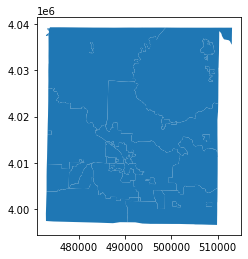

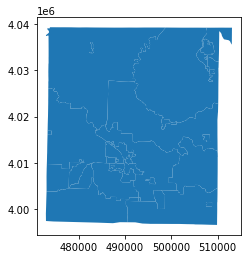

In [95]:
vboone = vest[vest['COUNTY_NAM']=='Boone'].copy()
recreated_boone.plot()
vboone.plot()

The data does not perfectly match, but we can clean this later in the join.

### Modify Carroll County

In [96]:
carroll_elec = elec_df[elec_df['county']=='Carroll'].copy()
carroll = prec[prec['county_nam']=='Carroll'].copy()
print('Precincts in election data: ', str(len(carroll_elec)))
print('Precincts in shapefile: ', str(len(carroll)))

Precincts in election data:  21
Precincts in shapefile:  31


#### After examining in QGIS, complete merges as required

In [97]:
to_dissolve = prec[prec['precinct'].isin(['Eureka Springs Ward 1','Eureka Springs Ward 2','Eureka Springs Ward 3'])].copy()
to_dissolve = to_dissolve.dissolve(by='county_fip')
to_dissolve['precinct'] = 'Eureka Springs Wards 1-3'

to_dissolve2 = prec[prec['precinct'].isin(['Berryville Ward 2','Berryville Ward 1'])].copy()
to_dissolve2 = to_dissolve2.dissolve(by='county_fip')
to_dissolve2['precinct'] = 'Berryville Ward 1-2'

to_dissolve3 = prec[prec['precinct'].isin(['NE Prairie','Cabanal','SE Prairie','NW & SW Prairie'])].copy()
to_dissolve3 = to_dissolve3.dissolve(by='county_fip')
to_dissolve3['precinct'] = 'Prairies/Cabanal'

li = ['North East Hickory','Long Creek','Northwest Hickory','Coin']
prec['precinct'] = prec.apply(lambda x: '_'.join(['Carroll',x['precinct']]) if x['precinct'] in li and x['county_nam']=='Carroll' else x['precinct'],axis=1)

to_dissolve4 = prec[prec['precinct'].isin(['Carroll_North East Hickory','Carroll_Long Creek','Carroll_Northwest Hickory','Carroll_Coin'])].copy()
to_dissolve4 = to_dissolve4.dissolve(by='county_fip')
to_dissolve4['precinct'] = 'NE/NW Hickory/Coin/Long Creek'

to_dissolve5 = prec[prec['precinct'].isin(['Green Forest Ward 1','Green Forest Ward 2'])].copy()
to_dissolve5 = to_dissolve5.dissolve(by='county_fip')
to_dissolve5['precinct'] = 'Green Forest Wards 1-2'

prec_remove_list = ['Eureka Springs Ward 1','Berryville Ward 2','NE Prairie','Carroll_North East Hickory','Berryville Ward 1','Carroll_Long Creek','Cabanal','SE Prairie','NW & SW Prairie','Eureka Springs Ward 2','Eureka Springs Ward 3','Green Forest Ward 1','Green Forest Ward 2','Carroll_Northwest Hickory','Carroll_Coin']

prec = prec[~prec['precinct'].isin(prec_remove_list)].copy()

prec = gp.GeoDataFrame(pd.concat([prec,to_dissolve,to_dissolve2,to_dissolve3,to_dissolve4, to_dissolve5]),crs=CRS)

In [98]:
carroll_elec = elec_df[elec_df['county']=='Carroll'].copy()
carroll = prec[prec['county_nam']=='Carroll'].copy()
print('Precincts in election data: ', str(len(carroll_elec)))
print('Precincts in shapefile: ', str(len(carroll)))

Precincts in election data:  21
Precincts in shapefile:  21


### Modify Chicot County

In [99]:
chicot_elec = elec_df[elec_df['county']=='Chicot'].copy()
chicot = prec[prec['county_nam']=='Chicot'].copy()
print('Precincts in election data: ', str(len(chicot_elec)))
print('Precincts in shapefile: ', str(len(chicot)))

Precincts in election data:  12
Precincts in shapefile:  13


#### After examining in QGIS, complete merges as required

In [100]:
to_dissolve = prec[prec['precinct'].isin(['101 - Carlton','102 - Carlton 2'])].copy()
to_dissolve = to_dissolve.dissolve(by='county_fip')
to_dissolve['precinct'] = 'Carlton 1&2'

prec = prec[~prec['precinct'].isin(['101 - Carlton','102 - Carlton 2'])].copy()
prec = gp.GeoDataFrame(pd.concat([to_dissolve,prec]),crs=CRS)

In [101]:
chicot_elec = elec_df[elec_df['county']=='Chicot'].copy()
chicot = prec[prec['county_nam']=='Chicot'].copy()
print('Precincts in election data: ', str(len(chicot_elec)))
print('Precincts in shapefile: ', str(len(chicot)))

Precincts in election data:  12
Precincts in shapefile:  12


### Modify Clark County

In [102]:
clark_elec = elec_df[elec_df['county']=='Clark'].copy()
clark = prec[prec['county_nam']=='Clark'].copy()
print('Precincts in election data: ', str(len(clark_elec)))
print('Precincts in shapefile: ', str(len(clark)))

Precincts in election data:  20
Precincts in shapefile:  27


#### After examining in QGIS, complete merges as required

In [103]:
to_dissolve = prec[prec['precinct'].isin(['Gurdon Ward 1','Gurdon Ward 2','Gurdon Ward 3','Gurdon Ward 4','Gurdon Ward 5'])].copy()
to_dissolve = to_dissolve.dissolve(by='county_fip')
to_dissolve['precinct'] = 'Gurdon Wards 1-5'

to_dissolve2 = prec[prec['precinct'].isin(['Caddo Valley Ward 1','Caddo Valley Ward 2','Caddo Valley Ward 3'])]
to_dissolve2 = to_dissolve2.dissolve(by='county_fip')
to_dissolve2['precinct'] = 'Caddo Valley Wards 1-3'


to_dissolve3 = prec[prec['precinct'].isin(['Gum Springs Outside 1','Gum Springs 1'])].copy()
to_dissolve3 = to_dissolve3.dissolve(by='county_fip')
to_dissolve3['precinct'] = 'Gum Springs Inside/Outside'

prec = prec[~prec['precinct'].isin(['Gurdon Ward 1','Gurdon Ward 2','Gurdon Ward 3','Gurdon Ward 4','Gurdon Ward 5','Caddo Valley Ward 1','Caddo Valley Ward 2','Caddo Valley Ward 3','Gum Springs Outside 1','Gum Springs 1'])].copy()

prec = gp.GeoDataFrame(pd.concat([to_dissolve,to_dissolve2,to_dissolve3,prec]),crs=CRS)

In [104]:
clark_elec = elec_df[elec_df['county']=='Clark'].copy()
clark = prec[prec['county_nam']=='Clark'].copy()
print('Precincts in election data: ', str(len(clark_elec)))
print('Precincts in shapefile: ', str(len(clark)))

Precincts in election data:  20
Precincts in shapefile:  20


### Modify Crittenden County

In [105]:
crit_elec = elec_df[elec_df['county']=='Crittenden'].copy()
crit = prec[prec['county_nam']=='Crittenden'].copy()
print('Precincts in election data: ', str(len(crit_elec)))
print('Precincts in shapefile: ', str(len(crit)))

Precincts in election data:  24
Precincts in shapefile:  43


#### After examining in QGIS, complete merges as required

In [106]:
to_dissolve = prec[prec['precinct'].isin(['68 - Jasper 2','78 - Jasper Country Box (Lakes'])].copy()
to_dissolve = to_dissolve.dissolve(by='county_fip')
to_dissolve['precinct'] = 'Jasper 2/Jasper CB 5'

to_dissolve2 = prec[prec['precinct'].isin(['75 - Jasper County Box, Sunset','69 - Jasper 3','66 - Mound City','65 - Jasper Country Box (Court'])].copy()
to_dissolve2 = to_dissolve2.dissolve(by='county_fip')
to_dissolve2['precinct'] = 'Jasper 3/Jasper CB 3&4/Mound City/Sunset'

to_dissolve3 = prec[prec['precinct'].isin(['14 - Ward 1 Precicnt 4','13 - Ward 1 Precicnt 3','33 - Ward 3 Precinct 3','72 - Proctor','71-Mississippi Country Box','31 - Ward 3 Precinct 1'])].copy()
to_dissolve3 = to_dissolve3.dissolve(by='county_fip')
to_dissolve3['precinct'] = 'Ward 1-3/1-4/3-1/3-3/Mississippi CB/Proctor'

to_dissolve4 = prec[prec['precinct'].isin(['59 - Earle Ward 1','60 - Earle Ward 2','81 - South Tyronza','74 - South Tyronza','73 - North Tyronza','61 - Earle Ward 3'])].copy()
to_dissolve4 = to_dissolve4.dissolve(by='county_fip')
to_dissolve4['precinct'] = 'Earle Wards 1-3/N&S Tyronza'

to_dissolve5 = prec[prec['precinct'].isin(['54 - East Black Oak','55- West Black Oak'])].copy()
to_dissolve5 = to_dissolve5.dissolve(by='county_fip')
to_dissolve5['precinct'] = 'E&W Black Oak'

to_dissolve6 = prec[prec['precinct'].isin(['22 - Ward 2 Precinct 2','21 - Ward 2 Precinct 1'])].copy()
to_dissolve6 = to_dissolve6.dissolve(by='county_fip')
to_dissolve6['precinct'] = 'West Memphis Ward 2-1/2-2'

to_dissolve7 = prec[prec['precinct'].isin(['12 - Ward 1 Precinct 2','11 - Ward 1 Precinct 1'])].copy()
to_dissolve7 = to_dissolve7.dissolve(by='county_fip')
to_dissolve7['precinct'] = 'West Memphis Ward 1-1/1-2'

to_dissolve8 = prec[prec['precinct'].isin(['42 - Ward 4 Precinct 2','41 - Ward 4 Precinct 1'])].copy()
to_dissolve8 = to_dissolve8.dissolve(by='county_fip')
to_dissolve8['precinct'] = 'West Memphis Ward 4-1/4-2'

to_dissolve9 = prec[prec['precinct'].isin(['76 - Wappanocca','82 - Wappanocca, Clarkdale','80 - Wappanocca, Jericho'])].copy()
to_dissolve9 = to_dissolve9.dissolve(by='county_fip')
to_dissolve9['precinct'] = 'Wappanocca 76/80/82'

prec = prec[~prec['precinct'].isin(['68 - Jasper 2','78 - Jasper Country Box (Lakes','75 - Jasper County Box, Sunset','69 - Jasper 3','66 - Mound City','65 - Jasper Country Box (Court','14 - Ward 1 Precicnt 4','13 - Ward 1 Precicnt 3','33 - Ward 3 Precinct 3','72 - Proctor','71-Mississippi Country Box','31 - Ward 3 Precinct 1','59 - Earle Ward 1','60 - Earle Ward 2','81 - South Tyronza','74 - South Tyronza','73 - North Tyronza','61 - Earle Ward 3','54 - East Black Oak','55- West Black Oak','22 - Ward 2 Precinct 2','21 - Ward 2 Precinct 1','12 - Ward 1 Precinct 2','11 - Ward 1 Precinct 1','42 - Ward 4 Precinct 2','41 - Ward 4 Precinct 1','76 - Wappanocca','82 - Wappanocca, Clarkdale','80 - Wappanocca, Jericho'])].copy()

prec = gp.GeoDataFrame(pd.concat([to_dissolve,to_dissolve2,to_dissolve3,to_dissolve4,to_dissolve5,to_dissolve6,to_dissolve7,to_dissolve8,to_dissolve9,prec]),crs=CRS)

In [107]:
crit_elec = elec_df[elec_df['county']=='Crittenden'].copy()
crit = prec[prec['county_nam']=='Crittenden'].copy()
print('Precincts in election data: ', str(len(crit_elec)))
print('Precincts in shapefile: ', str(len(crit)))

Precincts in election data:  24
Precincts in shapefile:  24


### Modify Dallas County

In [108]:
dallas_elec = elec_df[elec_df['county']=='Dallas'].copy()
dallas = prec[prec['county_nam']=='Dallas'].copy()
print('Precincts in election data: ', str(len(dallas_elec)))
print('Precincts in shapefile: ', str(len(dallas)))

Precincts in election data:  9
Precincts in shapefile:  16


#### After examining in QGIS, complete merges as required

In [109]:
to_dissolve = prec[prec['precinct'].isin(['501 - District 5','503 - District 5 -'])].copy()
to_dissolve = to_dissolve.dissolve(by='county_fip')
to_dissolve['precinct'] = 'District 5 (501/503)'

to_dissolve2 = prec[prec['precinct'].isin(['802 - District 8', '801- District 8'])].copy()
to_dissolve2 = to_dissolve2.dissolve(by='county_fip')
to_dissolve2['precinct'] =  'District 8 (801/802)'

to_dissolve3 = prec[prec['precinct'].isin(['901 - District 9', '902 - District 9'])].copy()
to_dissolve3 = to_dissolve3.dissolve(by='county_fip')
to_dissolve3['precinct'] = 'District 9 (901/902)'

to_dissolve4 = prec[prec['precinct'].isin(['602- District 6','601 - District 6', '603 - District 6'])].copy()
to_dissolve4 = to_dissolve4.dissolve(by='county_fip')
to_dissolve4['precinct'] = 'District 6 (601/602/603)'

to_dissolve5 = prec[prec['precinct'].isin(['701 - District 7', '704 - District 7','703 - District 7' ])].copy()
to_dissolve5 = to_dissolve5.dissolve(by='county_fip')
to_dissolve5['precinct'] = 'District 7 (701/704/703)'

prec = prec[~prec['precinct'].isin(['501 - District 5','503 - District 5 -','802 - District 8', '801- District 8','902 - District 9', '901 - District 9','602- District 6','601 - District 6', '603 - District 6','701 - District 7', '704 - District 7','703 - District 7'])].copy()

prec = gp.GeoDataFrame(pd.concat([to_dissolve,to_dissolve2,to_dissolve3,to_dissolve4, to_dissolve5, prec]),crs=CRS)

In [110]:
dallas_elec = elec_df[elec_df['county']=='Dallas'].copy()
dallas = prec[prec['county_nam']=='Dallas'].copy()
print('Precincts in election data: ', str(len(dallas_elec)))
print('Precincts in shapefile: ', str(len(dallas)))

Precincts in election data:  9
Precincts in shapefile:  9


### Modify Faulkner County

In [111]:
faulkner_elec = elec_df[elec_df['county']=='Faulkner'].copy()
faulkner = prec[prec['county_nam']=='Faulkner'].copy()
print('Precincts in election data: ', str(len(faulkner_elec)))
print('Precincts in shapefile: ', str(len(faulkner)))

Precincts in election data:  50
Precincts in shapefile:  51


#### After examining in QGIS, complete merges as required

In [112]:
to_dissolve = prec[prec['precinct'].isin(['2d Conway City 40','2a Conway City 07'])].copy()
to_dissolve = to_dissolve.dissolve(by='county_fip')
to_dissolve['precinct'] = 'Conway 2A'

prec = prec[~prec['precinct'].isin(['2d Conway City 40','2a Conway City 07'])].copy()
prec = gp.GeoDataFrame(pd.concat([to_dissolve, prec]),crs=CRS)

In [113]:
faulkner_elec = elec_df[elec_df['county']=='Faulkner'].copy()
faulkner = prec[prec['county_nam']=='Faulkner'].copy()
print('Precincts in election data: ', str(len(faulkner_elec)))
print('Precincts in shapefile: ', str(len(faulkner)))

Precincts in election data:  50
Precincts in shapefile:  50


### Modify Fulton County

In [114]:
fulton_elec = elec_df[elec_df['county']=='Fulton'].copy()
fulton = prec[prec['county_nam']=='Fulton'].copy()
print('Precincts in election data: ', str(len(fulton_elec)))
print('Precincts in shapefile: ', str(len(fulton)))

Precincts in election data:  11
Precincts in shapefile:  10


#### After examining in QGIS, we are unable to split the data on the line that VEST has. To validate, we will merge the VEST data together in the shapefile and our election results.

In [115]:
to_dissolve = vest[vest['PRECINCT'].isin(['Strawberry','Pleasant Ridge'])].copy()
to_dissolve = to_dissolve[to_dissolve['COUNTY_NAM']=='Fulton'].copy()
to_dissolve = to_dissolve.dissolve(by='COUNTY_FIP')
to_dissolve['PRECINCT'] = 'PR-SB'

vest['co_prec'] = vest.apply(lambda x: '_'.join([x['COUNTY_NAM'],x['PRECINCT']]),axis=1)
vest = vest[~vest['co_prec'].isin(['Fulton_Strawberry','Fulton_Pleasant Ridge'])].copy()
vest.drop(columns = ['co_prec'],inplace=True)
vest = gp.GeoDataFrame(pd.concat([to_dissolve, vest]),crs=CRS)


#### Modify the election results to be grouped for Strawberry and Pleasant Ridge as well

In [116]:
fulton_sub_id = ['Fulton_Pleasant ridge','Fulton_Strawberry']
fulton_sub = elec_df[elec_df['co_prec'].isin(fulton_sub_id)].copy()
display(fulton_sub)

,co_prec,county,prec,G18GOVRHUT,G18GOVDHEN,G18GOVLWES,G18LTGRGRI,G18LTGDBLA,G18LTGLGIL,G18ATGRRUT,G18ATGDLEE,G18ATGLHIC,G18SOSRTHU,G18SOSDINM,G18SOSLOLS,G18TRERMIL,G18TRELEWA,G18AUDRLEA,G18AUDLDIN,G18LNDRLAN,G18LNDDWIL,G18LNDLCAM,unique_ID,matches,unique_ID2,votes_cat
744,Fulton_Pleasant ridge,Fulton,Pleasant ridge,253.0,74.0,8.0,250.0,81.0,6.0,240.0,89.0,7.0,244.0,87.0,7.0,267.0,62.0,264.0,62.0,237.0,93.0,6.0,FULTON_PLEASANT RIDGE,FULTON_PLEASANT RIDGE,FULTON_PLEASANT RIDGE,253_74
746,Fulton_Strawberry,Fulton,Strawberry,178.0,56.0,9.0,176.0,55.0,9.0,181.0,51.0,9.0,168.0,64.0,8.0,189.0,48.0,190.0,47.0,166.0,60.0,12.0,FULTON_STRAWBERRY,FULTON_STRAWBERRY,FULTON_STRAWBERRY,178_56


In [117]:
data_cols = [i for i in fulton_sub.columns if '18' in i]
new_vals = []
for i in data_cols:
    new_val = fulton_sub[i].sum()
    new_vals.append(new_val)
val_dict = dict(zip(data_cols,new_vals))

new_fulton_data = pd.DataFrame(np.array(['Fulton_PR-SB']),columns = ['co_prec'])

new_fulton_data['county'] = 'Fulton'
new_fulton_data['prec'] = 'PR-SB'
for i in data_cols:
    new_fulton_data[i] = val_dict.get(i)

display(new_fulton_data)

,co_prec,county,prec,G18GOVRHUT,G18GOVDHEN,G18GOVLWES,G18LTGRGRI,G18LTGDBLA,G18LTGLGIL,G18ATGRRUT,G18ATGDLEE,G18ATGLHIC,G18SOSRTHU,G18SOSDINM,G18SOSLOLS,G18TRERMIL,G18TRELEWA,G18AUDRLEA,G18AUDLDIN,G18LNDRLAN,G18LNDDWIL,G18LNDLCAM
0,Fulton_PR-SB,Fulton,PR-SB,431.0,130.0,17.0,426.0,136.0,15.0,421.0,140.0,16.0,412.0,151.0,15.0,456.0,110.0,454.0,109.0,403.0,153.0,18.0


In [118]:
elec_df = elec_df[~elec_df['co_prec'].isin(fulton_sub_id)]
elec_df = pd.concat([new_fulton_data,elec_df])
elec_df.head(3)

,co_prec,county,prec,G18GOVRHUT,G18GOVDHEN,G18GOVLWES,G18LTGRGRI,G18LTGDBLA,G18LTGLGIL,G18ATGRRUT,G18ATGDLEE,G18ATGLHIC,G18SOSRTHU,G18SOSDINM,G18SOSLOLS,G18TRERMIL,G18TRELEWA,G18AUDRLEA,G18AUDLDIN,G18LNDRLAN,G18LNDDWIL,G18LNDLCAM,unique_ID,matches,unique_ID2,votes_cat
0,Fulton_PR-SB,Fulton,PR-SB,431.0,130.0,17.0,426.0,136.0,15.0,421.0,140.0,16.0,412.0,151.0,15.0,456.0,110.0,454.0,109.0,403.0,153.0,18.0,NaN,NaN,NaN,NaN
0,Marion_31,Marion,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MARION_31,MARION_31,MARION_31,0_0
1,Johnson_Centerpoint,Johnson,Centerpoint,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,0.0,JOHNSON_CENTERPOINT,,JOHNSON_LEE/STONEWALL (CENTERPOINT),2_0


In [119]:
fulton_elec = elec_df[elec_df['county']=='Fulton'].copy()
fulton = prec[prec['county_nam']=='Fulton'].copy()
print('Precincts in election data: ', str(len(fulton_elec)))
print('Precincts in shapefile: ', str(len(fulton)))

Precincts in election data:  10
Precincts in shapefile:  10


### Modify Greene County

In [120]:
greene_elec = elec_df[elec_df['county']=='Greene'].copy()
greene = prec[prec['county_nam']=='Greene'].copy()
print('Precincts in election data: ', str(len(greene_elec)))
print('Precincts in shapefile: ', str(len(greene)))

Precincts in election data:  36
Precincts in shapefile:  38


#### After examining in QGIS, complete merges as required

In [121]:
prec['precinct'] = prec.apply(lambda x: '_'.join(['Greene',x['precinct']])if x['precinct'].startswith('04 - Ward') or x['precinct'].startswith('03 - Ward') and x['county_nam']=='Greene' else x['precinct'],axis=1)

to_dissolve = prec[prec['precinct'].isin(['Greene_04 - Ward 4C','Greene_04 - Ward 4'])].copy()
to_dissolve = to_dissolve.dissolve(by='county_fip')
to_dissolve['precinct'] = 'Ward 4/4C'

to_dissolve2 = prec[prec['precinct'].isin(['Greene_03 - Ward 3', 'Greene_03 - Ward 3A'])].copy()
to_dissolve2 = to_dissolve2.dissolve(by='county_fip')
to_dissolve2['precinct'] = 'Ward 3/3A'

prec = prec[~prec['precinct'].isin(['Greene_04 - Ward 4C','Greene_04 - Ward 4','Greene_03 - Ward 3', 'Greene_03 - Ward 3A'])].copy()

prec = gp.GeoDataFrame(pd.concat([to_dissolve,to_dissolve2,prec]),crs=CRS)

In [122]:
greene_elec = elec_df[elec_df['county']=='Greene'].copy()
greene = prec[prec['county_nam']=='Greene'].copy()
print('Precincts in election data: ', str(len(greene_elec)))
print('Precincts in shapefile: ', str(len(greene)))

Precincts in election data:  36
Precincts in shapefile:  36


### Modify Hot Spring County

In [123]:
hot_springs_elec = elec_df[elec_df['county']=='Hot Spring'].copy()
hot_springs = prec[prec['county_nam']=='Hot Spring'].copy()
print('Precincts in election data: ', str(len(hot_springs_elec)))
print('Precincts in shapefile: ', str(len(hot_springs)))

Precincts in election data:  31
Precincts in shapefile:  35


#### After examining in QGIS, complete merges as required

In [124]:
to_dissolve = prec[prec['precinct'].isin(['Midway City', 'Midway City 2'])].copy()
to_dissolve = to_dissolve.dissolve(by='county_fip')
to_dissolve['precinct'] = 'Midway City 1&2'

to_dissolve2 = prec[prec['precinct'].isin(['Rockport W-2','Rockport W-1','Rockport W-1-4'])].copy()
to_dissolve2 = to_dissolve2.dissolve(by='county_fip')
to_dissolve2['precinct'] = 'Rockport Wards 1-2'

to_dissolve3 = prec[prec['precinct'].isin(['Malvern W-1A','Malvern W-1B'])].copy()
to_dissolve3 = to_dissolve3.dissolve(by='county_fip')
to_dissolve3['precinct'] = 'Malvern Ward 1'

prec = prec[~prec['precinct'].isin(['Midway City', 'Midway City 2', 'Rockport W-2','Rockport W-1','Rockport W-1-4','Malvern W-1A','Malvern W-1B'])].copy()

prec = gp.GeoDataFrame(pd.concat([to_dissolve,to_dissolve2,to_dissolve3,prec]),crs=CRS)

In [125]:
hot_springs_elec = elec_df[elec_df['county']=='Hot Spring'].copy()
hot_springs = prec[prec['county_nam']=='Hot Spring'].copy()
print('Precincts in election data: ', str(len(hot_springs_elec)))
print('Precincts in shapefile: ', str(len(hot_springs)))

Precincts in election data:  31
Precincts in shapefile:  31


### Modify Howard County

In [126]:
howard_elec = elec_df[elec_df['county']=='Howard'].copy()
howard = prec[prec['county_nam']=='Howard'].copy()
print('Precincts in election data: ', str(len(howard_elec)))
print('Precincts in shapefile: ', str(len(howard)))

Precincts in election data:  36
Precincts in shapefile:  49


#### After examining in QGIS, complete merges as required

In [127]:
to_dissolve = prec[prec['precinct'].isin(['19 - Saline','56 - Saline'])].copy()
to_dissolve = to_dissolve.dissolve(by='county_fip')
to_dissolve['precinct'] = '19 - Saline'

to_dissolve2 = prec[prec['precinct'].isin(['48 - Franklin','49 - Franklin'])].copy()
to_dissolve2 = to_dissolve2.dissolve(by='county_fip')
to_dissolve2['precinct'] = '48 - Franklin'

to_dissolve3 = prec[prec['precinct'].isin(['54 - Tollette','53 - Tollette'])].copy()
to_dissolve3 = to_dissolve3.dissolve(by='county_fip')
to_dissolve3['precinct'] = '54 - Tollette'

to_dissolve4 = prec[prec['precinct'].isin(['46 - Backland','45 - Blackland'])].copy()
to_dissolve4 = to_dissolve4.dissolve(by='county_fip')
to_dissolve4['precinct'] = '45 - Blackland'

to_dissolve5 = prec[prec['precinct'].isin(['12 - Muddy Fork','13 - Muddy Fork'])].copy()
to_dissolve5 = to_dissolve5.dissolve(by='county_fip')
to_dissolve5['precinct'] = '12 - Muddy Fork'

to_dissolve6 = prec[prec['precinct'].isin(['03 - Burg','04 - Burg'])].copy()
to_dissolve6 = to_dissolve6.dissolve(by='county_fip')
to_dissolve6['precinct'] = '03 - Burg'

to_dissolve7 = prec[prec['precinct'].isin(['16 - Center Point 1','15 - Center Point 1'])].copy()
to_dissolve7 = to_dissolve7.dissolve(by='county_fip')
to_dissolve7['precinct'] = '16 - Center Point 1'

to_dissolve8 = prec[prec['precinct'].isin(['06 - Clay','07 - Clay'])].copy()
to_dissolve8 = to_dissolve8.dissolve(by='county_fip')
to_dissolve8['precinct'] = '07 - Clay'

to_dissolve9 = prec[prec['precinct'].isin(['10 - Holly Creek','11 - Holly Creek'])].copy()
to_dissolve9 = to_dissolve9.dissolve(by='county_fip')
to_dissolve9['precinct'] = '10 - Holly Creek'

to_dissolve10 = prec[prec['precinct'].isin(['01 - Umpire','02 - Umpire'])].copy()
to_dissolve10 = to_dissolve10.dissolve(by='county_fip')
to_dissolve10['precinct'] = '01 - Umpire'

to_dissolve11 = prec[prec['precinct'].isin(['18 - Center Point 2','17 - Center Point 2'])].copy()
to_dissolve11 = to_dissolve11.dissolve(by='county_fip')
to_dissolve11['precinct'] = '17 - Center Point 2'

to_dissolve12 = prec[prec['precinct'].isin(['22 - Dillard','23 - Dillard'])].copy()
to_dissolve12 = to_dissolve12.dissolve(by='county_fip')
to_dissolve12['precinct'] = '22 - Dillard'

to_dissolve13 = prec[prec['precinct'].isin(['44 - Buck Range','43 - Buck Range'])].copy()
to_dissolve13 = to_dissolve13.dissolve(by='county_fip')
to_dissolve13['precinct'] = '44 - Buck Range'

drop_list = ['19 - Saline','48 - Franklin','46 - Backland','54 - Tollette','12 - Muddy Fork','03 - Burg','16 - Center Point 1',
            '06 - Clay','10 - Holly Creek','01 - Umpire','02 - Umpire','04 - Burg','07 - Clay','11 - Holly Creek',
            '13 - Muddy Fork','18 - Center Point 2','22 - Dillard','44 - Buck Range','45 - Blackland','53 - Tollette','56 - Saline',
            '15 - Center Point 1','17 - Center Point 2','49 - Franklin','43 - Buck Range','23 - Dillard']

prec = prec[~prec['precinct'].isin(drop_list)].copy()

concat_precs = [prec,to_dissolve,to_dissolve2,to_dissolve3,to_dissolve4,to_dissolve5,to_dissolve6,to_dissolve7,to_dissolve8,to_dissolve9,to_dissolve10,to_dissolve11,to_dissolve12,to_dissolve13]

prec = gp.GeoDataFrame(pd.concat(concat_precs),crs=CRS)

In [128]:
howard_elec = elec_df[elec_df['county']=='Howard'].copy()
howard = prec[prec['county_nam']=='Howard'].copy()
print('Precincts in election data: ', str(len(howard_elec)))
print('Precincts in shapefile: ', str(len(howard)))

Precincts in election data:  36
Precincts in shapefile:  36


### Modify Independence County

In [129]:
indep_elec = elec_df[elec_df['county']=='Independence'].copy()
indep = prec[prec['county_nam']=='Independence'].copy()
print('Precincts in election data: ', str(len(indep_elec)))
print('Precincts in shapefile: ', str(len(indep)))

Precincts in election data:  34
Precincts in shapefile:  36


#### After examining in QGIS, complete merges as required

In [130]:
to_dissolve = prec[prec['precinct'].isin(['Big Bottom Ward 1','Big Bottom Ward 2','Big Bottom Ward 3'])].copy()
to_dissolve = to_dissolve.dissolve(by='county_fip')
to_dissolve['precinct'] = 'Big Bottom Wards 1-3'

prec = prec[~prec['precinct'].isin(['Big Bottom Ward 1','Big Bottom Ward 2','Big Bottom Ward 3'])].copy()

prec = gp.GeoDataFrame(pd.concat([prec,to_dissolve]),crs=CRS)

In [131]:
indep_elec = elec_df[elec_df['county']=='Independence'].copy()
indep = prec[prec['county_nam']=='Independence'].copy()
print('Precincts in election data: ', str(len(indep_elec)))
print('Precincts in shapefile: ', str(len(indep)))

Precincts in election data:  34
Precincts in shapefile:  34


### Modify Izard County

In [132]:
izard_elec = elec_df[elec_df['county']=='Izard'].copy()
izard = prec[prec['county_nam']=='Izard'].copy()
print('Precincts in election data: ', str(len(izard_elec)))
print('Precincts in shapefile: ', str(len(izard)))

Precincts in election data:  47
Precincts in shapefile:  45


#### After examining in QGIS, we are unable to split the data on the line that VEST has. To validate, we will merge the VEST data together in the shapefile and our election results.

In [133]:
to_dissolve = vest[vest['PRECINCT'].isin(['Oxford City in Brockwell','Oxford City'])].copy()
to_dissolve = to_dissolve.dissolve(by='COUNTY_FIP')
to_dissolve['PRECINCT'] = 'Oxford City'

to_dissolve2 = vest[vest['PRECINCT'].isin(['Sage in Melbourne Ward 4','Melbourne Ward 4'])].copy()
to_dissolve2 = to_dissolve2.dissolve(by='COUNTY_FIP')
to_dissolve2['PRECINCT'] = 'Melbourne Ward 4'

vest = vest[~vest['PRECINCT'].isin(['Oxford City in Brockwell','Oxford City','Sage in Melbourne Ward 4','Melbourne Ward 4'])].copy()

vest = gp.GeoDataFrame(pd.concat([vest,to_dissolve,to_dissolve2]),crs=CRS)

#### Modify the election results to be grouped for Oxford City/Oxford City in Brockwell and Sage in Melbourne Ward 4/Melbourne Ward 4

In [134]:
izard_mel_id = ['Izard_Sage in melbourne ward 4','Izard_Melbourne - ward 4']
izard_mel = elec_df[elec_df['co_prec'].isin(izard_mel_id)].copy()
izard_ox_id = ['Izard_Oxford city in brockwell','Izard_Oxford city']
izard_ox = elec_df[elec_df['co_prec'].isin(izard_ox_id)].copy()
display(izard_mel)
display(izard_ox)


,co_prec,county,prec,G18GOVRHUT,G18GOVDHEN,G18GOVLWES,G18LTGRGRI,G18LTGDBLA,G18LTGLGIL,G18ATGRRUT,G18ATGDLEE,G18ATGLHIC,G18SOSRTHU,G18SOSDINM,G18SOSLOLS,G18TRERMIL,G18TRELEWA,G18AUDRLEA,G18AUDLDIN,G18LNDRLAN,G18LNDDWIL,G18LNDLCAM,unique_ID,matches,unique_ID2,votes_cat
1011,Izard_Melbourne - ward 4,Izard,Melbourne - ward 4,173.0,37.0,11.0,174.0,41.0,5.0,166.0,51.0,3.0,167.0,49.0,4.0,187.0,31.0,188.0,29.0,163.0,55.0,2.0,IZARD_MELBOURNE - WARD 4,IZARD_MELBOURNE WARD 4,IZARD_MELBOURNE WARD 4,173_37
1023,Izard_Sage in melbourne ward 4,Izard,Sage in melbourne ward 4,4.0,2.0,0.0,4.0,2.0,0.0,2.0,4.0,0.0,2.0,4.0,0.0,4.0,2.0,3.0,2.0,2.0,4.0,0.0,IZARD_SAGE IN MELBOURNE WARD 4,IZARD_SAGE IN MELBOURNE WARD 4,IZARD_SAGE IN MELBOURNE WARD 4,4_2


,co_prec,county,prec,G18GOVRHUT,G18GOVDHEN,G18GOVLWES,G18LTGRGRI,G18LTGDBLA,G18LTGLGIL,G18ATGRRUT,G18ATGDLEE,G18ATGLHIC,G18SOSRTHU,G18SOSDINM,G18SOSLOLS,G18TRERMIL,G18TRELEWA,G18AUDRLEA,G18AUDLDIN,G18LNDRLAN,G18LNDDWIL,G18LNDLCAM,unique_ID,matches,unique_ID2,votes_cat
1017,Izard_Oxford city,Izard,Oxford city,172.0,43.0,8.0,168.0,46.0,6.0,172.0,44.0,6.0,166.0,52.0,4.0,187.0,34.0,184.0,34.0,166.0,48.0,6.0,IZARD_OXFORD CITY,IZARD_OXFORD CITY,IZARD_OXFORD CITY,172_43
1018,Izard_Oxford city in brockwell,Izard,Oxford city in brockwell,1.0,3.0,0.0,4.0,0.0,0.0,2.0,2.0,0.0,2.0,2.0,0.0,4.0,0.0,4.0,0.0,3.0,1.0,0.0,IZARD_OXFORD CITY IN BROCKWELL,IZARD_OXFORD CITY IN BROCKWELL,IZARD_OXFORD CITY IN BROCKWELL,1_3


In [135]:
data_cols = [i for i in izard_ox.columns if '18' in i]
new_vals = []
for i in data_cols:
    new_val = izard_ox[i].sum()
    new_vals.append(new_val)

val_dict = dict(zip(data_cols,new_vals))

new_izard_ox = pd.DataFrame(np.array(['Izard_Oxford City']),columns = ['co_prec'])

new_izard_ox['county'] = 'Izard'
new_izard_ox['prec'] = 'Oxford City'
for i in data_cols:
    new_izard_ox[i] = val_dict.get(i)

display(new_izard_ox)

,co_prec,county,prec,G18GOVRHUT,G18GOVDHEN,G18GOVLWES,G18LTGRGRI,G18LTGDBLA,G18LTGLGIL,G18ATGRRUT,G18ATGDLEE,G18ATGLHIC,G18SOSRTHU,G18SOSDINM,G18SOSLOLS,G18TRERMIL,G18TRELEWA,G18AUDRLEA,G18AUDLDIN,G18LNDRLAN,G18LNDDWIL,G18LNDLCAM
0,Izard_Oxford City,Izard,Oxford City,173.0,46.0,8.0,172.0,46.0,6.0,174.0,46.0,6.0,168.0,54.0,4.0,191.0,34.0,188.0,34.0,169.0,49.0,6.0


In [136]:
data_cols = [i for i in izard_mel.columns if '18' in i]
new_vals = []
for i in data_cols:
    new_val = izard_mel[i].sum()
    new_vals.append(new_val)

val_dict = dict(zip(data_cols,new_vals))

new_izard_mel = pd.DataFrame(np.array(['Izard_Melbourne Ward 4']),columns = ['co_prec'])

new_izard_mel['county'] = 'Izard'
new_izard_mel['prec'] = 'Melbourne Ward 4'
for i in data_cols:
    new_izard_mel[i] = val_dict.get(i)

display(new_izard_mel)

,co_prec,county,prec,G18GOVRHUT,G18GOVDHEN,G18GOVLWES,G18LTGRGRI,G18LTGDBLA,G18LTGLGIL,G18ATGRRUT,G18ATGDLEE,G18ATGLHIC,G18SOSRTHU,G18SOSDINM,G18SOSLOLS,G18TRERMIL,G18TRELEWA,G18AUDRLEA,G18AUDLDIN,G18LNDRLAN,G18LNDDWIL,G18LNDLCAM
0,Izard_Melbourne Ward 4,Izard,Melbourne Ward 4,177.0,39.0,11.0,178.0,43.0,5.0,168.0,55.0,3.0,169.0,53.0,4.0,191.0,33.0,191.0,31.0,165.0,59.0,2.0


In [137]:
izard_ids = izard_mel_id + izard_ox_id
elec_df = elec_df[~elec_df['co_prec'].isin(izard_ids)]
elec_df = pd.concat([new_izard_mel,new_izard_ox,elec_df])
elec_df.head(4)

,co_prec,county,prec,G18GOVRHUT,G18GOVDHEN,G18GOVLWES,G18LTGRGRI,G18LTGDBLA,G18LTGLGIL,G18ATGRRUT,G18ATGDLEE,G18ATGLHIC,G18SOSRTHU,G18SOSDINM,G18SOSLOLS,G18TRERMIL,G18TRELEWA,G18AUDRLEA,G18AUDLDIN,G18LNDRLAN,G18LNDDWIL,G18LNDLCAM,unique_ID,matches,unique_ID2,votes_cat
0,Izard_Melbourne Ward 4,Izard,Melbourne Ward 4,177.0,39.0,11.0,178.0,43.0,5.0,168.0,55.0,3.0,169.0,53.0,4.0,191.0,33.0,191.0,31.0,165.0,59.0,2.0,NaN,NaN,NaN,NaN
0,Izard_Oxford City,Izard,Oxford City,173.0,46.0,8.0,172.0,46.0,6.0,174.0,46.0,6.0,168.0,54.0,4.0,191.0,34.0,188.0,34.0,169.0,49.0,6.0,NaN,NaN,NaN,NaN
0,Fulton_PR-SB,Fulton,PR-SB,431.0,130.0,17.0,426.0,136.0,15.0,421.0,140.0,16.0,412.0,151.0,15.0,456.0,110.0,454.0,109.0,403.0,153.0,18.0,NaN,NaN,NaN,NaN
0,Marion_31,Marion,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MARION_31,MARION_31,MARION_31,0_0


In [138]:
izard_elec = elec_df[elec_df['county']=='Izard'].copy()
izard = prec[prec['county_nam']=='Izard'].copy()
print('Precincts in election data: ', str(len(izard_elec)))
print('Precincts in shapefile: ', str(len(izard)))

Precincts in election data:  45
Precincts in shapefile:  45


### Modify Jefferson County

In [139]:
jeff_elec = elec_df[elec_df['county']=='Jefferson'].copy()
jeff = prec[prec['county_nam']=='Jefferson'].copy()
print('Precincts in election data: ', str(len(jeff_elec)))
print('Precincts in shapefile: ', str(len(jeff)))

Precincts in election data:  201
Precincts in shapefile:  188


#### Read in Arkansas VEST 2016 file

In [140]:
ar16 = gp.read_file('./raw-sources/ar_2016/ar_2016.shp')
jeff_16 = ar16[ar16['COUNTY_NAM']=='Jefferson'].copy()
jeff_16.head(1)

,COUNTY_FIP,COUNTY_NAM,PRECINCT,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREOMCM,G16PREGSTE,G16PREIHED,G16PRECCAS,G16PREIKAH,G16USSRBOO,G16USSDELD,G16USSLGIL,G16USSOWRI,geometry
748,069,Jefferson,10,19,5,0,0,0,0,0,0,21,2,0,0,"POLYGON ((629422.279 3786584.671, 629446.724 3..."


#### Subset Jefferson 2016 file for just the needed precincts per VEST documentation

In [141]:
prec_add = jeff_16[jeff_16['PRECINCT'].isin(['6', '35', '38', '39', '42', '43', '44', '46', '52', '63', '129', '402', '411'])].copy()
prec_add = prec_add[['COUNTY_NAM','PRECINCT','geometry']]
prec_add.rename(columns = {'COUNTY_NAM':'county_nam','PRECINCT':'precinct'},inplace=True)
prec_add['co_prec'] = prec_add.apply(lambda x: '_'.join([x['county_nam'],x['precinct']]),axis=1)

In [142]:
jeff = prec[prec['county_nam']=='Jefferson'].copy()
prec = prec[prec['county_nam']!='Jefferson'].copy()

In [143]:
jeff = gp.GeoDataFrame(pd.concat([jeff,prec_add]),crs=CRS)
prec = gp.GeoDataFrame(pd.concat([jeff,prec]),crs = CRS)

In [144]:
jeff_elec = elec_df[elec_df['county']=='Jefferson'].copy()
jeff = prec[prec['county_nam']=='Jefferson'].copy()
print('Precincts in election data: ', str(len(jeff_elec)))
print('Precincts in shapefile: ', str(len(jeff)))

Precincts in election data:  201
Precincts in shapefile:  201


### Modify Madison County

In [145]:
mad_elec = elec_df[elec_df['county']=='Madison'].copy()
mad = prec[prec['county_nam']=='Madison'].copy()
print('Precincts in election data: ', str(len(mad_elec)))
print('Precincts in shapefile: ', str(len(mad)))

Precincts in election data:  20
Precincts in shapefile:  10


#### Subset Madison 2016 from 2016 data

In [146]:
mad16 = ar16[ar16['COUNTY_NAM']=='Madison'].copy()

In [147]:
mad = mad[mad['precinct'].isin(['Huntsville Ward 1','Huntsville Ward 2','Huntsville Ward 3','Huntsville Ward 4'])]
display(mad)
mad16 = mad16[~mad16['PRECINCT'].isin(['Ward 1','Ward 2','Ward 3','Ward 4'])]

,geometry,OBJECTID,state_fips,county_nam,precinct,precinct_c,SHAPE_STAr,SHAPE_STLe,county_fip,co_prec
2712,"POLYGON ((432986.433 3995106.690, 432989.412 3...",33424.0,05,Madison,Huntsville Ward 1,21,3.998374e+06,11228.941630,087,NaN
2715,"POLYGON ((433575.284 3995076.329, 433592.466 3...",33427.0,05,Madison,Huntsville Ward 2,22,8.454411e+05,4586.271008,087,NaN
2719,"POLYGON ((434911.024 3997723.571, 434941.544 3...",33431.0,05,Madison,Huntsville Ward 3,23,7.854261e+06,28115.925310,087,NaN
2720,"POLYGON ((434947.193 3994222.758, 434930.421 3...",33432.0,05,Madison,Huntsville Ward 4,24,1.339883e+06,6866.278745,087,NaN


In [148]:
mad16 = mad16[['COUNTY_NAM','PRECINCT','geometry']]
mad16.rename(columns = {'COUNTY_NAM':'county_nam','PRECINCT':'precinct'},inplace=True)
mad16['county_nam'] = mad16['county_nam'].astype(str)
mad16['precinct'] = mad16['precinct'].astype(str)
mad16['co_prec'] = mad16.apply(lambda x: '_'.join([x['county_nam'],x['precinct']]),axis=1)

In [149]:
mad = gp.GeoDataFrame(pd.concat([mad,mad16]))
prec = prec[prec['county_nam']!='Madison'].copy()
prec = gp.GeoDataFrame(pd.concat([mad,prec]),crs=CRS)
display(prec.head(50))

,geometry,OBJECTID,state_fips,county_nam,precinct,precinct_c,SHAPE_STAr,SHAPE_STLe,county_fip,co_prec
2712,"POLYGON ((432986.433 3995106.690, 432989.412 3...",33424.0,05,Madison,Huntsville Ward 1,21,3.998374e+06,11228.941630,087,NaN
2715,"POLYGON ((433575.284 3995076.329, 433592.466 3...",33427.0,05,Madison,Huntsville Ward 2,22,8.454411e+05,4586.271008,087,NaN
2719,"POLYGON ((434911.024 3997723.571, 434941.544 3...",33431.0,05,Madison,Huntsville Ward 3,23,7.854261e+06,28115.925310,087,NaN
2720,"POLYGON ((434947.193 3994222.758, 434930.421 3...",33432.0,05,Madison,Huntsville Ward 4,24,1.339883e+06,6866.278745,087,NaN
2255,"POLYGON ((427705.425 3993143.828, 427815.726 3...",NaN,NaN,Madison,Richland,NaN,NaN,NaN,NaN,Madison_Richland
2256,"MULTIPOLYGON (((431984.975 3974860.336, 432025...",NaN,NaN,Madison,Lincoln,NaN,NaN,NaN,NaN,Madison_Lincoln
2257,"POLYGON ((430672.734 3981647.117, 430658.074 3...",NaN,NaN,Madison,Japton,NaN,NaN,NaN,NaN,Madison_Japton
2258,"POLYGON ((448704.215 3990343.743, 448996.673 3...",NaN,NaN,Madison,Wharton,NaN,NaN,NaN,NaN,Madison_Wharton
2259,"POLYGON ((437481.417 3987923.495, 437584.860 3...",NaN,NaN,Madison,Bowen,NaN,NaN,NaN,NaN,Madison_Bowen
2260,"POLYGON ((449753.591 3979061.910, 449905.418 3...",NaN,NaN,Madison,Boston,NaN,NaN,NaN,NaN,Madison_Boston


In [150]:
mad_elec = elec_df[elec_df['county']=='Madison'].copy()
mad = prec[prec['county_nam']=='Madison'].copy()
print('Precincts in election data: ', str(len(mad_elec)))
print('Precincts in shapefile: ', str(len(mad)))

Precincts in election data:  20
Precincts in shapefile:  20


### Modify Mississippi County

In [151]:
ms_elec = elec_df[elec_df['county']=='Mississippi'].copy()
ms = prec[prec['county_nam']=='Mississippi'].copy()
print('Precincts in election data: ', str(len(ms_elec)))
print('Precincts in shapefile: ', str(len(ms)))

Precincts in election data:  20
Precincts in shapefile:  54


#### After examining in QGIS, complete merges as required

In [152]:
to_dissolve = prec[prec['precinct'].isin(['19','17','16','18'])].copy()
to_dissolve = to_dissolve[to_dissolve['county_nam']=='Mississippi'].copy()
to_dissolve = to_dissolve.dissolve(by='county_fip')
to_dissolve['precinct'] = 'Leachville/Neal'

to_dissolve2 = prec[prec['precinct'].isin(['24','25','21','22','23'])].copy()
to_dissolve2 = to_dissolve2[to_dissolve2['county_nam']=='Mississippi'].copy()
to_dissolve2 = to_dissolve2.dissolve(by='county_fip')
to_dissolve2['precinct'] = 'Manila/Big Lake'

to_dissolve3 = prec[prec['precinct'].isin(['50','50A'])].copy()
to_dissolve3 = to_dissolve3[to_dissolve3['county_nam']=='Mississippi'].copy()
to_dissolve3 = to_dissolve3.dissolve(by='county_fip')
to_dissolve3['precinct'] = 'Etowah/Little River'

to_dissolve4 = prec[prec['precinct'].isin(['47','48'])].copy()
to_dissolve4 = to_dissolve4[to_dissolve4['county_nam']=='Mississippi'].copy()
to_dissolve4 = to_dissolve4.dissolve(by='county_fip')
to_dissolve4['precinct'] = 'Dyess City/Rural'

to_dissolve5 = prec[prec['precinct'].isin(['46','46A'])].copy()
to_dissolve5 = to_dissolve5[to_dissolve5['county_nam']=='Mississippi'].copy()
to_dissolve5 = to_dissolve5.dissolve(by='county_fip')
to_dissolve5['precinct'] = 'Birdsong/Whitton'

to_dissolve6 = prec[prec['precinct'].isin(['54','54A'])].copy()
to_dissolve6 = to_dissolve6[to_dissolve6['county_nam']=='Mississippi'].copy()
to_dissolve6 = to_dissolve6.dissolve(by='county_fip')
to_dissolve6['precinct'] = 'Bassett/Scott'

to_dissolve7 = prec[prec['precinct'].isin(['44','45'])].copy()
to_dissolve7 = to_dissolve7[to_dissolve7['county_nam']=='Mississippi'].copy()
to_dissolve7 = to_dissolve7.dissolve(by='county_fip')
to_dissolve7['precinct'] = 'Joiner/McGavock'

to_dissolve8 = prec[prec['precinct'].isin(['38','39','39A','40','41','42'])].copy()
to_dissolve8 = to_dissolve8[to_dissolve8['county_nam']=='Mississippi'].copy()
to_dissolve8 = to_dissolve8.dissolve(by='county_fip')
to_dissolve8['precinct'] = 'Marie/Carson/Wilson/Golden Lake'

to_dissolve9 = prec[prec['precinct'].isin(['32','33','34','35'])].copy()
to_dissolve9 = to_dissolve9[to_dissolve9['county_nam']=='Mississippi'].copy()
to_dissolve9 = to_dissolve9.dissolve(by='county_fip')
to_dissolve9['precinct'] = 'Osceola/Monroe 35'

to_dissolve10 = prec[prec['precinct'].isin(['36','37-1','37-2'])].copy()
to_dissolve10 = to_dissolve10[to_dissolve10['county_nam']=='Mississippi'].copy()
to_dissolve10 = to_dissolve10.dissolve(by='county_fip')
to_dissolve10['precinct'] = 'Keiser/Monroe 36'

to_dissolve11 = prec[prec['precinct'].isin(['29-1','29-2','29-3','30','30A'])].copy()
to_dissolve11 = to_dissolve11[to_dissolve11['county_nam']=='Mississippi'].copy()
to_dissolve11 = to_dissolve11.dissolve(by='county_fip')
to_dissolve11['precinct'] = 'Luxora/Victoria/Fletcher'

to_dissolve12 = prec[prec['precinct'].isin(['27','27A'])].copy()
to_dissolve12 = to_dissolve12[to_dissolve12['county_nam']=='Mississippi'].copy()
to_dissolve12 = to_dissolve12.dissolve(by='county_fip')
to_dissolve12['precinct'] = 'Burdette City/Rural'

to_dissolve13 = prec[prec['precinct'].isin(['06','11A','11B','02','07A'])].copy()
to_dissolve13 = to_dissolve13[to_dissolve13['county_nam']=='Mississippi'].copy()
to_dissolve13 = to_dissolve13.dissolve(by='county_fip')
to_dissolve13['precinct'] = 'Blytheville 2/Chickasawba'

to_dissolve14 = prec[prec['precinct'].isin(['13','14','15'])].copy()
to_dissolve14 = to_dissolve14[to_dissolve14['county_nam']=='Mississippi'].copy()
to_dissolve14 = to_dissolve14.dissolve(by='county_fip')
to_dissolve14['precinct'] = 'Dell/Half Moon/Hector'

to_dissolve15 = prec[prec['precinct'].isin(['12','12-3'])].copy()
to_dissolve15 = to_dissolve15[to_dissolve15['county_nam']=='Mississippi'].copy()
to_dissolve15 = to_dissolve15.dissolve(by='county_fip')
to_dissolve15['precinct'] = 'Gosnell 12-3/Bowen'

ms = ms[~ms['precinct'].isin(['12','12-3','13','14','15','06','11A','11B','02','07A','27','27A','29-1','29-2','29-3','30','30A','36','37-1','37-2','19','17','16','18','24','25','21','22','23','50','50A','47','48','46','46A','54','54A','44','45','38','39','39A','40','41','42','32','33','34','35'])].copy()

prec = prec[prec['county_nam']!='Mississippi'].copy()

ms = gp.GeoDataFrame(pd.concat([ms,to_dissolve,to_dissolve2,to_dissolve3,to_dissolve4,to_dissolve5,to_dissolve6,to_dissolve7,to_dissolve8,to_dissolve9,to_dissolve10,to_dissolve11,to_dissolve12,to_dissolve13,to_dissolve14,to_dissolve15]),crs=CRS)

prec = gp.GeoDataFrame(pd.concat([prec,ms]),crs=CRS)

In [153]:
ms_elec = elec_df[elec_df['county']=='Mississippi'].copy()
ms = prec[prec['county_nam']=='Mississippi'].copy()
print('Precincts in election data: ', str(len(ms_elec)))
print('Precincts in shapefile: ', str(len(ms)))

Precincts in election data:  20
Precincts in shapefile:  20


### Modify Monroe County

In [154]:
monroe_elec = elec_df[elec_df['county']=='Monroe'].copy()
monroe = prec[prec['county_nam']=='Monroe'].copy()
print('Precincts in election data: ', str(len(monroe_elec)))
print('Precincts in shapefile: ', str(len(monroe)))

Precincts in election data:  16
Precincts in shapefile:  24


#### After examining in QGIS, complete merges as required

In [155]:
to_dissolve = prec[prec['precinct'].isin(['08 - Brinkley Township','17 - Dixon Township'])].copy()
to_dissolve = to_dissolve.dissolve(by='county_fip')
to_dissolve['precinct'] = 'Brinkley-Dixon'

to_dissolve2 = prec[prec['precinct'].isin(['27 - Pine Ridge Township','21 - Hindman Township','28 - Raymond Township'])].copy()
to_dissolve2 = to_dissolve2.dissolve(by='county_fip')
to_dissolve2['precinct'] = 'Hindman-Pine Ridge-Raymond'

to_dissolve3 = prec[prec['precinct'].isin(['30 - Roc-Roe Township','31 - Roc-Roe Township/City'])].copy()
to_dissolve3 = to_dissolve3.dissolve(by='county_fip')
to_dissolve3['precinct'] = 'Roc Roe/Roe City'

to_dissolve4 = prec[prec['precinct'].isin(['26 - Montgomery/Smalley Townsh','15 - Cleburne','24 - Jackson Township'])].copy()
to_dissolve4 = to_dissolve4.dissolve(by='county_fip')
to_dissolve4['precinct'] = 'Jacksn-Clbrne-Mntgmry-Sma'

to_dissolve5 = prec[prec['precinct'].isin(['20 - Greenfield Township','19 - Fargo','29 - Richland Township'])].copy()
to_dissolve5 = to_dissolve5.dissolve(by='county_fip')
to_dissolve5['precinct'] = 'Richland-Greenfield-Fargo'

prec = prec[~prec['precinct'].isin(['08 - Brinkley Township','17 - Dixon Township','27 - Pine Ridge Township','21 - Hindman Township','28 - Raymond Township','30 - Roc-Roe Township','31 - Roc-Roe Township/City','26 - Montgomery/Smalley Townsh','15 - Cleburne','24 - Jackson Township','20 - Greenfield Township','19 - Fargo','29 - Richland Township'])].copy()

prec = gp.GeoDataFrame(pd.concat([prec,to_dissolve,to_dissolve2,to_dissolve3,to_dissolve4,to_dissolve5]),crs=CRS)

In [156]:
monroe_elec = elec_df[elec_df['county']=='Monroe'].copy()
monroe = prec[prec['county_nam']=='Monroe'].copy()
print('Precincts in election data: ', str(len(monroe_elec)))
print('Precincts in shapefile: ', str(len(monroe)))

Precincts in election data:  16
Precincts in shapefile:  16


### Modify Nevada County

In [157]:
nevada_elec = elec_df[elec_df['county']=='Nevada'].copy()
nevada = prec[prec['county_nam']=='Nevada'].copy()
print('Precincts in election data: ', str(len(nevada_elec)))
print('Precincts in shapefile: ', str(len(nevada)))

Precincts in election data:  12
Precincts in shapefile:  18


#### After examining in QGIS, complete merges as required

In [158]:
prec['precinct'] = prec['precinct'].astype(str)
prec['precinct'] = prec.apply(lambda x: '_'.join(['Nevada',x['precinct']])if x['precinct'].startswith('Ward') and x['county_nam']=='Nevada' else x['precinct'],axis=1)

to_dissolve = prec[prec['precinct'].isin(['Nevada_Ward 1','Nevada_Ward 2','Nevada_Ward 3','Nevada_Ward 4'])].copy()
to_dissolve = to_dissolve.dissolve(by='county_fip')
to_dissolve['precinct'] = 'Prescott Wards 1-4'

to_dissolve2 = prec[prec['precinct'].isin(['Bodcaw City','Bodcaw Rural'])].copy()
to_dissolve2 = to_dissolve2.dissolve(by='county_fip')
to_dissolve2['precinct'] = 'Bodcaw City/Rural'

to_dissolve3 = prec[prec['precinct'].isin(['Willisville Rural', 'Willisville City'])].copy()
to_dissolve3 = to_dissolve3.dissolve(by='county_fip')
to_dissolve3['precinct'] = 'Willisville City/Rural'

to_dissolve4 = prec[prec['precinct'].isin(['Bluff City Rural', 'Bluff City'])].copy()
to_dissolve4 = to_dissolve4.dissolve(by='county_fip')
to_dissolve4['precinct'] = 'Bluff City/Rural'

prec = prec[~prec['precinct'].isin(['Nevada_Ward 1','Nevada_Ward 2','Nevada_Ward 3','Nevada_Ward 4','Bodcaw City','Bodcaw Rural','Willisville Rural', 'Willisville City','Bluff City Rural', 'Bluff City'])].copy()

prec = gp.GeoDataFrame(pd.concat([prec,to_dissolve,to_dissolve2,to_dissolve3,to_dissolve4]),crs=CRS)

In [159]:
nevada_elec = elec_df[elec_df['county']=='Nevada'].copy()
nevada = prec[prec['county_nam']=='Nevada'].copy()
print('Precincts in election data: ', str(len(nevada_elec)))
print('Precincts in shapefile: ', str(len(nevada)))

Precincts in election data:  12
Precincts in shapefile:  12


### Modify Ouachita County

In [160]:
ouachita_elec = elec_df[elec_df['county']=='Ouachita'].copy()
ouachita = prec[prec['county_nam']=='Ouachita'].copy()
print('Precincts in election data: ', str(len(ouachita_elec)))
print('Precincts in shapefile: ', str(len(ouachita)))

Precincts in election data:  60
Precincts in shapefile:  18


In [161]:
display(ouachita)
display(ouachita_elec)

,geometry,OBJECTID,state_fips,county_nam,precinct,precinct_c,SHAPE_STAr,SHAPE_STLe,county_fip,co_prec
825,"POLYGON ((510322.053 3719598.772, 510313.467 3...",31537.0,05,Ouachita,001-Camden,1,1.015308e+07,23487.809884,103,NaN
829,"POLYGON ((495659.983 3700597.245, 495638.000 3...",31541.0,05,Ouachita,009-Stephens,9,7.154493e+06,20234.080183,103,NaN
830,"POLYGON ((519838.987 3694999.179, 519824.304 3...",31542.0,05,Ouachita,008-Louann,8,6.148897e+05,3315.706073,103,NaN
834,"POLYGON ((498300.131 3730843.123, 498287.679 3...",31546.0,05,Ouachita,006-Chidester,6,1.373476e+07,17757.727511,103,NaN
836,"POLYGON ((524577.271 3719393.570, 524831.899 3...",31548.0,05,Ouachita,007-East Camden,7,1.849554e+06,9677.394893,103,NaN
842,"POLYGON ((525182.891 3725045.612, 525200.692 3...",31554.0,05,Ouachita,011-County 002,11,1.010636e+08,86303.897946,103,NaN
843,"POLYGON ((538358.530 3740318.342, 538595.673 3...",31555.0,05,Ouachita,010-County 001,10,1.563455e+08,92917.857093,103,NaN
844,"POLYGON ((516507.190 3717819.362, 516534.318 3...",31556.0,05,Ouachita,002-Camden,2,7.365957e+06,19507.026523,103,NaN
845,"POLYGON ((517170.331 3711672.237, 517166.552 3...",31557.0,05,Ouachita,012-County 003,12,3.395478e+08,141994.547321,103,NaN
846,"POLYGON ((514215.286 3706660.960, 514204.177 3...",31558.0,05,Ouachita,013-County 004,13,2.779614e+08,115560.266514,103,NaN


,co_prec,county,prec,G18GOVRHUT,G18GOVDHEN,G18GOVLWES,G18LTGRGRI,G18LTGDBLA,G18LTGLGIL,G18ATGRRUT,G18ATGDLEE,G18ATGLHIC,G18SOSRTHU,G18SOSDINM,G18SOSLOLS,G18TRERMIL,G18TRELEWA,G18AUDRLEA,G18AUDLDIN,G18LNDRLAN,G18LNDDWIL,G18LNDLCAM,unique_ID,matches,unique_ID2,votes_cat
1628,Ouachita_Bearden ward 1,Ouachita,Bearden ward 1,99.0,54.0,3.0,95.0,57.0,3.0,90.0,61.0,6.0,95.0,56.0,3.0,103.0,42.0,101.0,42.0,93.0,60.0,3.0,OUACHITA_BEARDEN WARD 1,OUACHITA_BEARDEN WARD 1,OUACHITA_BEARDEN WARD 1,99_54
1629,Ouachita_Bearden ward 2,Ouachita,Bearden ward 2,26.0,43.0,1.0,22.0,45.0,4.0,22.0,45.0,1.0,23.0,46.0,1.0,29.0,33.0,31.0,33.0,21.0,49.0,1.0,OUACHITA_BEARDEN WARD 2,OUACHITA_BEARDEN WARD 2,OUACHITA_BEARDEN WARD 2,26_43
1630,Ouachita_Bearden ward 3,Ouachita,Bearden ward 3,18.0,12.0,1.0,18.0,12.0,1.0,18.0,12.0,1.0,18.0,12.0,1.0,21.0,9.0,20.0,8.0,17.0,14.0,0.0,OUACHITA_BEARDEN WARD 3,OUACHITA_BEARDEN WARD 3,OUACHITA_BEARDEN WARD 3,18_12
1631,Ouachita_Behestian,Ouachita,Behestian,19.0,33.0,1.0,21.0,33.0,1.0,18.0,36.0,0.0,18.0,36.0,1.0,21.0,28.0,25.0,27.0,19.0,37.0,0.0,OUACHITA_BEHESTIAN,OUACHITA_BEHESTIAN,OUACHITA_BEHESTIAN,19_33
1632,Ouachita_Bradley,Ouachita,Bradley,293.0,45.0,10.0,296.0,44.0,7.0,291.0,47.0,10.0,289.0,51.0,6.0,306.0,41.0,305.0,40.0,284.0,53.0,9.0,OUACHITA_BRADLEY,OUACHITA_BRADLEY,OUACHITA_BRADLEY,293_45
1633,Ouachita_Bragg,Ouachita,Bragg,88.0,59.0,2.0,84.0,61.0,2.0,80.0,68.0,1.0,80.0,66.0,2.0,85.0,60.0,85.0,59.0,79.0,68.0,1.0,OUACHITA_BRAGG,OUACHITA_BRAGG,OUACHITA_BRAGG,88_59
1634,Ouachita_Bridge creek,Ouachita,Bridge creek,122.0,65.0,7.0,129.0,65.0,4.0,127.0,64.0,5.0,124.0,70.0,4.0,133.0,58.0,133.0,60.0,122.0,72.0,4.0,OUACHITA_BRIDGE CREEK,OUACHITA_BRIDGE CREEK,OUACHITA_BRIDGE CREEK,122_65
1635,Ouachita_Camden ward 01,Ouachita,Camden ward 01,17.0,71.0,0.0,14.0,73.0,0.0,13.0,74.0,1.0,9.0,78.0,0.0,18.0,59.0,22.0,57.0,9.0,77.0,2.0,OUACHITA_CAMDEN WARD 01,OUACHITA_CAMDEN WARD 1,OUACHITA_CAMDEN WARD 1,17_71
1636,Ouachita_Camden ward 02,Ouachita,Camden ward 02,20.0,68.0,0.0,20.0,68.0,1.0,19.0,68.0,0.0,15.0,71.0,1.0,29.0,51.0,28.0,54.0,13.0,73.0,2.0,OUACHITA_CAMDEN WARD 02,OUACHITA_CAMDEN WARD 2,OUACHITA_CAMDEN WARD 2,20_68
1637,Ouachita_Camden ward 03,Ouachita,Camden ward 03,46.0,107.0,2.0,45.0,105.0,2.0,37.0,115.0,2.0,41.0,110.0,2.0,62.0,85.0,60.0,87.0,33.0,116.0,4.0,OUACHITA_CAMDEN WARD 03,OUACHITA_CAMDEN WARD 3,OUACHITA_CAMDEN WARD 3,46_107


Based on the Ouachita County election data and the shapefile, it is uncelar how they were split and VEST does not note any documentation as it pertains to Ouachita County shapefile modifications, so we cannot verify any of Ouachita County. It is possible that these precincts were different on the file they received.

### Modify Phillips County

In [162]:
phil_elec = elec_df[elec_df['county']=='Phillips'].copy()
phil = prec[prec['county_nam']=='Phillips'].copy()
print('Precincts in election data: ', str(len(phil_elec)))
print('Precincts in shapefile: ', str(len(phil)))

Precincts in election data:  16
Precincts in shapefile:  44


#### After examining in QGIS, complete merges as required

In [163]:
to_dissolve = prec[prec['precinct'].isin(['Elaine I','Tappan I','Tappan II','Elaine II'])].copy()
to_dissolve = to_dissolve.dissolve(by='county_fip')
to_dissolve['precinct'] = '16 - Elaine 1&2/Tappan 1&2'

to_dissolve2 = prec[prec['precinct'].isin(['Hickory Ridge Marvell II','Hickory Ridge Marvell 1','Hicksville','Hickory Ridge Marvell III','Hickory Ridge Marvell I'])].copy()
to_dissolve2 = to_dissolve2.dissolve(by='county_fip')
to_dissolve2['precinct'] = '13 - Hicksville/Hickory Ridge/Marvel'

to_dissolve3 = prec[prec['precinct'].isin(['Spring Creek IV','Lexa City'])].copy()
to_dissolve3 = to_dissolve3.dissolve(by='county_fip')
to_dissolve3['precinct'] = '10 - Lexa/Spring Creek 4'

to_dissolve4 = prec[prec['precinct'].isin(['St Francis IV','L-Anquille','Helena West Helena 1','St Francis II','St Francis I'])].copy()
to_dissolve4 = to_dissolve4.dissolve(by='county_fip')
to_dissolve4['precinct'] = "1 - HWH Ward 1/L'Anguille/St Francis 1,2,4"

to_dissolve5 = prec[prec['precinct'].isin(['Cleveland','Cypress','Lower Big Creek'])].copy()
to_dissolve5 = to_dissolve5[to_dissolve5['county_nam']=='Phillips'].copy()
to_dissolve5 = to_dissolve5.dissolve(by='county_fip')
to_dissolve5['precinct'] = '14 - Lower Big Creek/Cypress/Cleveland'

to_dissolve6 = prec[prec['precinct'].isin(['Bush','Spring Creek II','Spring Creek III','Spring Creek V','Spring Creek I'])].copy()
to_dissolve6 = to_dissolve6.dissolve(by='county_fip')
to_dissolve6['precinct'] = '9 - Bush/Spring Creek 1-3,5'

to_dissolve7 = prec[prec['precinct'].isin(['Searcy III','Searcy I','Searcy II','Lakeview City'])].copy()
to_dissolve7 = to_dissolve7.dissolve(by='county_fip')
to_dissolve7['precinct'] = '15 - Lakeview/Searcy 1-3'

to_dissolve8 = prec[prec['precinct'].isin(['Marion','Marion I'])].copy()
to_dissolve8 = to_dissolve8.dissolve(by='county_fip')
to_dissolve8['precinct'] = '11 - Marion 1&2'

to_dissolve9 = prec[prec['precinct'].isin(['Cleburne I','Cleburne II'])].copy()
to_dissolve9 = to_dissolve9.dissolve(by='county_fip')
to_dissolve9['precinct'] = '8 - Cleburne 1&2'

to_dissolve10 = prec[prec['precinct'].isin(['Hornor','Hornor IV','Hornor III','Hornor VII','Hornor II','Hornor V','Hornor VI'])].copy()
to_dissolve10 = to_dissolve10.dissolve(by='county_fip')
to_dissolve10['precinct'] = '7 - Hornor 1-7'

replace_list = ['Elaine I','Hickory Ridge Marvell II','Spring Creek IV','Tappan I','St Francis IV','Cleburne I','Hickory Ridge Marvell 1','Marion',
               'Cleveland','Lexa City','Hicksville','Cypress','Helena West Helena 1','Bush','Searcy III', 'Cleburne II','Hornor IV',
               'Hornor III','Hornor VII','Hornor II','Hornor V','Hornor VI','St Francis II','St Francis I','Searcy I','Searcy II','Lower Big Creek',
               'Tappan II','Elaine II','Marion I','Hickory Ridge Marvell III','Hickory Ridge Marvell I','Spring Creek V','Spring Creek II','Spring Creek III',
               'Spring Creek I','Lakeview City','Hornor','L-Anquille','5 - HWH Ward 3 A,B,C','6 - HWH Ward 3 D,E,F']

phil = phil[~phil['precinct'].isin(replace_list)].copy()

phil = gp.GeoDataFrame(pd.concat([phil,to_dissolve,to_dissolve2,to_dissolve3,to_dissolve4,to_dissolve5,to_dissolve6,to_dissolve7,to_dissolve8,to_dissolve9,to_dissolve10]),crs=CRS)

prec = prec[prec['county_nam']!='Phillips'].copy()
            
prec = gp.GeoDataFrame(pd.concat([prec,phil]),crs=CRS)

#### After looking, we do not have the proper file to split HWH Ward 3, so we will un-do the split in the election data and VEST file

In [164]:
to_dissolve = vest[vest['PRECINCT'].isin(['5 - HWH Ward 3 A,B,C','6 - HWH Ward 3 D,E,F'])]
to_dissolve = to_dissolve.dissolve(by='COUNTY_FIP')
to_dissolve['PRECINCT'] = 'Helena West Helena 3'

In [165]:
vest = vest[~vest['PRECINCT'].isin(['5 - HWH Ward 3 A,B,C','6 - HWH Ward 3 D,E,F'])].copy()
vest = gp.GeoDataFrame(pd.concat([vest,to_dissolve]))

In [166]:
phil_hwh_id = ['Phillips_Precinct 0005','Phillips_Precinct 0006']
phil_hwh = elec_df[elec_df['co_prec'].isin(phil_hwh_id)].copy()
display(phil_hwh)

,co_prec,county,prec,G18GOVRHUT,G18GOVDHEN,G18GOVLWES,G18LTGRGRI,G18LTGDBLA,G18LTGLGIL,G18ATGRRUT,G18ATGDLEE,G18ATGLHIC,G18SOSRTHU,G18SOSDINM,G18SOSLOLS,G18TRERMIL,G18TRELEWA,G18AUDRLEA,G18AUDLDIN,G18LNDRLAN,G18LNDDWIL,G18LNDLCAM,unique_ID,matches,unique_ID2,votes_cat
1710,Phillips_Precinct 0005,Phillips,Precinct 0005,98.0,190.0,9.0,78.0,212.0,7.0,80.0,213.0,6.0,67.0,221.0,11.0,118.0,145.0,128.0,135.0,67.0,219.0,10.0,PHILLIPS_PRECINCT 0005,,"PHILLIPS_5 - HWH WARD 3 A,B,C",98_190
1711,Phillips_Precinct 0006,Phillips,Precinct 0006,106.0,498.0,12.0,65.0,536.0,17.0,65.0,537.0,11.0,55.0,545.0,14.0,138.0,409.0,146.0,397.0,48.0,543.0,20.0,PHILLIPS_PRECINCT 0006,,"PHILLIPS_6 - HWH WARD 3 D,E,F",106_498


In [167]:
data_cols = [i for i in phil_hwh.columns if '18' in i]
new_vals = []
for i in data_cols:
    new_val = phil_hwh[i].sum()
    new_vals.append(new_val)

val_dict = dict(zip(data_cols,new_vals))

new_phil_hwh = pd.DataFrame(np.array(['Phillips_Helena West Helena 3']),columns = ['co_prec'])

new_phil_hwh['county'] = 'Phillips'
new_phil_hwh['prec'] = 'Helena West Helena 3'
for i in data_cols:
    new_phil_hwh[i] = val_dict.get(i)

display(new_phil_hwh)

,co_prec,county,prec,G18GOVRHUT,G18GOVDHEN,G18GOVLWES,G18LTGRGRI,G18LTGDBLA,G18LTGLGIL,G18ATGRRUT,G18ATGDLEE,G18ATGLHIC,G18SOSRTHU,G18SOSDINM,G18SOSLOLS,G18TRERMIL,G18TRELEWA,G18AUDRLEA,G18AUDLDIN,G18LNDRLAN,G18LNDDWIL,G18LNDLCAM
0,Phillips_Helena West Helena 3,Phillips,Helena West Helena 3,204.0,688.0,21.0,143.0,748.0,24.0,145.0,750.0,17.0,122.0,766.0,25.0,256.0,554.0,274.0,532.0,115.0,762.0,30.0


In [168]:
elec_df = elec_df[~elec_df['co_prec'].isin(phil_hwh_id)]
elec_df = pd.concat([new_phil_hwh,elec_df])
elec_df.head(4)

,co_prec,county,prec,G18GOVRHUT,G18GOVDHEN,G18GOVLWES,G18LTGRGRI,G18LTGDBLA,G18LTGLGIL,G18ATGRRUT,G18ATGDLEE,G18ATGLHIC,G18SOSRTHU,G18SOSDINM,G18SOSLOLS,G18TRERMIL,G18TRELEWA,G18AUDRLEA,G18AUDLDIN,G18LNDRLAN,G18LNDDWIL,G18LNDLCAM,unique_ID,matches,unique_ID2,votes_cat
0,Phillips_Helena West Helena 3,Phillips,Helena West Helena 3,204.0,688.0,21.0,143.0,748.0,24.0,145.0,750.0,17.0,122.0,766.0,25.0,256.0,554.0,274.0,532.0,115.0,762.0,30.0,NaN,NaN,NaN,NaN
0,Izard_Melbourne Ward 4,Izard,Melbourne Ward 4,177.0,39.0,11.0,178.0,43.0,5.0,168.0,55.0,3.0,169.0,53.0,4.0,191.0,33.0,191.0,31.0,165.0,59.0,2.0,NaN,NaN,NaN,NaN
0,Izard_Oxford City,Izard,Oxford City,173.0,46.0,8.0,172.0,46.0,6.0,174.0,46.0,6.0,168.0,54.0,4.0,191.0,34.0,188.0,34.0,169.0,49.0,6.0,NaN,NaN,NaN,NaN
0,Fulton_PR-SB,Fulton,PR-SB,431.0,130.0,17.0,426.0,136.0,15.0,421.0,140.0,16.0,412.0,151.0,15.0,456.0,110.0,454.0,109.0,403.0,153.0,18.0,NaN,NaN,NaN,NaN


In [169]:
phil_elec = elec_df[elec_df['county']=='Phillips'].copy()
phil = prec[prec['county_nam']=='Phillips'].copy()
print('Precincts in election data: ', str(len(phil_elec)))
print('Precincts in shapefile: ', str(len(phil)))

Precincts in election data:  15
Precincts in shapefile:  15


### Modify Poinsett County

In [170]:
poin_elec = elec_df[elec_df['county']=='Poinsett'].copy()
poin = prec[prec['county_nam']=='Poinsett'].copy()
print('Precincts in election data: ', str(len(poin_elec)))
print('Precincts in shapefile: ', str(len(poin)))

Precincts in election data:  13
Precincts in shapefile:  41


#### After examining in QGIS, complete merges as required

In [171]:
to_dissolve = prec[prec['precinct'].isin(['Willis Ward 3','Willis Ward 4','Willis Ward 1','Willis Ward 5','Willis Ward 2','Willis Township'])].copy()
to_dissolve = to_dissolve.dissolve(by='county_fip')
to_dissolve['precinct'] = 'Willis'

to_dissolve2 = prec[prec['precinct'].isin(['Scott - Whitehall','Scott - Valley View'])].copy()
to_dissolve2 = to_dissolve2.dissolve(by='county_fip')
to_dissolve2['precinct'] = 'Scott VV/WH'

prec['precinct'] = prec.apply(lambda x: '_'.join(['Poinsett',x['precinct']])if x['precinct'].startswith('Little River') and x['county_nam']=='Poinsett' else x['precinct'],axis=1)

to_dissolve3 = prec[prec['precinct'].isin(['Poinsett_Little River Ward 1','Poinsett_Little River Ward 2','Poinsett_Little River Ward 3','Poinsett_Little River Ward 4','Poinsett_Little River - Payneway','Poinsett_Little River Township'])].copy()
to_dissolve3 = to_dissolve3.dissolve(by='county_fip')
to_dissolve3['precinct'] = 'Little River & Payneway'

to_dissolve4 = prec[prec['precinct'].isin(['Owen - Waldenburg City','Owen - Waldenburg Rural'])].copy()
to_dissolve4 = to_dissolve4.dissolve(by='county_fip')
to_dissolve4['precinct'] = 'Owen - Waldenburg'

to_dissolve5 = prec[prec['precinct'].isin(['Bolivar Ward 1','Bolivar Ward 4','Bolivar Ward 3','Bolivard Ward 2','Bolivar North','Bolivar South'])].copy()
to_dissolve5 = to_dissolve5.dissolve(by='county_fip')
to_dissolve5['precinct'] = 'Bolivar'

to_dissolve6 = prec[prec['precinct'].isin(['Greenwood Ward 1','Greenwood Ward 2','Greenwod - Rivervale','Greenwood Ward 4','Greenwood Ward 3','Greenwood Township'])].copy()
to_dissolve6 = to_dissolve6.dissolve(by='county_fip')
to_dissolve6['precinct'] = 'Greenwood & Rivervale'

to_dissolve7 = prec[prec['precinct'].isin(['Lunsford - McCormick','Lunsford - Weona','Lunsford - Tulot'])].copy()
to_dissolve7 = to_dissolve7.dissolve(by='county_fip')
to_dissolve7['precinct'] = 'Lunsford'

to_dissolve8 = prec[prec['precinct'].isin(['Dobson - Cooper Haynes','Dobson - Pitts'])].copy()
to_dissolve8 = to_dissolve8.dissolve(by='county_fip')
to_dissolve8['precinct'] = 'Dobson'

to_dissolve9 = prec[prec['precinct'].isin(['West Prairie Rural','West Prairie City'])].copy()
to_dissolve9 = to_dissolve9.dissolve(by='county_fip')
to_dissolve9['precinct'] = 'West Prairie'

to_dissolve10 = prec[prec['precinct'].isin(['Owen - Fisher Rural','Owen - Fisher City'])].copy()
to_dissolve10 = to_dissolve10.dissolve(by='county_fip')
to_dissolve10['precinct'] = 'Owen - Fisher'

to_dissolve11 = prec[prec['precinct'].isin(['Tyronza Rural','Tyronza City'])].copy()
to_dissolve11 = to_dissolve11.dissolve(by='county_fip')
to_dissolve11['precinct'] = 'Tyronza'

poin = prec[prec['county_nam']=='Poinsett'].copy()
replace_list = list(poin['precinct'])
replace_list.remove('Greenfield - Buffalo Lick')
replace_list.remove('Greenfield - Greenfield')

prec = prec[~prec['precinct'].isin(replace_list)].copy()

concat_list = [to_dissolve,to_dissolve2,to_dissolve3,to_dissolve4,to_dissolve5,to_dissolve6,to_dissolve7,to_dissolve8,to_dissolve9,to_dissolve10,to_dissolve11,prec]

prec = gp.GeoDataFrame(pd.concat(concat_list),crs = CRS)

In [172]:
poin_elec = elec_df[elec_df['county']=='Poinsett'].copy()
poin = prec[prec['county_nam']=='Poinsett'].copy()
print('Precincts in election data: ', str(len(poin_elec)))
print('Precincts in shapefile: ', str(len(poin)))

Precincts in election data:  13
Precincts in shapefile:  13


### Modify St. Francis County

In [173]:
fran_elec = elec_df[elec_df['county']=='St. Francis'].copy()
fran = prec[prec['county_nam']=='St. Francis'].copy()
print('Precincts in election data: ', str(len(fran_elec)))
print('Precincts in shapefile: ', str(len(fran)))

Precincts in election data:  15
Precincts in shapefile:  48


#### After examining in QGIS, complete merges as required

In [174]:
to_dissolve = prec[prec['precinct'].isin(['43 - Forrest City Ward 2-3','45 - Forrest City Ward 2-4','41 - Forrest City Ward 2-2','55 - Forrest City Ward 2-6','50 - Forrest City Ward 2-2','40 - Forrest City Ward 2-1'])].copy()
to_dissolve = to_dissolve.dissolve(by='county_fip')
to_dissolve['precinct'] = 'Forrest City Ward 2'

to_dissolve2 = prec[prec['precinct'].isin(['19 - Newcastle','1 - Parrott','25-Parrot/Newcastle'])].copy()
to_dissolve2 = to_dissolve2.dissolve(by='county_fip')
to_dissolve2['precinct'] = 'Newcastle/Parrott'

to_dissolve3 = prec[prec['precinct'].isin(['20 - Colt City','27 - Pine Tree','21 - Colt Country'])].copy()
to_dissolve3 = to_dissolve3.dissolve(by='county_fip')
to_dissolve3['precinct'] = 'Colt City/Country/Pine Tree'

to_dissolve4 = prec[prec['precinct'].isin(['23 - Caldwell Country','22 - Caldwell City'])].copy()
to_dissolve4 = to_dissolve4.dissolve(by='county_fip')
to_dissolve4['precinct'] = 'Caldwell City/Country'

to_dissolve5 = prec[prec['precinct'].isin(['06 - Heth','07 - Blackfish'])].copy()
to_dissolve5 = to_dissolve5.dissolve(by='county_fip')
to_dissolve5['precinct'] = 'Heth/Blackfish'

to_dissolve6 = prec[prec['precinct'].isin(['34 - Wheatley Country','33 - Wheatley City'])].copy()
to_dissolve6 = to_dissolve6.dissolve(by='county_fip')
to_dissolve6['precinct'] = 'Wheatley Ciy/Country'

to_dissolve7 = prec[prec['precinct'].isin(['29 - Palestine City 2','30 - Palestine City 3','32 - Goodwin','31 - Palestine Country','28 - Palestine City 1'])].copy()
to_dissolve7 = to_dissolve7.dissolve(by='county_fip')
to_dissolve7['precinct'] = 'Palestine 1-3/Country/Goodwin'

to_dissolve8 = prec[prec['precinct'].isin(['65 - Forrest City Ward 4-5','66 - Forrest City Ward 4-6','56 - Forrest City Ward 4-2'])].copy()
to_dissolve8 = to_dissolve8.dissolve(by='county_fip')
to_dissolve8['precinct'] = 'Forrest City Ward 4'

to_dissolve9 = prec[prec['precinct'].isin(['02 - Hughes Ward 2','01 - Hughes Ward 1','03 - Hughes Ward 3','05 - Rawlison'])].copy()
to_dissolve9 = to_dissolve9.dissolve(by='county_fip')
to_dissolve9['precinct'] = 'Hughes 1-3/Country/Rawlison'

to_dissolve10 = prec[prec['precinct'].isin(['24 - Bonair','16 - Tuni','26 - Bonair','17 - Bonair'])].copy()
to_dissolve10 = to_dissolve10.dissolve(by='county_fip')
to_dissolve10['precinct'] = 'Bonair/Tuni'

to_dissolve11 = prec[prec['precinct'].isin(['53 - Forrest City Ward 3-5','52 - Forrest City Ward 3-4','49- Forrest City Ward 3-1'])].copy()
to_dissolve11 = to_dissolve11.dissolve(by='county_fip')
to_dissolve11['precinct'] = 'Forrest City Ward 3'

to_dissolve12 = prec[prec['precinct'].isin(['13 - Round Pond Mosley GW','11 - Round Pond Mosley GE','10 - Widener City GE','09 - Widener County GW'])].copy()
to_dissolve12 = to_dissolve12.dissolve(by='county_fip')
to_dissolve12['precinct'] = 'Widener City/Country/Round Pond Moseley GE&GW'

to_dissolve13 = prec[prec['precinct'].isin(['14 - Maidson City','15 - Madison Country'])].copy()
to_dissolve13 = to_dissolve13.dissolve(by='county_fip')
to_dissolve13['precinct'] = 'Madison City/Country'

to_dissolve14 = prec[prec['precinct'].isin(['57 - Forrest City Ward 1-6','35 - Forrest City Ward 1-1','38 - Forrest City Ward 1-4'])]
to_dissolve14 = to_dissolve14.dissolve(by='county_fip')
to_dissolve14['precinct'] = 'Forrest City Ward 1'

fran = prec[prec['county_nam']=='St. Francis'].copy()
replace_list = list(fran['precinct'])
replace_list.remove('26-Forrest City Country West')

prec = prec[~prec['precinct'].isin(replace_list)].copy()

concat_list = [to_dissolve,to_dissolve2,to_dissolve3,to_dissolve4,to_dissolve5,to_dissolve6,to_dissolve7,to_dissolve8,to_dissolve9,to_dissolve10,to_dissolve11,to_dissolve12,to_dissolve13,to_dissolve14,prec]

prec = gp.GeoDataFrame(pd.concat(concat_list),crs = CRS)

In [175]:
fran_elec = elec_df[elec_df['county']=='St. Francis'].copy()
fran = prec[prec['county_nam']=='St. Francis'].copy()
print('Precincts in election data: ', str(len(fran_elec)))
print('Precincts in shapefile: ', str(len(fran)))

Precincts in election data:  15
Precincts in shapefile:  15


### Modify Stone County

In [176]:
stone_elec = elec_df[elec_df['county']=='Stone'].copy()
stone = prec[prec['county_nam']=='Stone'].copy()
print('Precincts in election data: ', str(len(stone_elec)))
print('Precincts in shapefile: ', str(len(stone)))

Precincts in election data:  19
Precincts in shapefile:  19


#### After examining in QGIS, complete merges as required

In [177]:
to_dissolve = prec[prec['precinct'].isin(['Northwest','Fifty Six'])].copy()
to_dissolve = to_dissolve[to_dissolve['county_nam']=='Stone'].copy()
to_dissolve = to_dissolve.dissolve(by='county_fip')
to_dissolve['precinct'] = 'Northwest/Fifty Six'

stone = prec[prec['county_nam']=='Stone'].copy()
stone = stone[~stone['precinct'].isin(['Northwest','Fifty Six'])].copy()
stone = gp.GeoDataFrame(pd.concat([to_dissolve,stone]),crs = CRS)

prec = prec[prec['county_nam']!='Stone'].copy()
prec = gp.GeoDataFrame(pd.concat([stone,prec]),crs = CRS)

#### After looking, we do not have the proper file to split Ben 01 and 02, so we will un-do the split in the election data and VEST file

In [178]:
to_dissolve = vest[vest['PRECINCT'].isin(['Ben 02','Ben 01'])]
to_dissolve = to_dissolve.dissolve(by='COUNTY_FIP')
to_dissolve['PRECINCT'] = 'Ben'

In [179]:
vest = vest[~vest['PRECINCT'].isin(['Ben 02','Ben 01'])].copy()
vest = gp.GeoDataFrame(pd.concat([vest,to_dissolve]))

In [180]:
ben_id = ['Stone_Ben 01','Stone_Ben 02']
ben = elec_df[elec_df['co_prec'].isin(ben_id)].copy()
display(ben)

,co_prec,county,prec,G18GOVRHUT,G18GOVDHEN,G18GOVLWES,G18LTGRGRI,G18LTGDBLA,G18LTGLGIL,G18ATGRRUT,G18ATGDLEE,G18ATGLHIC,G18SOSRTHU,G18SOSDINM,G18SOSLOLS,G18TRERMIL,G18TRELEWA,G18AUDRLEA,G18AUDLDIN,G18LNDRLAN,G18LNDDWIL,G18LNDLCAM,unique_ID,matches,unique_ID2,votes_cat
2262,Stone_Ben 01,Stone,Ben 01,72.0,7.0,2.0,76.0,5.0,0.0,76.0,4.0,1.0,72.0,8.0,0.0,76.0,4.0,73.0,6.0,73.0,7.0,0.0,STONE_BEN 01,STONE_BEN 01,STONE_BEN 01,72_7
2263,Stone_Ben 02,Stone,Ben 02,12.0,0.0,0.0,12.0,0.0,0.0,12.0,0.0,0.0,12.0,0.0,0.0,12.0,0.0,12.0,0.0,12.0,0.0,0.0,STONE_BEN 02,STONE_BEN 02,STONE_BEN 02,12_0


In [181]:
data_cols = [i for i in ben.columns if '18' in i]
new_vals = []
for i in data_cols:
    new_val = ben[i].sum()
    new_vals.append(new_val)

val_dict = dict(zip(data_cols,new_vals))

new_ben = pd.DataFrame(np.array(['Stone_Ben']),columns = ['co_prec'])

new_ben['county'] = 'Stone'
new_ben['prec'] = 'Ben'
for i in data_cols:
    new_ben[i] = val_dict.get(i)

display(new_ben)

,co_prec,county,prec,G18GOVRHUT,G18GOVDHEN,G18GOVLWES,G18LTGRGRI,G18LTGDBLA,G18LTGLGIL,G18ATGRRUT,G18ATGDLEE,G18ATGLHIC,G18SOSRTHU,G18SOSDINM,G18SOSLOLS,G18TRERMIL,G18TRELEWA,G18AUDRLEA,G18AUDLDIN,G18LNDRLAN,G18LNDDWIL,G18LNDLCAM
0,Stone_Ben,Stone,Ben,84.0,7.0,2.0,88.0,5.0,0.0,88.0,4.0,1.0,84.0,8.0,0.0,88.0,4.0,85.0,6.0,85.0,7.0,0.0


In [182]:
elec_df = elec_df[~elec_df['co_prec'].isin(ben_id)]
elec_df = pd.concat([new_ben,elec_df])
elec_df.head(4)

,co_prec,county,prec,G18GOVRHUT,G18GOVDHEN,G18GOVLWES,G18LTGRGRI,G18LTGDBLA,G18LTGLGIL,G18ATGRRUT,G18ATGDLEE,G18ATGLHIC,G18SOSRTHU,G18SOSDINM,G18SOSLOLS,G18TRERMIL,G18TRELEWA,G18AUDRLEA,G18AUDLDIN,G18LNDRLAN,G18LNDDWIL,G18LNDLCAM,unique_ID,matches,unique_ID2,votes_cat
0,Stone_Ben,Stone,Ben,84.0,7.0,2.0,88.0,5.0,0.0,88.0,4.0,1.0,84.0,8.0,0.0,88.0,4.0,85.0,6.0,85.0,7.0,0.0,NaN,NaN,NaN,NaN
0,Phillips_Helena West Helena 3,Phillips,Helena West Helena 3,204.0,688.0,21.0,143.0,748.0,24.0,145.0,750.0,17.0,122.0,766.0,25.0,256.0,554.0,274.0,532.0,115.0,762.0,30.0,NaN,NaN,NaN,NaN
0,Izard_Melbourne Ward 4,Izard,Melbourne Ward 4,177.0,39.0,11.0,178.0,43.0,5.0,168.0,55.0,3.0,169.0,53.0,4.0,191.0,33.0,191.0,31.0,165.0,59.0,2.0,NaN,NaN,NaN,NaN
0,Izard_Oxford City,Izard,Oxford City,173.0,46.0,8.0,172.0,46.0,6.0,174.0,46.0,6.0,168.0,54.0,4.0,191.0,34.0,188.0,34.0,169.0,49.0,6.0,NaN,NaN,NaN,NaN


In [183]:
stone_elec = elec_df[elec_df['county']=='Stone'].copy()
stone = prec[prec['county_nam']=='Stone'].copy()
print('Precincts in election data: ', str(len(stone_elec)))
print('Precincts in shapefile: ', str(len(stone)))

Precincts in election data:  18
Precincts in shapefile:  18


### Modify Washington County

In [184]:
wash_elec = elec_df[elec_df['county']=='Washington'].copy()
wash = prec[prec['county_nam']=='Washington'].copy()
print('Precincts in election data: ', str(len(wash_elec)))
print('Precincts in shapefile: ', str(len(wash)))

Precincts in election data:  151
Precincts in shapefile:  154


#### After examining in QGIS, complete merges as required

In [185]:
to_dissolve = prec[prec['precinct'].isin(['Fay 09b','Fay 09a'])].copy()
to_dissolve = to_dissolve.dissolve(by='county_fip')
to_dissolve['precinct'] = 'FAYETTEVILLE 09'

to_dissolve2 = prec[prec['precinct'].isin(['Prairie Gr City-2','Prairie Gr City-1'])].copy()
to_dissolve2 = to_dissolve2.dissolve(by='county_fip')
to_dissolve2['precinct'] = 'Pgrv Cty'

#to_dissolve3 = prec[prec['precinct'].isin(['Fay 33','Wheeler-H'])].copy()
#to_dissolve3 = to_dissolve3.dissolve(by='county_fip')
#to_dissolve3['precinct'] = 'Wheeler H'

to_dissolve3 = prec[prec['precinct'].isin(['Farmington-2','Farmington-3'])].copy()
to_dissolve3 = to_dissolve3.dissolve(by='county_fip')
to_dissolve3['precinct'] = 'Farmington 2'

#'Fay 33','Wheeler-H'

prec = prec[~prec['precinct'].isin(['Farmington-2','Farmington-3','Fay 09b','Fay 09a','Prairie Gr City-2','Prairie Gr City-1'])].copy()

concat_list = [to_dissolve,to_dissolve2,to_dissolve3, prec]

prec = gp.GeoDataFrame(pd.concat(concat_list),crs = CRS)

In [186]:
wash_elec = elec_df[elec_df['county']=='Washington'].copy()
wash = prec[prec['county_nam']=='Washington'].copy()
print('Precincts in election data: ', str(len(wash_elec)))
print('Precincts in shapefile: ', str(len(wash)))

Precincts in election data:  151
Precincts in shapefile:  151


### Modify Johnson County

In [187]:
john_elec = elec_df[elec_df['county']=='Johnson'].copy()
john = prec[prec['county_nam']=='Johnson'].copy()
print('Precincts in election data: ', str(len(john_elec)))
print('Precincts in shapefile: ', str(len(john)))

Precincts in election data:  11
Precincts in shapefile:  22


In [188]:
to_dissolve = prec[prec['precinct'].isin(['STONEWALL','LEE'])].copy()
to_dissolve = to_dissolve.dissolve(by='county_fip')
to_dissolve = to_dissolve[to_dissolve['county_nam']=='Johnson'].copy()
to_dissolve['precinct'] = 'Centerpoint'

to_dissolve2 = prec[prec['precinct'].isin(['HICKEY','PERRY'])].copy()
to_dissolve2 = to_dissolve2.dissolve(by='county_fip')
to_dissolve2 = to_dissolve2[to_dissolve2['county_nam']=='Johnson'].copy()
to_dissolve2['precinct'] = 'Hagarville'

to_dissolve3 = prec[prec['precinct'].isin(['HORSEHEAD'])].copy()
to_dissolve3 = to_dissolve3.dissolve(by='county_fip')
to_dissolve3 = to_dissolve3[to_dissolve3['county_nam']=='Johnson'].copy()
to_dissolve3['precinct'] = 'Harmony'

to_dissolve4 = prec[prec['precinct'].isin(['HOWELL','MCKENNON'])].copy()
to_dissolve4 = to_dissolve4.dissolve(by='county_fip')
to_dissolve4 = to_dissolve4[to_dissolve4['county_nam']=='Johnson'].copy()
to_dissolve4['precinct'] = 'Knoxville'

to_dissolve5 = prec[prec['precinct'].isin(['PITTSBURG'])].copy()
to_dissolve5 = to_dissolve5.dissolve(by='county_fip')
to_dissolve5 = to_dissolve5[to_dissolve5['county_nam']=='Johnson'].copy()
to_dissolve5['precinct'] = 'Lamar'

to_dissolve6 = prec[prec['precinct'].isin(['PRAIRIE','SPARDA WARD 1','SPARDA WARD 2','SPARDA WARD 3','SPARDA WARD 4'])].copy()
to_dissolve6 = to_dissolve6.dissolve(by='county_fip')
to_dissolve6 = to_dissolve6[to_dissolve6['county_nam']=='Johnson'].copy()
to_dissolve6['precinct'] = 'Marvin Vinson'

to_dissolve7 = prec[prec['precinct'].isin(['REDLICK'])].copy()
to_dissolve7 = to_dissolve7.dissolve(by='county_fip')
to_dissolve7 = to_dissolve7[to_dissolve7['county_nam']=='Johnson'].copy()
to_dissolve7['precinct'] = 'Mt. Vernon'

to_dissolve8 = prec[prec['precinct'].isin(['MULBERRY','BATSON','DICKERSON-HILL'])].copy()
to_dissolve8 = to_dissolve8.dissolve(by='county_fip')
to_dissolve8 = to_dissolve8[to_dissolve8['county_nam']=='Johnson'].copy()
to_dissolve8['precinct'] = 'Oark'

to_dissolve9 = prec[prec['precinct'].isin(['SHERMAN','LOWGAP'])].copy()
to_dissolve9 = to_dissolve9.dissolve(by='county_fip')
to_dissolve9 = to_dissolve9[to_dissolve9['county_nam']=='Johnson'].copy()
to_dissolve9['precinct'] = 'Ozone'

to_dissolve10 = prec[prec['precinct'].isin(['WARD','GRANT'])].copy()
to_dissolve10 = to_dissolve10.dissolve(by='county_fip')
to_dissolve10 = to_dissolve10[to_dissolve10['county_nam']=='Johnson'].copy()
to_dissolve10['precinct'] = 'Westside'


to_dissolve11 = prec[prec['precinct'].isin(['KING'])].copy()
to_dissolve1 = to_dissolve11.dissolve(by='county_fip')
to_dissolve11 = to_dissolve11[to_dissolve11['county_nam']=='Johnson'].copy()
to_dissolve11['precinct'] = 'Woodland'

prec = prec[prec['county_nam']!='Johnson']
concat_list = [to_dissolve,to_dissolve2,to_dissolve3,to_dissolve4,to_dissolve5,to_dissolve6,to_dissolve7,to_dissolve8,to_dissolve9,to_dissolve10,to_dissolve11,prec]

prec = gp.GeoDataFrame(pd.concat(concat_list),crs = CRS)

In [189]:
john_elec = elec_df[elec_df['county']=='Johnson'].copy()
john = prec[prec['county_nam']=='Johnson'].copy()
print('Precincts in election data: ', str(len(john_elec)))
print('Precincts in shapefile: ', str(len(john)))

Precincts in election data:  11
Precincts in shapefile:  11


### Check the number of precincts by county in the shapefile and election results

In [190]:
dict_elec = subset_hd(elec_df,'county')
dict_prec = subset_hd(prec,'county_nam')

for k,v in dict_elec.items():
    for i,j in dict_prec.items():
        if k == i:
            if len(v) == len(j):
                continue
            else:
                print(k.upper(), ' HAS DIFFERENT NUMBER OF PRECINCTS IN ELEC AND SHP.')
                print('Election data has ', len(v), ' precincts.')
                print('Shapefile has ', len(j), ' precicnts.')
            print('------------------------------------------------------------------')
        else:
            continue

BOONE  HAS DIFFERENT NUMBER OF PRECINCTS IN ELEC AND SHP.
Election data has  29  precincts.
Shapefile has  12  precicnts.
------------------------------------------------------------------
OUACHITA  HAS DIFFERENT NUMBER OF PRECINCTS IN ELEC AND SHP.
Election data has  60  precincts.
Shapefile has  18  precicnts.
------------------------------------------------------------------


### Ouachita and Boone are too different in size, so we will remove them from the validation process.

<AxesSubplot:>

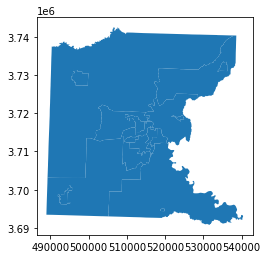

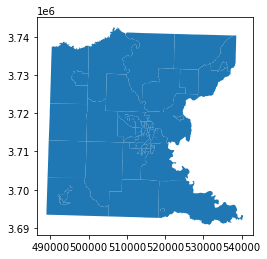

In [191]:
ouachita = prec[prec['county_nam']=='Ouachita'].copy()
vest_ouachita = vest[vest['COUNTY_NAM']=='Ouachita'].copy()
ouachita.plot()
vest_ouachita.plot()

<AxesSubplot:>

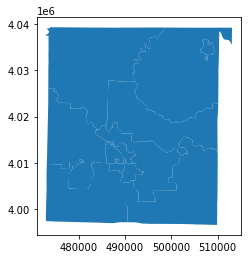

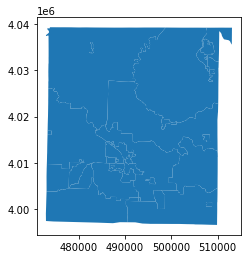

In [192]:
boone = prec[prec['county_nam']=='Boone'].copy()
vest_boone = vest[vest['COUNTY_NAM']=='Boone'].copy()
boone.plot()
vest_boone.plot()

In [193]:
prec = prec[~prec['county_nam'].isin(['Ouachita','Boone'])].copy()
elec_df = elec_df[~elec_df['county'].isin(['Ouachita','Boone'])].copy()
vest = vest[~vest['COUNTY_NAM'].isin(['Ouachita','Boone'])].copy()

### Create a unique ID and join the shapefiles with the election results

In [194]:
prec['co_prec'] = prec.apply(lambda x: '_'.join([x['county_nam'],x['precinct']]),axis=1)
prec['join_shp'] = prec['co_prec'].str.strip().str.upper()
elec_df['co_prec'] = elec_df['co_prec'].str.strip().str.upper()
elec_df['join_shp'] = elec_df['unique_ID2']
elec_df['join_shp'] = elec_df.apply(lambda x: x['co_prec'] if x['county']=='Crittenden' else x['join_shp'],axis=1)
elec_df['join_shp'] = elec_df.apply(lambda x: x['co_prec'] if x['county']=='Mississippi' else x['join_shp'],axis=1)
elec_df_null = elec_df[elec_df['unique_ID2'].isna()].copy()
display(elec_df_null)
elec_df_null_ids = list(elec_df_null['co_prec'])
print(elec_df_null_ids)

,co_prec,county,prec,G18GOVRHUT,G18GOVDHEN,G18GOVLWES,G18LTGRGRI,G18LTGDBLA,G18LTGLGIL,G18ATGRRUT,G18ATGDLEE,G18ATGLHIC,G18SOSRTHU,G18SOSDINM,G18SOSLOLS,G18TRERMIL,G18TRELEWA,G18AUDRLEA,G18AUDLDIN,G18LNDRLAN,G18LNDDWIL,G18LNDLCAM,unique_ID,matches,unique_ID2,votes_cat,join_shp
0,STONE_BEN,Stone,Ben,84.0,7.0,2.0,88.0,5.0,0.0,88.0,4.0,1.0,84.0,8.0,0.0,88.0,4.0,85.0,6.0,85.0,7.0,0.0,NaN,NaN,NaN,NaN,NaN
0,PHILLIPS_HELENA WEST HELENA 3,Phillips,Helena West Helena 3,204.0,688.0,21.0,143.0,748.0,24.0,145.0,750.0,17.0,122.0,766.0,25.0,256.0,554.0,274.0,532.0,115.0,762.0,30.0,NaN,NaN,NaN,NaN,NaN
0,IZARD_MELBOURNE WARD 4,Izard,Melbourne Ward 4,177.0,39.0,11.0,178.0,43.0,5.0,168.0,55.0,3.0,169.0,53.0,4.0,191.0,33.0,191.0,31.0,165.0,59.0,2.0,NaN,NaN,NaN,NaN,NaN
0,IZARD_OXFORD CITY,Izard,Oxford City,173.0,46.0,8.0,172.0,46.0,6.0,174.0,46.0,6.0,168.0,54.0,4.0,191.0,34.0,188.0,34.0,169.0,49.0,6.0,NaN,NaN,NaN,NaN,NaN
0,FULTON_PR-SB,Fulton,PR-SB,431.0,130.0,17.0,426.0,136.0,15.0,421.0,140.0,16.0,412.0,151.0,15.0,456.0,110.0,454.0,109.0,403.0,153.0,18.0,NaN,NaN,NaN,NaN,NaN


['STONE_BEN', 'PHILLIPS_HELENA WEST HELENA 3', 'IZARD_MELBOURNE WARD 4', 'IZARD_OXFORD CITY', 'FULTON_PR-SB']


In [195]:
elec_df_null['join_shp'] = elec_df_null['co_prec']
display(elec_df_null)

,co_prec,county,prec,G18GOVRHUT,G18GOVDHEN,G18GOVLWES,G18LTGRGRI,G18LTGDBLA,G18LTGLGIL,G18ATGRRUT,G18ATGDLEE,G18ATGLHIC,G18SOSRTHU,G18SOSDINM,G18SOSLOLS,G18TRERMIL,G18TRELEWA,G18AUDRLEA,G18AUDLDIN,G18LNDRLAN,G18LNDDWIL,G18LNDLCAM,unique_ID,matches,unique_ID2,votes_cat,join_shp
0,STONE_BEN,Stone,Ben,84.0,7.0,2.0,88.0,5.0,0.0,88.0,4.0,1.0,84.0,8.0,0.0,88.0,4.0,85.0,6.0,85.0,7.0,0.0,NaN,NaN,NaN,NaN,STONE_BEN
0,PHILLIPS_HELENA WEST HELENA 3,Phillips,Helena West Helena 3,204.0,688.0,21.0,143.0,748.0,24.0,145.0,750.0,17.0,122.0,766.0,25.0,256.0,554.0,274.0,532.0,115.0,762.0,30.0,NaN,NaN,NaN,NaN,PHILLIPS_HELENA WEST HELENA 3
0,IZARD_MELBOURNE WARD 4,Izard,Melbourne Ward 4,177.0,39.0,11.0,178.0,43.0,5.0,168.0,55.0,3.0,169.0,53.0,4.0,191.0,33.0,191.0,31.0,165.0,59.0,2.0,NaN,NaN,NaN,NaN,IZARD_MELBOURNE WARD 4
0,IZARD_OXFORD CITY,Izard,Oxford City,173.0,46.0,8.0,172.0,46.0,6.0,174.0,46.0,6.0,168.0,54.0,4.0,191.0,34.0,188.0,34.0,169.0,49.0,6.0,NaN,NaN,NaN,NaN,IZARD_OXFORD CITY
0,FULTON_PR-SB,Fulton,PR-SB,431.0,130.0,17.0,426.0,136.0,15.0,421.0,140.0,16.0,412.0,151.0,15.0,456.0,110.0,454.0,109.0,403.0,153.0,18.0,NaN,NaN,NaN,NaN,FULTON_PR-SB


In [196]:
elec_df = elec_df[~elec_df['co_prec'].isin(elec_df_null_ids)]
elec_df = pd.concat([elec_df_null,elec_df])
elec_df.head(6)

,co_prec,county,prec,G18GOVRHUT,G18GOVDHEN,G18GOVLWES,G18LTGRGRI,G18LTGDBLA,G18LTGLGIL,G18ATGRRUT,G18ATGDLEE,G18ATGLHIC,G18SOSRTHU,G18SOSDINM,G18SOSLOLS,G18TRERMIL,G18TRELEWA,G18AUDRLEA,G18AUDLDIN,G18LNDRLAN,G18LNDDWIL,G18LNDLCAM,unique_ID,matches,unique_ID2,votes_cat,join_shp
0,STONE_BEN,Stone,Ben,84.0,7.0,2.0,88.0,5.0,0.0,88.0,4.0,1.0,84.0,8.0,0.0,88.0,4.0,85.0,6.0,85.0,7.0,0.0,NaN,NaN,NaN,NaN,STONE_BEN
0,PHILLIPS_HELENA WEST HELENA 3,Phillips,Helena West Helena 3,204.0,688.0,21.0,143.0,748.0,24.0,145.0,750.0,17.0,122.0,766.0,25.0,256.0,554.0,274.0,532.0,115.0,762.0,30.0,NaN,NaN,NaN,NaN,PHILLIPS_HELENA WEST HELENA 3
0,IZARD_MELBOURNE WARD 4,Izard,Melbourne Ward 4,177.0,39.0,11.0,178.0,43.0,5.0,168.0,55.0,3.0,169.0,53.0,4.0,191.0,33.0,191.0,31.0,165.0,59.0,2.0,NaN,NaN,NaN,NaN,IZARD_MELBOURNE WARD 4
0,IZARD_OXFORD CITY,Izard,Oxford City,173.0,46.0,8.0,172.0,46.0,6.0,174.0,46.0,6.0,168.0,54.0,4.0,191.0,34.0,188.0,34.0,169.0,49.0,6.0,NaN,NaN,NaN,NaN,IZARD_OXFORD CITY
0,FULTON_PR-SB,Fulton,PR-SB,431.0,130.0,17.0,426.0,136.0,15.0,421.0,140.0,16.0,412.0,151.0,15.0,456.0,110.0,454.0,109.0,403.0,153.0,18.0,NaN,NaN,NaN,NaN,FULTON_PR-SB
0,MARION_31,Marion,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MARION_31,MARION_31,MARION_31,0_0,MARION_31


In [197]:
print('Are all of the election data IDs unique? ', len(elec_df)==len(elec_df['join_shp'].unique()))
print('Are all of the precinct IDs unique?', len(prec)==len(prec['join_shp'].unique()))
print('Are there the same number of precincts in the shapefile and election results? ', len(elec_df) == len(prec))
print('Are there the same number of precincts in the shapefile and VEST? ', len(prec) == len(vest))
print('Are there the same number of precincts in the election df and VEST? ', len(elec_df)==len(vest))
print(len(prec))
print(len(elec_df))
print(len(vest))

Are all of the election data IDs unique?  True
Are all of the precinct IDs unique? True
Are there the same number of precincts in the shapefile and election results?  True
Are there the same number of precincts in the shapefile and VEST?  True
Are there the same number of precincts in the election df and VEST?  True
2523
2523
2523


#### Join Attempt 1

In [198]:
join_attempt_1 = pd.merge(prec,elec_df,how="outer",on="join_shp",indicator=True)
print(join_attempt_1["_merge"].value_counts())

left_only     1815
right_only    1815
both           708
Name: _merge, dtype: int64


In [199]:
prec_only = join_attempt_1[join_attempt_1["_merge"]=="left_only"]
elec_only = join_attempt_1[join_attempt_1["_merge"]=="right_only"]
both = join_attempt_1[join_attempt_1["_merge"]=='both']
both_ids = list(both['join_shp'])

In [200]:
prec = fuzzy_merge(prec, elec_df, 'join_shp', threshold=90)

In [201]:
elec_df['join_shp2'] = elec_df['join_shp']
prec['join_shp2'] = prec.apply(lambda x: x['matches'] if x['join_shp'] not in both_ids else x['join_shp'], axis=1)
display(prec.head())

,geometry,OBJECTID,state_fips,county_nam,precinct,precinct_c,SHAPE_STAr,SHAPE_STLe,co_prec,county_fip,join_shp,matches,join_shp2
071,"POLYGON ((442475.710 3929892.624, 442447.549 3...",30784.0,05,Johnson,Centerpoint,STO,4.174354e+07,30260.536258,Johnson_Centerpoint,NaN,JOHNSON_CENTERPOINT,,
071,"POLYGON ((479816.907 3934696.575, 479816.677 3...",31193.0,05,Johnson,Hagarville,HIC,6.554186e+07,39783.185985,Johnson_Hagarville,NaN,JOHNSON_HAGARVILLE,,
071,"POLYGON ((452521.888 3938577.710, 452522.181 3...",31212.0,05,Johnson,Harmony,HOR,8.739749e+07,41938.915254,Johnson_Harmony,NaN,JOHNSON_HARMONY,,
071,"POLYGON ((461691.590 3917344.413, 462987.994 3...",31256.0,05,Johnson,Knoxville,MCK,4.757408e+07,37998.572872,Johnson_Knoxville,NaN,JOHNSON_KNOXVILLE,,
071,"POLYGON ((465054.993 3925341.044, 465164.587 3...",31254.0,05,Johnson,Lamar,PIT,6.437141e+07,33845.365346,Johnson_Lamar,NaN,JOHNSON_LAMAR,,


#### Join Attempt 2

In [202]:
join_attempt_2 = pd.merge(prec,elec_df,how="outer",on="join_shp2",indicator=True)
print(join_attempt_2["_merge"].value_counts())

right_only    1289
left_only     1282
both          1241
Name: _merge, dtype: int64


#### Make manual modifications

In [203]:
shp_dict = {
    #Arkansas County
    'ARKANSAS_31 - CHESTER':'ARKANSAS_CHESTER',
    'ARKANSAS_15 - ALMYRA':'ARKANSAS_ALMYRA',
    'ARKANSAS_38 - BAYOU METO':'ARKANSAS_BAYOU METO',
    'ARKANSAS_51 - DEWITT 1':'ARKANSAS_DEWITT 1',
    'ARKANSAS_81 - STUTTGART 2':'ARKANSAS_STUTTGART 2',
    'ARKANSAS_21 - PRAIRIE':'ARKANSAS_PRAIRIE',
    'ARKANSAS_91 - STUTTGART 3':'ARKANSAS_STUTTGART 3',
    'ARKANSAS_11 - MCFALL':'ARKANSAS_MCFALL',
    'ARKANSAS_13 - KEATON':'ARKANSAS_KEATON',
    'ARKANSAS_12 - CROCKETT':'ARKANSAS_CROCKETT',
    'ARKANSAS_44 - HENTON':'ARKANSAS_HENTON',
    'ARKANSAS_43 - BARTON':'ARKANSAS_BARTON',
    'ARKANSAS_46 - GARLAND':'ARKANSAS_GARLAND',
    'ARKANSAS_53 - DEWITT 2':'ARKANSAS_DEWITT 2',
    'ARKANSAS_55 - DEWITT 3':'ARKANSAS_DEWITT 3',
    'ARKANSAS_22 - LAGRUE':'ARKANSAS_LAGRUE',
    'ARKANSAS_23 - ST. CHARLES':'ARKANSAS_ST. CHARLES',
    'ARKANSAS_33 - STANLEY':'ARKANSAS_STANLEY',
    'ARKANSAS_37 - PT DELUCE':'ARKANSAS_PT DELUCE',
    'ARKANSAS_14 - MILL BAYOU':'ARKANSAS_MILL BAYOU',
    'ARKANSAS_45 - BREWER':'ARKANSAS_BREWER',
    'ARKANSAS_32 - ARKANSAS':'ARKANSAS_ARKANSAS',
    'ARKANSAS_71 - STUTTGART 1':'ARKANSAS_STUTTGART 1',
    'ARKANSAS_42 - GUM POND':'ARKANSAS_GUM POND',
    'ARKANSAS_41 - MORRIS':'ARKANSAS_MORRIS',
    
    #Ashley County
    'ASHLEY_07 - VO - TECH':'ASHLEY_VO - TECH',
    'ASHLEY_08 - COOTER':'ASHLEY_COOTER',
    'ASHLEY_09 - HICKORY GROVE':'ASHLEY_HICKORY GROVE',
    'ASHLEY_10 - CROSS ROADS':'ASHLEY_CROSS ROADS',
    'ASHLEY_11 - HAMBURG WARD 3':'ASHLEY_HAMBURG WARD 3',
    'ASHLEY_12 - HAMBURG WARD 2':'ASHLEY_HAMBURG WARD 2',
    'ASHLEY_13 - HAMBURG WARD 1':'ASHLEY_HAMBURG WARD 1',
    'ASHLEY_14 - HAMBURG RURAL':'ASHLEY_HAMBURG RURAL',
    'ASHLEY_15 - MT. ZION':'ASHLEY_MT. ZION',
    'ASHLEY_16 - MILO':'ASHLEY_MILO',
    'ASHLEY_17 - BEECH CREEK':'ASHLEY_BEECH CREEK',
    'ASHLEY_18 - MIST':'ASHLEY_MIST',
    'ASHLEY_21 - PORTLAND CITY':'ASHLEY_PORTLAND CITY',
    'ASHLEY_22 - PORTLAND RURAL':'ASHLEY_PORTLAND RURAL',
    'ASHLEY_23 - BOYDELL':'ASHLEY_BOYDELL',
    'ASHLEY_25 - MONTROSE CITY':'ASHLEY_MONTROSE CITY',
    'ASHLEY_26 - MONTROSE RURAL':'ASHLEY_MONTROSE RURAL',
    'ASHLEY_27 - PARKDALE CITY':'ASHLEY_PARKDALE CITY',
    'ASHLEY_28 - PARKDALE RURAL':'ASHLEY_PARKDALE RURAL',
    'ASHLEY_29 - WILMOT CITY':'ASHLEY_WILMOT CITY',
    'ASHLEY_30 - WILMOT RURAL':'ASHLEY_WILMOT RURAL',
    #BENTON COUNTY
    'BENTON_PRECINCT 01': 'BENTON_1', 'BENTON_PRECINCT 10': 'BENTON_10', 'BENTON_PRECINCT 100': 'BENTON_100', 'BENTON_PRECINCT 101': 'BENTON_101', 'BENTON_PRECINCT 102': 'BENTON_102', 'BENTON_PRECINCT 103': 'BENTON_103', 'BENTON_PRECINCT 104': 'BENTON_104', 'BENTON_PRECINCT 105': 'BENTON_105', 'BENTON_PRECINCT 106': 'BENTON_106', 'BENTON_PRECINCT 107': 'BENTON_107', 'BENTON_PRECINCT 108': 'BENTON_108', 'BENTON_PRECINCT 109': 'BENTON_109', 'BENTON_PRECINCT 11': 'BENTON_11', 'BENTON_PRECINCT 110': 'BENTON_110', 'BENTON_PRECINCT 111': 'BENTON_111', 'BENTON_PRECINCT 112': 'BENTON_112', 'BENTON_PRECINCT 113': 'BENTON_113', 'BENTON_PRECINCT 114': 'BENTON_114', 'BENTON_PRECINCT 115': 'BENTON_115', 'BENTON_PRECINCT 116': 'BENTON_116', 'BENTON_PRECINCT 117': 'BENTON_117', 'BENTON_PRECINCT 12': 'BENTON_12', 'BENTON_PRECINCT 13': 'BENTON_13', 'BENTON_PRECINCT 14': 'BENTON_14', 'BENTON_PRECINCT 15': 'BENTON_15', 'BENTON_PRECINCT 16': 'BENTON_16', 'BENTON_PRECINCT 17': 'BENTON_17', 'BENTON_PRECINCT 18': 'BENTON_18', 'BENTON_PRECINCT 19': 'BENTON_19', 'BENTON_PRECINCT 02': 'BENTON_2', 'BENTON_PRECINCT 20': 'BENTON_20', 'BENTON_PRECINCT 21': 'BENTON_21', 'BENTON_PRECINCT 22': 'BENTON_22', 'BENTON_PRECINCT 23': 'BENTON_23', 'BENTON_PRECINCT 24': 'BENTON_24', 'BENTON_PRECINCT 25': 'BENTON_25', 'BENTON_PRECINCT 26': 'BENTON_26', 'BENTON_PRECINCT 27': 'BENTON_27', 'BENTON_PRECINCT 28': 'BENTON_28', 'BENTON_PRECINCT 29': 'BENTON_29', 'BENTON_PRECINCT 03': 'BENTON_3', 'BENTON_PRECINCT 30': 'BENTON_30', 'BENTON_PRECINCT 31': 'BENTON_31', 'BENTON_PRECINCT 32': 'BENTON_32', 'BENTON_PRECINCT 33': 'BENTON_33', 'BENTON_PRECINCT 34': 'BENTON_34', 'BENTON_PRECINCT 35': 'BENTON_35', 'BENTON_PRECINCT 36': 'BENTON_36', 'BENTON_PRECINCT 37': 'BENTON_37', 'BENTON_PRECINCT 38': 'BENTON_38', 'BENTON_PRECINCT 39': 'BENTON_39', 'BENTON_PRECINCT 04': 'BENTON_4', 'BENTON_PRECINCT 40': 'BENTON_40', 'BENTON_PRECINCT 41': 'BENTON_41', 'BENTON_PRECINCT 42': 'BENTON_42', 'BENTON_PRECINCT 43': 'BENTON_43', 'BENTON_PRECINCT 44': 'BENTON_44', 'BENTON_PRECINCT 45': 'BENTON_45', 'BENTON_PRECINCT 46': 'BENTON_46', 'BENTON_PRECINCT 47': 'BENTON_47', 'BENTON_PRECINCT 48': 'BENTON_48', 'BENTON_PRECINCT 49': 'BENTON_49', 'BENTON_PRECINCT 05': 'BENTON_5', 'BENTON_PRECINCT 50': 'BENTON_50', 'BENTON_PRECINCT 51': 'BENTON_51', 'BENTON_PRECINCT 52': 'BENTON_52', 'BENTON_PRECINCT 53': 'BENTON_53', 'BENTON_PRECINCT 54': 'BENTON_54', 'BENTON_PRECINCT 55': 'BENTON_55', 'BENTON_PRECINCT 56': 'BENTON_56', 'BENTON_PRECINCT 57': 'BENTON_57', 'BENTON_PRECINCT 58': 'BENTON_58', 'BENTON_PRECINCT 59': 'BENTON_59', 'BENTON_PRECINCT 06': 'BENTON_6', 'BENTON_PRECINCT 60': 'BENTON_60', 'BENTON_PRECINCT 61': 'BENTON_61', 'BENTON_PRECINCT 62': 'BENTON_62', 'BENTON_PRECINCT 63': 'BENTON_63', 'BENTON_PRECINCT 64': 'BENTON_64', 'BENTON_PRECINCT 65': 'BENTON_65', 'BENTON_PRECINCT 66': 'BENTON_66', 'BENTON_PRECINCT 67': 'BENTON_67', 'BENTON_PRECINCT 68': 'BENTON_68', 'BENTON_PRECINCT 69': 'BENTON_69', 'BENTON_PRECINCT 07': 'BENTON_7', 'BENTON_PRECINCT 70': 'BENTON_70', 'BENTON_PRECINCT 71': 'BENTON_71', 'BENTON_PRECINCT 72': 'BENTON_72', 'BENTON_PRECINCT 73': 'BENTON_73', 'BENTON_PRECINCT 74': 'BENTON_74', 'BENTON_PRECINCT 75': 'BENTON_75', 'BENTON_PRECINCT 76': 'BENTON_76', 'BENTON_PRECINCT 77': 'BENTON_77', 'BENTON_PRECINCT 78': 'BENTON_78', 'BENTON_PRECINCT 79': 'BENTON_79', 'BENTON_PRECINCT 08': 'BENTON_8', 'BENTON_PRECINCT 80': 'BENTON_80', 'BENTON_PRECINCT 81': 'BENTON_81', 'BENTON_PRECINCT 82': 'BENTON_82', 'BENTON_PRECINCT 83': 'BENTON_83', 'BENTON_PRECINCT 84': 'BENTON_84', 'BENTON_PRECINCT 85': 'BENTON_85', 'BENTON_PRECINCT 86': 'BENTON_86', 'BENTON_PRECINCT 87': 'BENTON_87', 'BENTON_PRECINCT 88': 'BENTON_88', 'BENTON_PRECINCT 89': 'BENTON_89', 'BENTON_PRECINCT 09': 'BENTON_9', 'BENTON_PRECINCT 90': 'BENTON_90', 'BENTON_PRECINCT 91': 'BENTON_91', 'BENTON_PRECINCT 92': 'BENTON_92', 'BENTON_PRECINCT 93': 'BENTON_93', 'BENTON_PRECINCT 94': 'BENTON_94', 'BENTON_PRECINCT 95': 'BENTON_95', 'BENTON_PRECINCT 96': 'BENTON_96', 'BENTON_PRECINCT 97': 'BENTON_97', 'BENTON_PRECINCT 98': 'BENTON_98', 'BENTON_PRECINCT 99': 'BENTON_99',
    #BRADLEY COUNTY
    'BRADLEY_01 - WARREN WARD 1':'BRADLEY_WARREN WARD 1',
    'BRADLEY_02 - WARREN WARD 2':'BRADLEY_WARREN WARD 2',
    'BRADLEY_03 - WARREN WARD 3':'BRADLEY_WARREN WARD 3',
    'BRADLEY_04 - NORTH':'BRADLEY_NORTH',
    'BRADLEY_05 - SOUTH':'BRADLEY_SOUTH',
    'BRADLEY_06 - BANKS CITY':'BRADLEY_BANKS CITY',
    'BRADLEY_07 - BANKS RURAL':'BRADLEY_BANKS RURAL',
    'BRADLEY_08 - SPRINGHILL':'BRADLEY_SPRINGHILL',
    'BRADLEY_11 - EAGLE LAKE':'BRADLEY_EAGLE LAKE',
    'BRADLEY_12 - JERSEY':'BRADLEY_JERSEY',
    'BRADLEY_13 - JOHNSVILLE':'BRADLEY_JOHNSVILLE',
    'BRADLEY_14 - MARION':'BRADLEY_MARION',
    #CARROLL COUNTY
    'CARROLL_SW & SE HICKORY':'CARROLL_SOUTH WEST HICKORY/SOUTH EAST HICKORY',
    #CHICOT COUNTY
    'CHICOT_103 - CARLTON 3':'CHICOT_CARLTON 3',
    'CHICOT_104 - CARLTON RURAL':'CHICOT_CARLTON RURAL',
    'CHICOT_201 - PLANTERS 1':'CHICOT_PLANTERS 1',
    'CHICOT_202 - PLANTERS 2':'CHICOT_PLANTERS 2',
    'CHICOT_203 - PLANTERS 3':'CHICOT_PLANTERS 3',
    'CHICOT_204 - PLANTERS 4':'CHICOT_PLANTERS 4',
    'CHICOT_205 - PLANTERS RURAL':'CHICOT_PLANTERS RURAL',
    'CHICOT_301 - BOWIE 1':'CHICOT_BOWIE WARD 1',
    'CHICOT_302 - BOWIE 2':'CHICOT_BOWIE WARD 2',
    'CHICOT_303 - BOWIE 3':'CHICOT_BOWIE WARD 3',
    'CHICOT_304 - BOWIE RURAL':'CHICOT_BOWIE RURAL',
    #CLARK COUNTY
    'CLARK_ARKADELPHIA WARD 1':'CLARK_ARKADELPHIA JP1',
    'CLARK_ARKADELPHIA WARD 2':'CLARK_ARKADELPHIA JP2',
    'CLARK_ARKADELPHIA WARD 3':'CLARK_ARKADELPHIA JP3',
    'CLARK_ARKADELPHIA WARD 4':'CLARK_ARKADELPHIA JP4',
    'CLARK_ARKADELPHIA WARD 5':'CLARK_ARKADELPHIA JP5',
    'CLARK_GURDON GEN 1':'CLARK_GURDON CENTRAL',
    #CLEBURNE COUNTY
    'CLEBURNE_06 - CALIFORNIA': 'CLEBURNE_CALIFORNIA', 'CLEBURNE_07 - CENTER POST': 'CLEBURNE_CENTER POST', 'CLEBURNE_08 - CLAYTON': 'CLEBURNE_CLAYTON', 'CLEBURNE_09 - FRANCIS': 'CLEBURNE_FRANCIS', 'CLEBURNE_13 - GILES': 'CLEBURNE_GILES', 'CLEBURNE_19 - HEBER SPRINGS OUTSIDE': 'CLEBURNE_HEBER SPRINGS OUT', 'CLEBURNE_15 - HEBER SPRINGS WARD 1': 'CLEBURNE_HEBER WARD 1', 'CLEBURNE_16 - HEBER SPRINGS WARD 2': 'CLEBURNE_HEBER WARD 2', 'CLEBURNE_17 - HEBER SPRINGS WARD 3': 'CLEBURNE_HEBER WARD 3', 'CLEBURNE_18 - HEBER SPRINGS WARD 4': 'CLEBURNE_HEBER WARD 4', 'CLEBURNE_20 - MCJESTER': 'CLEBURNE_MCJESTER', 'CLEBURNE_22 - MOUNTAIN': 'CLEBURNE_MOUNTAIN', 'CLEBURNE_25 - PICKENS': 'CLEBURNE_PICKENS', 'CLEBURNE_26 - PINE': 'CLEBURNE_PINE', 'CLEBURNE_27 - PINEY': 'CLEBURNE_PINEY', 'CLEBURNE_28 - POFF': 'CLEBURNE_POFF', 'CLEBURNE_31 - SUGAR CAMP': 'CLEBURNE_SUGAR CAMP', 'CLEBURNE_32 - SUGAR LOAF': 'CLEBURNE_SUGAR LOAF', 'CLEBURNE_33 - VALLEY': 'CLEBURNE_VALLEY', 'CLEBURNE_34 - WILBURN': 'CLEBURNE_WILBURN',
    #CLEVELAND COUNTY
    'CLEVELAND_01A - RISON INSIDE': 'CLEVELAND_RISON INSIDE', 'CLEVELAND_01B - RISON OUTSIDE': 'CLEVELAND_RISON OUTSIDE', 'CLEVELAND_02B - KINGSLAND OUT': 'CLEVELAND_KINGSLAND OUT', 'CLEVELAND_03 - BOWMAN': 'CLEVELAND_BOWMAN', 'CLEVELAND_04 - HARPER': 'CLEVELAND_HARPER', 'CLEVELAND_05 - HUDGIN': 'CLEVELAND_HUDGIN', 'CLEVELAND_06 - HURRICANE': 'CLEVELAND_HURRICANE', 'CLEVELAND_07 - LEE': 'CLEVELAND_LEE', 'CLEVELAND_08 - MILLER': 'CLEVELAND_MILLER', 'CLEVELAND_09 - NIVEN': 'CLEVELAND_NIVEN', 'CLEVELAND_10 - REDLAND': 'CLEVELAND_REDLAND', 'CLEVELAND_11 - ROWELL': 'CLEVELAND_ROWELL', 'CLEVELAND_12 - SALINE': 'CLEVELAND_SALINE', 'CLEVELAND_14 - SMITH': 'CLEVELAND_SMITH', 'CLEVELAND_15 - WHITEOAK': 'CLEVELAND_WHITEOAK', 'CLEVELAND_16 - WHITEVILLE': 'CLEVELAND_WHITEVILLE',
    #COLUMBIA COUNTY
    'COLUMBIA_MAG WARD 1': 'COLUMBIA_MAGNOLIA WARD 1', 'COLUMBIA_MAG WARD 2': 'COLUMBIA_MAGNOLIA WARD 2', 'COLUMBIA_MAG WARD 3': 'COLUMBIA_MAGNOLIA WARD 3', 'COLUMBIA_MAG WARD 4': 'COLUMBIA_MAGNOLIA WARD 4', 'COLUMBIA_WALDO TOWNSHIP': 'COLUMBIA_WALDO TWP', 'COLUMBIA_WALDO CITY': 'COLUMBIA_WALDO WARD 1, 2, 3',
    #CONWAY COUNTY
    'CONWAY_001 - AUSTIN': 'CONWAY_AUSTIN', 'CONWAY_002 - BENTLEY CITY': 'CONWAY_BENTLEY WARDS 1, 2', 'CONWAY_003 - WELBOURNE WEST': 'CONWAY_WELBOURNE WEST', 'CONWAY_004 - ST VINCENT': 'CONWAY_ST. VINCENT', 'CONWAY_005 - STEELE': 'CONWAY_STEELE', 'CONWAY_007 - HOWARD CITY': 'CONWAY_PLUMMERVILLE WARDS 1, 2, 3', 'CONWAY_008 - HIGGINS': 'CONWAY_HIGGINS', 'CONWAY_009 - CEDAR FALLS': 'CONWAY_CEDAR FALLS', 'CONWAY_010 - GREGORY': 'CONWAY_GREGORY', 'CONWAY_011 - GRIFFIN': 'CONWAY_GRIFFIN', 'CONWAY_012 - LICK MOUNTAIN': 'CONWAY_LICK MOUNTAIN', 'CONWAY_013 - WASHINGTON EAST': 'CONWAY_WASHINGTON EAST', 'CONWAY_014 - MCCLAREN': 'CONWAY_MCCLAREN', 'CONWAY_015 - HOWARD RURAL': 'CONWAY_HOWARD RURAL', 'CONWAY_016 - WHITE EAGLE': 'CONWAY_WHITE EAGLE', 'CONWAY_017 - MORRILTON WARD 3': 'CONWAY_MORRILTON WARD 3', 'CONWAY_018 - MORRILTON WARD 4': 'CONWAY_MORRILTON WARD 4', 'CONWAY_019 - MARTIN': 'CONWAY_MARTIN', 'CONWAY_020 - MORRILTON WARD 2': 'CONWAY_MORRILTON WARD 2', 'CONWAY_021 - UNION': 'CONWAY_UNION', 'CONWAY_022 - BENTLEY RURAL': 'CONWAY_BENTLEY RURAL', 'CONWAY_023 - WASHINGTON WEST': 'CONWAY_WASHINGTON WEST', 'CONWAY_024 - BIRD': 'CONWAY_BIRD', 'CONWAY_025 - CATHOLIC POINT': 'CONWAY_CATHOLIC POINT', 'CONWAY_026 - PETIT JEAN': 'CONWAY_PETIT JEAN', 'CONWAY_027 - NICHOLS': 'CONWAY_NICHOLS', 'CONWAY_028 - OLD HICKORY': 'CONWAY_OLD HICKORY', 'CONWAY_029 - MORRILTON WARD 1': 'CONWAY_MORRILTON WARD 1', 'CONWAY_030 - WELBOURNE EAST': 'CONWAY_WELBOURNE EAST', 'CONWAY_031 - MENIFEE RURAL': 'CONWAY_MENIFEE RURAL',
    #DALLAS COUNTY
    'DALLAS_101 - DISTRICT 1': 'DALLAS_DISTRICT 1 (101)', 'DALLAS_201 - DISTRICT 2': 'DALLAS_DISTRICT 2 (201)', 'DALLAS_301 - DISTRICT 3': 'DALLAS_DISTRICT 3 (301)', 'DALLAS_401 - DISTRICT 4': 'DALLAS_DISTRICT 4 (401)',
    #DESHA COUNTY
    'DESHA_01 - BOWIE W1': 'DESHA_MCGHEE WARD 1', 'DESHA_02 - BOWIE W2': 'DESHA_MCGHEE WARD 2', 'DESHA_03 - BOWIE W3': 'DESHA_MCGHEE WARD 3', 'DESHA_04 - BOWIE RURAL': 'DESHA_BOWIE RURAL', 'DESHA_05 - CLAYTON MCARTHUR': 'DESHA_CLAYTON', 'DESHA_06 - CLAYTON REED': 'DESHA_REED CITY', 'DESHA_07 - CLAYTON TILLAR': 'DESHA_TILLAR CITY', 'DESHA_08 - FRANKLIN': 'DESHA_FRANKLIN', 'DESHA_09 - HALLEY': 'DESHA_HALLEY', 'DESHA_10 - JEFFERSON': 'DESHA_JEFFERSON', 'DESHA_11 - MISSISSIPPI': 'DESHA_MISSISSIPPI', 'DESHA_12 - MITCHEVILLE': 'DESHA_MITCHELLVILLE', 'DESHA_13 - RAND W1': 'DESHA_DUMAS WARD 1', 'DESHA_14 - RAND W2': 'DESHA_DUMAS WARD 2', 'DESHA_15 - RAND W3': 'DESHA_DUMAS WARD 3', 'DESHA_16 - RAND W4': 'DESHA_DUMAS WARD 4', 'DESHA_17 - RAND RURAL': 'DESHA_RANDOLPH RURAL', 'DESHA_18 - REDFORK': 'DESHA_RED FORK', 'DESHA_19 - RICHLAND': 'DESHA_RICHLAND', 'DESHA_20 - SILVER LAKE': 'DESHA_SILVER LAKE', 'DESHA_21 - WALNUT LAKE': 'DESHA_WALNUT LAKE',
    #DREW COUNTY
    'DREW_01 - WARD 1': 'DREW_MONTICELLO WARD 1', 'DREW_02 - WARD 2': 'DREW_MONTICELLO WARD 2', 'DREW_03 - WARD 3': 'DREW_MONTICELLO WARD 3', 'DREW_05 - COLLINS': 'DREW_COLLINS', 'DREW_06 - ENON': 'DREW_ENON', 'DREW_07 - JEROME': 'DREW_JEROME', 'DREW_08 - LACEY': 'DREW_LACEY', 'DREW_09 - MAR N BOX 1': 'DREW_MARION NORTH BOX 1', 'DREW_10 - MAR N BOX 2': 'DREW_MARION NORTH BOX 2', 'DREW_11 - MARION SOUTH': 'DREW_MARION SOUTH', 'DREW_12 - OZMENT': 'DREW_OZMENT', 'DREW_13 - PLANTERSVILLE': 'DREW_PLANTERSVILLE', 'DREW_14 - SELMA': 'DREW_SELMA', 'DREW_15 - TILLAR': 'DREW_TILLAR', 'DREW_16 - WILMAR': 'DREW_WILMAR', 'DREW_17 - WINCHESTER': 'DREW_WINCHESTER', 'DREW_WARD 4/4C': 'DREW_MONTICELLO WARD 4',
    #FAULKNER COUNTY
    'FAULKNER_1C-NORTH CONWAY CITY 41': 'FAULKNER_CONWAY 1-C-NORTH', 'FAULKNER_1C-SOUTH CONWAY CITY 42': 'FAULKNER_CONWAY 1-C-SOUTH', 'FAULKNER_1E-EAST CONWAY CITY 43': 'FAULKNER_CONWAY 1E-EAST', 'FAULKNER_1E-WEST CONWAY CITY 44': 'FAULKNER_CONWAY 1E-WEST', 'FAULKNER_2B CONWAY CITY 06': 'FAULKNER_CONWAY 2B', 'FAULKNER_2C CONWAY CITY 49': 'FAULKNER_CONWAY 2C', 'FAULKNER_3A CONWAY CITY 10': 'FAULKNER_CONWAY 3A', 'FAULKNER_3B CONWAY CITY 08': 'FAULKNER_CONWAY 3B', 'FAULKNER_3C-EAST CONWAY CITY 09': 'FAULKNER_CONWAY 3C-EAST', 'FAULKNER_3C-WEST CONWAY CITY 46': 'FAULKNER_CONWAY 3C-WEST', 'FAULKNER_3D CONWAY CITY 50': 'FAULKNER_CONWAY 3D', 'FAULKNER_3E CONWAY CITY 45': 'FAULKNER_CONWAY 3E', 'FAULKNER_3F CONWAY CITY 53': 'FAULKNER_CONWAY 3F', 'FAULKNER_3G CONWAY CITY 54': 'FAULKNER_CONWAY 3G', 'FAULKNER_4A CONWAY CITY 01': 'FAULKNER_CONWAY 4A', 'FAULKNER_4B CONWAY CITY 02': 'FAULKNER_CONWAY 4B', 'FAULKNER_4C CONWAY CITY 11': 'FAULKNER_CONWAY 4C', 'FAULKNER_4D CONWAY CITY 04': 'FAULKNER_CONWAY 4D', 'FAULKNER_4E CONWAY CITY 03': 'FAULKNER_CONWAY 4E', 'FAULKNER_4F CONWAY CITY 05': 'FAULKNER_CONWAY 4F', 'FAULKNER_E CADRON A 12': 'FAULKNER_EAST CADRON A', 'FAULKNER_E CADRON B 13': 'FAULKNER_EAST CADRON B', 'FAULKNER_E CADRON C 48': 'FAULKNER_EAST CADRON C', 'FAULKNER_MOUNT VERNON 33': 'FAULKNER_MT VERNON', 'FAULKNER_PINE MT 36': 'FAULKNER_PINE MOUNTAIN',
    #FULTON COUNTY
    'FULTON_MS - AFTON': 'FULTON_MAMMOTH SPRING/AFTON',
    #GRANT COUNTY
    'GRANT_01 - CALVERT': 'GRANT_CALVERT', 'GRANT_02 - DAVIS': 'GRANT_DAVIS', 'GRANT_03 - DEKALB 1': 'GRANT_DEKALB 1', 'GRANT_04 - DEKALB 2': 'GRANT_DEKALB TULL 2', 'GRANT_05 - DARYSAW': 'GRANT_DARYSAW', 'GRANT_08 - FENTER': 'GRANT_FENTER', 'GRANT_09 - FRANKLIN': 'GRANT_FRANKLIN', 'GRANT_10 - MADISON': 'GRANT_MADISON', 'GRANT_11 - MERRY GREEN 1': 'GRANT_MERRY GREEN 1', 'GRANT_12 - MERRY GREEN 2': 'GRANT_MERRY GREEN 2', 'GRANT_13 - RIVER': 'GRANT_RIVER', 'GRANT_14 - SIMPSON 1': 'GRANT_SIMPSON', 'GRANT_15 - SIMPSON 2': 'GRANT_SIMPSON 2', 'GRANT_17 - TENNESSEE': 'GRANT_TENNESSEE', 'GRANT_19 - WASHINGTON': 'GRANT_WASHINGTON', 'GRANT_20 - WARD 1': 'GRANT_SHERIDAN WARD 1', 'GRANT_21 - WARD 2': 'GRANT_SHERIDAN WARD 2', 'GRANT_22 - WARD 3': 'GRANT_SHERIDAN WARD 3',
    #GREENE COUNTY
    'GREENE_01 - WARD 1': 'GREENE_WARD 1', 'GREENE_01 - WARD 1A': 'GREENE_WARD 1A', 'GREENE_02 - WARD 2': 'GREENE_WARD 2', 'GREENE_02 - WARD 2A': 'GREENE_WARD 2A', 'GREENE_05 - BLUE CANE': 'GREENE_BLUE CANE', 'GREENE_06 - HOPEWELL': 'GREENE_HOPEWELL', 'GREENE_07 - HURRICANE': 'GREENE_HURRICANE', 'GREENE_08 - REYNOLDS': 'GREENE_REYNOLDS', 'GREENE_09 - BRECKENRIDGE': 'GREENE_BRECKENRIDGE', 'GREENE_10 - BRYAN': 'GREENE_BRYAN', 'GREENE_11 - WALNUT CORNER': 'GREENE_WALNUT CORNER', 'GREENE_12 - CACHE': 'GREENE_CACHE', 'GREENE_13 - CLARK': 'GREENE_CLARK', 'GREENE_14 - COLLIER': 'GREENE_COLLIER', 'GREENE_15 - ST. FRANCIS': 'GREENE_ST. FRANCIS', 'GREENE_16 - CROWLEY': 'GREENE_CROWLEY', 'GREENE_17 - EVENING SHADE': 'GREENE_EVENING SHADE', 'GREENE_18 - SUGAR CREEK': 'GREENE_SUGAR CREEK', 'GREENE_19 - FRIENDSHIP': 'GREENE_FRIENDSHIP', 'GREENE_20 - HAYS': 'GREENE_HAYS', 'GREENE_21 - MAINSHORE': 'GREENE_MAINSHORE', 'GREENE_22 - JONES': 'GREENE_JONES', 'GREENE_23 - LAKE': 'GREENE_LAKE', 'GREENE_24 - POLAND': 'GREENE_POLAND', 'GREENE_25 - SALEM': 'GREENE_SALEM', 'GREENE_26 - SPRING GROVE': 'GREENE_SPRING GROVE', 'GREENE_27 - UNION': 'GREENE_UNION', 'GREENE_28 - SHADY GROVE': 'GREENE_SHADY GROVE', 'GREENE_30 - LAFE - BRECKENRIDGE': 'GREENE_LAFE/BRECKENRIDGE', 'GREENE_32 - OAK GROVE - UNION': 'GREENE_OAK GROVE/UNION', 'GREENE_GREENE_04 - WARD 4A': 'GREENE_WARD 4A', 'GREENE_GREENE_04 - WARD 4B': 'GREENE_WARD 4B',
    #JACKSON COUNTY
    'JACKSON_01 - AIRBASE': 'JACKSON_AIRBASE', 'JACKSON_02 - ALCORN': 'JACKSON_ALCORN', 'JACKSON_03 - ALGOA': 'JACKSON_ALGOA', 'JACKSON_04 - AMAGON': 'JACKSON_AMAGON', 'JACKSON_05 - AUVERGNE': 'JACKSON_AUVERNE', 'JACKSON_07 - BEEDEVILLE': 'JACKSON_BEEDEVILLE', 'JACKSON_08 - BLACKVILLE': 'JACKSON_BLACKVILLE', 'JACKSON_09 - CAMPBELL STATION': 'JACKSON_CAMBELL STATION', 'JACKSON_11 - CROSSROADS -37': 'JACKSON_CROSSROADS-37', 'JACKSON_12 - DENMARK': 'JACKSON_DENMARK', 'JACKSON_14 - DIAZ': 'JACKSON_DIAZ', 'JACKSON_15 - GOURDNECK - CITIZENSHIP': 'JACKSON_GOURDNECK-CITIZEN', 'JACKSON_16 - GREENHAW': 'JACKSON_GREENHAW', 'JACKSON_17 - GRUBBS': 'JACKSON_GRUBBS', 'JACKSON_18 - HICKORY GROVE': 'JACKSON_HICKORY GROVE', 'JACKSON_19 - HORSESHOE': 'JACKSON_HORSESHOE', 'JACKSON_20 - INGLESIDE': 'JACKSON_INGLESIDE', 'JACKSON_21 - ISLAND': 'JACKSON_ISLAND', 'JACKSON_22 - JACKSONPORT': 'JACKSON_JACKSONPORT', 'JACKSON_24 - LIBERTY': 'JACKSON_LIBERTY', 'JACKSON_25 - MACKS': 'JACKSON_MACKS', 'JACKSON_26 - NEW GLAISE': 'JACKSON_NEW GLAISE', 'JACKSON_40 - OLD GLAISE': 'JACKSON_OLD GLAISE', 'JACKSON_41 - OLYPHANT': 'JACKSON_OLYPHANT', 'JACKSON_42 - PENNINGHTON BALCH': 'JACKSON_PENNINGTON-BALCH', 'JACKSON_43 - REMMEL': 'JACKSON_REMMEL', 'JACKSON_44 - SHOFFNER': 'JACKSON_SHOFFNER', 'JACKSON_45 - SWIFTON': 'JACKSON_SWIFTON', 'JACKSON_49 - TUCKERMAN OUTSIDE': 'JACKSON_TUCKERMAN', 'JACKSON_50 - TUPELO': 'JACKSON_TUPELO', 'JACKSON_51 - WATERS STORE': 'JACKSON_WATER STORE', 'JACKSON_52 - WELDON': 'JACKSON_WELDON',
    #JEFFERSON COUNTY
    'JEFFERSON_0001': 'JEFFERSON_1', 'JEFFERSON_0002': 'JEFFERSON_2', 'JEFFERSON_0003': 'JEFFERSON_3', 'JEFFERSON_0004': 'JEFFERSON_4', 'JEFFERSON_0005': 'JEFFERSON_5', 'JEFFERSON_0007': 'JEFFERSON_7', 'JEFFERSON_0008': 'JEFFERSON_8', 'JEFFERSON_0009': 'JEFFERSON_9',
    #JOHNSON COUNTY
    'JOHNSON_CENTERPOINT': 'JOHNSON_LEE/STONEWALL (CENTERPOINT)', 'JOHNSON_HAGARVILLE': 'JOHNSON_PERRY/HICKEY (HAGARVILLE)', 'JOHNSON_HARMONY': 'JOHNSON_HORSEHEAD (HARMONY)', 'JOHNSON_KNOXVILLE': 'JOHNSON_HOWELL/MCKENNON (KNOXVILLE)', 'JOHNSON_LAMAR': 'JOHNSON_PITTSBURG (LAMAR)', 'JOHNSON_MARVIN VINSON': 'JOHNSON_SPADRA 1-4/PRAIRIE (MARVIN VINSON)', 'JOHNSON_MT. VERNON': 'JOHNSON_REDLICK (MT. VERNON)', 'JOHNSON_OARK': 'JOHNSON_BATSON/DICKERSON-HILL/MULBERRY (OARK)', 'JOHNSON_OZONE': 'JOHNSON_LOW GAP/SHERMAN (OZONE)', 'JOHNSON_WESTSIDE': 'JOHNSON_GRANT/WARD (WESTSIDE)', 'JOHNSON_WOODLAND': 'JOHNSON_KING (WOODLAND)',
    #LAFAYETTE COUNTY
    'LAFAYETTE_020 - STAMPS WARD 1, PREC 1': 'LAFAYETTE_STAMPS WARD 1', 'LAFAYETTE_025 - STAMPS WARD 1, PREC 2': 'LAFAYETTE_STAMPS WARD 1 PCT 2', 'LAFAYETTE_030 - STAMPS WARD 2': 'LAFAYETTE_STAMPS WARD 2', 'LAFAYETTE_035 - STAMPS WARD 3': 'LAFAYETTE_STAMPS WARD 3', 'LAFAYETTE_040 - BOYD HILL': 'LAFAYETTE_BOYD HILL', 'LAFAYETTE_045 - BRADLEY CITY': 'LAFAYETTE_BRADLEY CITY', 'LAFAYETTE_050 - BUCKNER CITY': 'LAFAYETTE_BUCKNER CITY', 'LAFAYETTE_055 - CANFIELD': 'LAFAYETTE_CANFIELD', 'LAFAYETTE_060 - CENTER': 'LAFAYETTE_CENTER', 'LAFAYETTE_065 - GIN CITY': 'LAFAYETTE_GIN CITY', 'LAFAYETTE_070 - MARS HILL': 'LAFAYETTE_MARS HILL', 'LAFAYETTE_075 - OAK GROVE': 'LAFAYETTE_OAK GROVE', 'LAFAYETTE_080 - PINEY GROVE': 'LAFAYETTE_PINEY GROVE', 'LAFAYETTE_085 - RED RIVER': 'LAFAYETTE_RED RIVER', 'LAFAYETTE_090 - SARDIS': 'LAFAYETTE_SARDIS', 'LAFAYETTE_095 - STATE LINE': 'LAFAYETTE_STATE LINE', 'LAFAYETTE_100 - WALKER CREEK': 'LAFAYETTE_WALKER CREEK', 'LAFAYETTE_105 - LEWISVILLE OUT': 'LAFAYETTE_LEWISVILLE WARD 1 OUTSIDE CITY', 'LAFAYETTE_110 - STAMPS W1 P2 OUT': 'LAFAYETTE_STAMPS WARD 1 PCT 2 OUTSIDE CITY', 'LAFAYETTE_115 - STAMPS W2 OUT': 'LAFAYETTE_STAMPS WARD 2 OUTSIDE CITY', 'LAFAYETTE_120 - BUCKNER OUT': 'LAFAYETTE_BUCKNER OUT', 'LAFAYETTE_125 - BRADLEY OUT': 'LAFAYETTE_BRADLEY OUT',
    #LAWRENCE COUNTY
    'LAWRENCE_01 - ANNIEVILLE': 'LAWRENCE_ANNIEVILLE', 'LAWRENCE_02 - ASHLAND': 'LAWRENCE_ASHLAND', 'LAWRENCE_03 - BLACK RIVER': 'LAWRENCE_BLACK RIVER', 'LAWRENCE_04 - BLACK ROCK': 'LAWRENCE_BLACK ROCK', 'LAWRENCE_05 - BOAS #1': 'LAWRENCE_BOAS 1', 'LAWRENCE_06 - BOAS #2': 'LAWRENCE_BOAS 2', 'LAWRENCE_07 - BOAS #3': 'LAWRENCE_BOAS 3', 'LAWRENCE_08 - CACHE': 'LAWRENCE_CACHE', 'LAWRENCE_09 - CAMPBELL #1': 'LAWRENCE_CAMPBELL 1', 'LAWRENCE_10 - CAMPBELL #2': 'LAWRENCE_CAMPBELL 2', 'LAWRENCE_11 - CAMPBELL #3': 'LAWRENCE_CAMPBELL 3', 'LAWRENCE_12 - CAMPBELL #4': 'LAWRENCE_CAMPBELL 4', 'LAWRENCE_13 - DENT': 'LAWRENCE_DENT', 'LAWRENCE_14 - DOWELL': 'LAWRENCE_DOWELL', 'LAWRENCE_15 - DUTY': 'LAWRENCE_DUTY', 'LAWRENCE_16 - EATON': 'LAWRENCE_EATON', 'LAWRENCE_17 - FLAT CREEK': 'LAWRENCE_FLAT CREEK', 'LAWRENCE_18 - JESUP': 'LAWRENCE_JESUP', 'LAWRENCE_19 - LAWRENCE': 'LAWRENCE_LAWRENCE', 'LAWRENCE_20 - MARION': 'LAWRENCE_MARION', 'LAWRENCE_21 - MORGAN': 'LAWRENCE_MORGAN', 'LAWRENCE_25 - RICHWOODS': 'LAWRENCE_RICHWOODS', 'LAWRENCE_26 - SPRING RIVER': 'LAWRENCE_SPRING RIVER', 'LAWRENCE_27 - STRAWBERRY': 'LAWRENCE_STRAWBERRY', 'LAWRENCE_28 - THACKER': 'LAWRENCE_THACKER',
    #LEE COUNTY
    'LEE_PRECINCT 1': 'LEE_1', 'LEE_PRECINCT 2': 'LEE_2', 'LEE_PRECINCT 3': 'LEE_3', 'LEE_PRECINCT 4': 'LEE_4', 'LEE_PRECINCT 5': 'LEE_5', 'LEE_PRECINCT 6': 'LEE_6', 'LEE_PRECINCT 7': 'LEE_7', 'LEE_PRECINCT 8': 'LEE_8', 'LEE_PRECINCT 9': 'LEE_9',
    #LINCOLN COUNTY
    'LINCOLN_001 - AUBURN': 'LINCOLN_AUBURN', 'LINCOLN_002 - TARRY': 'LINCOLN_TARRY', 'LINCOLN_003 - YORKTOWN': 'LINCOLN_YORKTOWN', 'LINCOLN_004 - CANE CREEK 1': 'LINCOLN_CANE CREEK 1', 'LINCOLN_005 - CANE CREEK 2': 'LINCOLN_CANE CREEK 2', 'LINCOLN_006 - CHOCTAW': 'LINCOLN_CHOCTAW', 'LINCOLN_007 - KIMBROUGH': 'LINCOLN_KIMBROUGH', 'LINCOLN_008 - LONE PINE / GARNETT': 'LINCOLN_LONE PINE GARNETT', 'LINCOLN_009 - LONE PINE / MT HOME': 'LINCOLN_LONE PINE MT HOME', 'LINCOLN_010 - MILL CREEK': 'LINCOLN_MILL CREEK', 'LINCOLN_011 - OWEN / GLENDALE': 'LINCOLN_OWEN GLENDALE', 'LINCOLN_012 - OWEN / PALMYRA': 'LINCOLN_OWEN PALMYRA', 'LINCOLN_013 - SMITH': 'LINCOLN_SMITH', 'LINCOLN_014 - SPRING 1': 'LINCOLN_SPRING 1', 'LINCOLN_015 - SPRING 2': 'LINCOLN_SPRING 2', 'LINCOLN_016 -SE LINCOLN CO FD': 'LINCOLN_SE LINCOLN COUNTY FD', 'LINCOLN_017 -WELLS BAYOU': 'LINCOLN_WELLS BAYOU FIRE STATION', 'LINCOLN_018 - GOULD': 'LINCOLN_GOULD', 'LINCOLN_019 -GOULD CITY W1': 'LINCOLN_GOULD WARD 1', 'LINCOLN_020 - GOULD CITY W2': 'LINCOLN_GOULD WARD 2', 'LINCOLN_021 - GOULD CITY W3': 'LINCOLN_GOULD WARD 3', 'LINCOLN_022 - GRADY CITY W1 & W2': 'LINCOLN_GRADY WARD 1 & 2', 'LINCOLN_023 - STAR CITY W1': 'LINCOLN_STAR CITY WARD 1', 'LINCOLN_024 - STAR CITY W2': 'LINCOLN_STAR CITY WARD 2', 'LINCOLN_025 - STAR CITY W3': 'LINCOLN_STAR CITY WARD 3', 'LINCOLN_026 - CANE CREEK 3': 'LINCOLN_CANE CREEK 3',
    #LITTLE RIVER COUNTY
    'LITTLE RIVER_FOREMAN WARD 1': 'LITTLE RIVER_FOREMAN CITY 1', 'LITTLE RIVER_FOREMAN WARD 2': 'LITTLE RIVER_FOREMAN CITY 2', 'LITTLE RIVER_FOREMAN WARD 3': 'LITTLE RIVER_FOREMAN CITY 3',
    #LOGAN COUNTY
    'LOGAN_100 - CANE CREEK': 'LOGAN_CANE CREEK', 'LOGAN_101 - CLARK CROSSROADS': 'LOGAN_CLARK CROSSROADS', 'LOGAN_102 - CLARK CITY': 'LOGAN_CLARK CITY', 'LOGAN_103 - CLARK RURAL': 'LOGAN_CLARK RURAL', 'LOGAN_104 - DELAWARE': 'LOGAN_DELAWARE', 'LOGAN_105 - DRIGGS': 'LOGAN_DRIGGS', 'LOGAN_106 - ELLSWORTH': 'LOGAN_ELLSWORTH', 'LOGAN_107 - JOHNSON': 'LOGAN_JOHNSON', 'LOGAN_108 - LOGAN': 'LOGAN_LOGAN', 'LOGAN_109 - MOUNTAIN': 'LOGAN_MOUNTAIN', 'LOGAN_110 - RIVER CITY': 'LOGAN_RIVER CITY', 'LOGAN_111 - RIVER RURAL': 'LOGAN_RIVER RURAL', 'LOGAN_113 - SHOAL CREEK': 'LOGAN_SHOAL CREEK', 'LOGAN_114 - SHT MTN WD 1': 'LOGAN_SHORT MOUNTAIN WARD 1', 'LOGAN_115 - SHT MTN WD 2': 'LOGAN_SHORT MOUNTAIN WARD 2', 'LOGAN_116 - SHT MTN WD 3': 'LOGAN_SHORT MOUNTAIN WARD 3', 'LOGAN_117 - SHT MTN WD 4': 'LOGAN_SHORT MOUNTAIN WARD 4', 'LOGAN_118 - CAULKSVILLE CITY': 'LOGAN_CAULKSVILLE CITY', 'LOGAN_119 - CAULKSVILLE RURAL': 'LOGAN_CAULKSVILLE RURAL', 'LOGAN_120 - RATCLIFF CITY': 'LOGAN_RATCLIFF CITY', 'LOGAN_121 - RATCLIFF RURAL': 'LOGAN_RATCLIFF RURAL', 'LOGAN_122 - MORRISON BLUFF': 'LOGAN_MORRISON BLUFF', 'LOGAN_132 - BLUE MOUNTAIN CITY': 'LOGAN_BLUE MOUNTAIN CITY', 'LOGAN_133 - BLUE MOUNTAIN RURAL': 'LOGAN_BLUE MOUNTAIN RURAL', 'LOGAN_134 - BOONE WD 1': 'LOGAN_BOONE WARD 1', 'LOGAN_135 - BOONE WD 2': 'LOGAN_BOONE WARD 2', 'LOGAN_136 - BOONE WD 3': 'LOGAN_BOONE WARD 3', 'LOGAN_137 - BOONE WD 4': 'LOGAN_BOONE WARD 4', 'LOGAN_138 - CAUTHRON': 'LOGAN_CAUTHRON', 'LOGAN_139 - PETIT JEAN': 'LOGAN_PETIT JEAN', 'LOGAN_140 - REVEILLE CITY': 'LOGAN_REVEILLE CITY', 'LOGAN_141 - REVEILLE RURAL': 'LOGAN_REVEILLE RURAL', 'LOGAN_144 - SUGAR CREEK': 'LOGAN_SUGAR CREEK', 'LOGAN_145 - WASHBURN': 'LOGAN_WASHBURN', 'LOGAN_146 - BARBER': 'LOGAN_BARBER', 'LOGAN_147 - TOMLINSON': 'LOGAN_TOMLINSON',
    #LONOKE COUNTY
    'LONOKE_01 - ALLPORT CITY': 'LONOKE_ALLPORT CITY', 'LONOKE_02 - CAROLINE TWP': 'LONOKE_CAROLINE', 'LONOKE_03 - AUSTIN CITY': 'LONOKE_AUSTIN CITY', 'LONOKE_04 - BUTLER TWP': 'LONOKE_BUTLER', 'LONOKE_05 - CABOT CITY WARD 1': 'LONOKE_CABOT WARD 1', 'LONOKE_06 - CABOT CITY WARD 2': 'LONOKE_CABOT WARD 2', 'LONOKE_07 - CABOT CITY WARD 3': 'LONOKE_CABOT WARD 3', 'LONOKE_08 - CABOT CITY WARD 4': 'LONOKE_CABOT WARD 4', 'LONOKE_09 - YORK TWP': 'LONOKE_YORK', 'LONOKE_10 - CARLISLE CITY WARD 1': 'LONOKE_CARLISLE WARD 1', 'LONOKE_11 - CARLISLE CITY WARD 2': 'LONOKE_CARLISLE WARD 2', 'LONOKE_12 - CARLISLE CITY WARD 3': 'LONOKE_CARLISLE WARD 3', 'LONOKE_13 - CARLISLE TWP': 'LONOKE_CARLISLE RURAL', 'LONOKE_14 - CLEVELAND TWP': 'LONOKE_CLEVELAND', 'LONOKE_15 - DORTCH TWP': 'LONOKE_DORTCH', 'LONOKE_16 - EAGLE TWP': 'LONOKE_EAGLE', 'LONOKE_17 - ENGLAND CITY WARD 1': 'LONOKE_ENGLAND WARD 1', 'LONOKE_18 - ENGLAND CITY WARD 2': 'LONOKE_ENGLAND WARD 2', 'LONOKE_19 - ENGLAND CITY WARD 3': 'LONOKE_ENGLAND WARD 3', 'LONOKE_20 - ENGLAND CITY WARD 4': 'LONOKE_ENGLAND WARD 4', 'LONOKE_21 - FLETCHER TWP': 'LONOKE_FLETCHER', 'LONOKE_22 - FURLOW TWP': 'LONOKE_FURLOW', 'LONOKE_23 - GOODRUM TWP': 'LONOKE_GOODRUM', 'LONOKE_24 - GRAY TWP': 'LONOKE_GRAY', 'LONOKE_25 - GUMWOOD TWP': 'LONOKE_GUM WOODS', 'LONOKE_26 - HAMILTON TWP': 'LONOKE_HAMILTON', 'LONOKE_27 - CROOKED CREEK TWP': 'LONOKE_CROOKED CREEK', 'LONOKE_28 - HUMNOKE CITY': 'LONOKE_HUMNOKE CITY', 'LONOKE_29 - INDIAN BAYOU TWP': 'LONOKE_INDIAN BAYOU', 'LONOKE_30 - COY CITY': 'LONOKE_COY CITY', 'LONOKE_31 - ISBELL TWP': 'LONOKE_ISBELL', 'LONOKE_32 - LAFAYETTE TWP': 'LONOKE_LAFAYETTE', 'LONOKE_33 - KEO CITY': 'LONOKE_KEO CITY', 'LONOKE_34 - LONOKE CITY WARD 1': 'LONOKE_LONOKE WARD 1', 'LONOKE_35 - LONOKE CITY WARD 2': 'LONOKE_LONOKE WARD 2', 'LONOKE_36 - LONOKE CITY WARD 3': 'LONOKE_LONOKE WARD 3', 'LONOKE_37 - LONOKE CITY WARD 4': 'LONOKE_LONOKE WARD 4', 'LONOKE_38 - LONOKE TWP': 'LONOKE_LONOKE RURAL', 'LONOKE_39 - MAGNESS TWP': 'LONOKE_MAGNESS', 'LONOKE_40 - OAK GROVE TWP': 'LONOKE_OAK GROVE', 'LONOKE_41 - PETTUS TWP': 'LONOKE_PETTUS', 'LONOKE_42 - PRAIRIE TWP': 'LONOKE_PRAIRIE', 'LONOKE_43 - PULASKI TWP': 'LONOKE_PULASKI', 'LONOKE_44 - RICHWOOD TWP': 'LONOKE_RICHWOODS', 'LONOKE_45 - TOTTEN TWP': 'LONOKE_TOTTEN', 'LONOKE_46 - WALLS TWP': 'LONOKE_WALLS', 'LONOKE_47 - WARD CITY WARD 1': 'LONOKE_WARD 1', 'LONOKE_48 - WARD CITY WARD 2': 'LONOKE_WARD 2', 'LONOKE_49 - WARD CITY WARD 3': 'LONOKE_WARD 3', 'LONOKE_50 - WARD TWP': 'LONOKE_WARD TWP RURAL', 'LONOKE_51 - WILLIAMS TWP': 'LONOKE_WILLIAMS', 'LONOKE_53 - LONOKE CITY WARD 5': 'LONOKE_LONOKE WARD 5', 'LONOKE_54 - LONOKE CITY WARD 6': 'LONOKE_LONOKE WARD 6', 'LONOKE_55 - LONOKE CITY WARD 7': 'LONOKE_LONOKE WARD 7', 'LONOKE_56 - LONOKE CITY WARD 8': 'LONOKE_LONOKE WARD 8',
    #MADISON
    'MADISON_HUNTSVILLE WARD 1': 'MADISON_WARD 1', 'MADISON_HUNTSVILLE WARD 2': 'MADISON_WARD 2', 'MADISON_HUNTSVILLE WARD 3': 'MADISON_WARD 3', 'MADISON_HUNTSVILLE WARD 4': 'MADISON_WARD 4',
    #MARION COUNTY
    'MARION_PRECINCT 01': 'MARION_1', 'MARION_PRECINCT 02': 'MARION_2', 'MARION_PRECINCT 03': 'MARION_3', 'MARION_PRECINCT 04': 'MARION_4', 'MARION_PRECINCT 05': 'MARION_5', 'MARION_PRECINCT 06': 'MARION_6', 'MARION_PRECINCT 07': 'MARION_7', 'MARION_PRECINCT 08': 'MARION_8', 'MARION_PRECINCT 09': 'MARION_9', 'MARION_PRECINCT 10': 'MARION_10', 'MARION_PRECINCT 11': 'MARION_11', 'MARION_PRECINCT 12': 'MARION_12', 'MARION_PRECINCT 13': 'MARION_13', 'MARION_PRECINCT 14': 'MARION_14', 'MARION_PRECINCT 15': 'MARION_15', 'MARION_PRECINCT 16': 'MARION_16', 'MARION_PRECINCT 17': 'MARION_17', 'MARION_PRECINCT 18': 'MARION_18', 'MARION_PRECINCT 19': 'MARION_19', 'MARION_PRECINCT 20': 'MARION_20', 'MARION_PRECINCT 21': 'MARION_21', 'MARION_PRECINCT 22': 'MARION_22', 'MARION_PRECINCT 23': 'MARION_23', 'MARION_PRECINCT 24': 'MARION_24', 'MARION_PRECINCT 25': 'MARION_25', 'MARION_PRECINCT 26': 'MARION_26', 'MARION_PRECINCT 27': 'MARION_27', 'MARION_PRECINCT 28': 'MARION_28', 'MARION_PRECINCT 29': 'MARION_29', 'MARION_PRECINCT 30': 'MARION_30', 'MARION_PRECINCT 31': 'MARION_31',
    #MONROE COUNTY
    'MONROE_10 - CACHE': 'MONROE_CACHE', 'MONROE_16 - CYPRESS RIDGE': 'MONROE_CYPRESS RIDGE', 'MONROE_18 - DUNCAN TOWNSHIP': 'MONROE_DUNCAN', 'MONROE_22 - HOLLY GROVE TOWNSHIP': 'MONROE_HOLLY GROVE', 'MONROE_25 - KEEVIL TOWNSHIP': 'MONROE_KEEVIL',
    #MONTGOMERY COUNTY
    'MONTGOMERY_01 - ALAMO': 'MONTGOMERY_ALAMO', 'MONTGOMERY_03 - CADDO GAP': 'MONTGOMERY_CADDO GAP', 'MONTGOMERY_04 - CANEY': 'MONTGOMERY_CANEY', 'MONTGOMERY_05 - CENTER': 'MONTGOMERY_CENTER', 'MONTGOMERY_06 - FANNIE': 'MONTGOMERY_FANNIE', 'MONTGOMERY_07 - HOPPER': 'MONTGOMERY_HOPPER', 'MONTGOMERY_08 - MOUNT IDA - IN': 'MONTGOMERY_MT IDA - IN', 'MONTGOMERY_09 - MOUNT IDA - OUT': 'MONTGOMERY_MT IDA OUT', 'MONTGOMERY_10 - NORMAN - IN': 'MONTGOMERY_NORMAN IN', 'MONTGOMERY_11 - NORMAN - OUT': 'MONTGOMERY_NORMAN OUT', 'MONTGOMERY_12 - ODEN - IN': 'MONTGOMERY_ODEN IN', 'MONTGOMERY_13 - ODEN - OUT': 'MONTGOMERY_ODEN OUT', 'MONTGOMERY_15 - SIMS': 'MONTGOMERY_SIMS', 'MONTGOMERY_16 - WASHITA': 'MONTGOMERY_WASHITA',
    #PERRY COUNTY
    'PERRY_01 - APLIN': 'PERRY_ALPIN', 'PERRY_02 - CASA': 'PERRY_CASA', 'PERRY_03 - CHERRY HILL': 'PERRY_CHERRY HILL', 'PERRY_04 - FOURCHE': 'PERRY_FOURCHE LA FAVE', 'PERRY_05 - HOUSTON': 'PERRY_HOUSTON', 'PERRY_06 - KENNEY': 'PERRY_KENNEY', 'PERRY_07 - LAKE': 'PERRY_LAKE', 'PERRY_08 - MAUMELLE': 'PERRY_MAUMELLE', 'PERRY_09 - NEW TENNESSEE': 'PERRY_NEW TENNESSEE', 'PERRY_10 - PERRY': 'PERRY_PERRY', 'PERRY_11 - PETIT JEAN': 'PERRY_PETIT JEAN', 'PERRY_12 - RANKIN': 'PERRY_RANKIN', 'PERRY_13 - ROSE CREEK': 'PERRY_ROSE CREEK', 'PERRY_14 - TYLER': 'PERRY_TYLER', 'PERRY_15 - UNION': 'PERRY_UNION', 'PERRY_16 - UNION VALLEY': 'PERRY_UNION VALLEY', 'PERRY_17 - WYE': 'PERRY_WYE',
    #PHILLIPS COUNTY
    'PHILLIPS_HELENA WEST HELENA 2':'PHILLIPS_3 - HWH WARD 2','PHILLIPS_LAKE': 'PHILLIPS_2 - LAKE', 'PHILLIPS_MOONEY': 'PHILLIPS_17 - MOONEY',
    #POLK COUNTY
    'POLK_01- MENA': 'POLK_PRECINCT 1', 'POLK_02- MENA': 'POLK_PRECINCT 2', 'POLK_03- MENA': 'POLK_PRECINCT 3', 'POLK_04 - ACORN': 'POLK_ACORN', 'POLK_05 - INK': 'POLK_INK', 'POLK_06 - BOARD CAMP': 'POLK_BOARD CAMP', 'POLK_07 - CHERRY HILL': 'POLK_CHERRY HILL', 'POLK_08 - BIG FORK': 'POLK_BIG FORK', 'POLK_09 - DALLAS VALLEY/ SHADY': 'POLK_DALLAS VALLEY', 'POLK_10 - SHADY GROVE': 'POLK_SHADY GROVE', 'POLK_11 - ROCKY': 'POLK_ROCKY', 'POLK_12 - POTTER': 'POLK_POTTER', 'POLK_13 - HATFIELD': 'POLK_HATFIELD', 'POLK_14 - COVE': 'POLK_COVE', 'POLK_15 - VANDERVOORT': 'POLK_VANDERVOORT', 'POLK_16 - WICKES': 'POLK_WICKES', 'POLK_17 - GRANNIS': 'POLK_GRANNIS',
    #POPE COUNTY
    'POPE_001- APPLETON 1': 'POPE_APPLETON-1', 'POPE_002- APPLETON 2': 'POPE_APPLETON-2', 'POPE_003- ATKINS IN': 'POPE_ATKINS 1', 'POPE_004- ATKINS OUT 1': 'POPE_ATKINS OUT #1', 'POPE_005- ATKINS OUT 2': 'POPE_ATKINS OUT #2', 'POPE_006- ATKINS OUT 3': 'POPE_ATKINS OUT #3', 'POPE_007- BAYLISS': 'POPE_BAYLISS', 'POPE_008- BUCK MOUNTAIN': 'POPE_BUCK MOUNTAIN', 'POPE_009- CAGLESVILLE 1': 'POPE_CAGLESVILLE-1', 'POPE_010- CAGLESVILLE 2': 'POPE_CAGLESVILLE-2', 'POPE_015- DOVER IN': 'POPE_DOVER-IN', 'POPE_016- DOVER OUT': 'POPE_DOVER-OUT', 'POPE_017- ECONOMY': 'POPE_ECONOMY', 'POPE_018- FREEMAN': 'POPE_FREEMAN', 'POPE_019- HECTOR IN': 'POPE_HECTOR-IN', 'POPE_020- HECTOR OUT': 'POPE_HECTOR-OUT', 'POPE_021- LONDON IN': 'POPE_LONDON-IN', 'POPE_022- LONDON OUT': 'POPE_LONDON-OUT', 'POPE_023- MARTIN 1': 'POPE_MARTIN-1', 'POPE_024- MARTIN 2': 'POPE_MARTIN-2', 'POPE_025- MARTIN 3': 'POPE_MARTIN-3', 'POPE_026- MORELAND 1': 'POPE_MORELAND-1', 'POPE_027- MORELAND 2': 'POPE_MORELAND-2', 'POPE_028- PEA RIDGE': 'POPE_PEA RIDGE', 'POPE_029- POTTSVILLE IN 1': 'POPE_POTTSVILLE IN #1', 'POPE_030- POTTSVILLE IN 2': 'POPE_POTTSVILLE IN #2', 'POPE_031- POTTSVILLE OUT 1': 'POPE_POTTSVILLE OUT #1', 'POPE_032- POTTSVILLE OUT 2': 'POPE_POTTSVILLE OUT #2', 'POPE_034- RUSSELLVILLE 1-A': 'POPE_RUSSELLVILLE WARD 1-A', 'POPE_035- RUSSELLVILLE 1-B': 'POPE_RUSSELLVILLE WARD 1-B', 'POPE_036- RUSSELLVILLE 1-C': 'POPE_RUSSELLVILLE WARD 1-C', 'POPE_038- RUSSELLVILLE 2-A': 'POPE_RUSSELLVILLE WARD 2-A', 'POPE_039- RUSSELLVILLE 2-B': 'POPE_RUSSELLVILLE WARD 2-B', 'POPE_040- RUSSELLVILLE 2-C': 'POPE_RUSSELLVILLE WARD 2-C', 'POPE_041- RUSSELLVILLE 3-A': 'POPE_RUSSELLVILLE WARD 3-A', 'POPE_042- RUSSELLVILLE 3-B': 'POPE_RUSSELLVILLE WARD 3-B', 'POPE_043- RUSSELLVILLE 4-A': 'POPE_RUSSELLVILLE WARD 4-A', 'POPE_044- RUSSELLVILLE 4-B': 'POPE_RUSSELLVILLE WARD 4-B', 'POPE_045- RUSSELLVILLE 4-C': 'POPE_RUSSELLVILLE WARD 4-C', 'POPE_046- RUSSELLVILLE 4-D': 'POPE_RUSSELLVILLE WARD 4-D', 'POPE_047- RUSSELLVILLE 4-E': 'POPE_RUSSELLVILLE WARD 4-E', 'POPE_048- RUSSELLVILLE 4-F': 'POPE_RUSSELLVILLE WARD 4-F', 'POPE_049- RUSSELLVILLE 4-G': 'POPE_RUSSELLVILLE WARD 4-G', 'POPE_050- RUSSELLVILLE 4-H': 'POPE_RUSSELLVILLE WARD 4-H', 'POPE_051- RUSSELLVILLE OUT 1': 'POPE_RUSSELLVILLE OUT #1', 'POPE_052- RUSSELLVILLE OUT 2': 'POPE_RUSSELLVILLE OUT #2', 'POPE_053- RUSSELLVILLE OUT 3': 'POPE_RUSSELLVILLE OUT #3', 'POPE_054- RUSSELLVILLE OUT 4': 'POPE_RUSSELLVILLE OUT #4', 'POPE_055- SCOTTSVILLE 1': 'POPE_SCOTTSVILLE-1', 'POPE_056- SCOTTSVILLE 2': 'POPE_SCOTTSVILLE-2', 'POPE_057- NOGO': 'POPE_NOGO',
    #PULASKI COUNTY
    'PULASKI_PRECINCT 001': 'PULASKI_1', 'PULASKI_PRECINCT 002': 'PULASKI_2', 'PULASKI_PRECINCT 003': 'PULASKI_3', 'PULASKI_PRECINCT 004': 'PULASKI_4', 'PULASKI_PRECINCT 005': 'PULASKI_5', 'PULASKI_PRECINCT 006': 'PULASKI_6', 'PULASKI_PRECINCT 007': 'PULASKI_7', 'PULASKI_PRECINCT 008': 'PULASKI_8', 'PULASKI_PRECINCT 009': 'PULASKI_9', 'PULASKI_PRECINCT 010': 'PULASKI_10', 'PULASKI_PRECINCT 011': 'PULASKI_11', 'PULASKI_PRECINCT 012': 'PULASKI_12', 'PULASKI_PRECINCT 013': 'PULASKI_13', 'PULASKI_PRECINCT 014': 'PULASKI_14', 'PULASKI_PRECINCT 015': 'PULASKI_15', 'PULASKI_PRECINCT 016': 'PULASKI_16', 'PULASKI_PRECINCT 017': 'PULASKI_17', 'PULASKI_PRECINCT 018': 'PULASKI_18', 'PULASKI_PRECINCT 019': 'PULASKI_19', 'PULASKI_PRECINCT 020': 'PULASKI_20', 'PULASKI_PRECINCT 021': 'PULASKI_21', 'PULASKI_PRECINCT 022': 'PULASKI_22', 'PULASKI_PRECINCT 023': 'PULASKI_23', 'PULASKI_PRECINCT 024': 'PULASKI_24', 'PULASKI_PRECINCT 025': 'PULASKI_25', 'PULASKI_PRECINCT 026': 'PULASKI_26', 'PULASKI_PRECINCT 027': 'PULASKI_27', 'PULASKI_PRECINCT 028': 'PULASKI_28', 'PULASKI_PRECINCT 029': 'PULASKI_29', 'PULASKI_PRECINCT 030': 'PULASKI_30', 'PULASKI_PRECINCT 031': 'PULASKI_31', 'PULASKI_PRECINCT 032': 'PULASKI_32', 'PULASKI_PRECINCT 033': 'PULASKI_33', 'PULASKI_PRECINCT 034': 'PULASKI_34', 'PULASKI_PRECINCT 035': 'PULASKI_35', 'PULASKI_PRECINCT 036': 'PULASKI_36', 'PULASKI_PRECINCT 037': 'PULASKI_37', 'PULASKI_PRECINCT 038': 'PULASKI_38', 'PULASKI_PRECINCT 039': 'PULASKI_39', 'PULASKI_PRECINCT 040': 'PULASKI_40', 'PULASKI_PRECINCT 041': 'PULASKI_41', 'PULASKI_PRECINCT 042': 'PULASKI_42', 'PULASKI_PRECINCT 043': 'PULASKI_43', 'PULASKI_PRECINCT 044': 'PULASKI_44', 'PULASKI_PRECINCT 045': 'PULASKI_45', 'PULASKI_PRECINCT 046': 'PULASKI_46', 'PULASKI_PRECINCT 047': 'PULASKI_47', 'PULASKI_PRECINCT 048': 'PULASKI_48', 'PULASKI_PRECINCT 049': 'PULASKI_49', 'PULASKI_PRECINCT 050': 'PULASKI_50', 'PULASKI_PRECINCT 051': 'PULASKI_51', 'PULASKI_PRECINCT 052': 'PULASKI_52', 'PULASKI_PRECINCT 053': 'PULASKI_53', 'PULASKI_PRECINCT 054': 'PULASKI_54', 'PULASKI_PRECINCT 055': 'PULASKI_55', 'PULASKI_PRECINCT 056': 'PULASKI_56', 'PULASKI_PRECINCT 057': 'PULASKI_57', 'PULASKI_PRECINCT 058': 'PULASKI_58', 'PULASKI_PRECINCT 059': 'PULASKI_59', 'PULASKI_PRECINCT 060': 'PULASKI_60', 'PULASKI_PRECINCT 061': 'PULASKI_61', 'PULASKI_PRECINCT 062': 'PULASKI_62', 'PULASKI_PRECINCT 063': 'PULASKI_63', 'PULASKI_PRECINCT 064': 'PULASKI_64', 'PULASKI_PRECINCT 065': 'PULASKI_65', 'PULASKI_PRECINCT 066': 'PULASKI_66', 'PULASKI_PRECINCT 067': 'PULASKI_67', 'PULASKI_PRECINCT 068': 'PULASKI_68', 'PULASKI_PRECINCT 069': 'PULASKI_69', 'PULASKI_PRECINCT 070': 'PULASKI_70', 'PULASKI_PRECINCT 071': 'PULASKI_71', 'PULASKI_PRECINCT 072': 'PULASKI_72', 'PULASKI_PRECINCT 073': 'PULASKI_73', 'PULASKI_PRECINCT 074': 'PULASKI_74', 'PULASKI_PRECINCT 075': 'PULASKI_75', 'PULASKI_PRECINCT 076': 'PULASKI_76', 'PULASKI_PRECINCT 077': 'PULASKI_77', 'PULASKI_PRECINCT 078': 'PULASKI_78', 'PULASKI_PRECINCT 079': 'PULASKI_79', 'PULASKI_PRECINCT 080': 'PULASKI_80', 'PULASKI_PRECINCT 081': 'PULASKI_81', 'PULASKI_PRECINCT 082': 'PULASKI_82', 'PULASKI_PRECINCT 083': 'PULASKI_83', 'PULASKI_PRECINCT 084': 'PULASKI_84', 'PULASKI_PRECINCT 085': 'PULASKI_85', 'PULASKI_PRECINCT 086': 'PULASKI_86', 'PULASKI_PRECINCT 087': 'PULASKI_87', 'PULASKI_PRECINCT 088': 'PULASKI_88', 'PULASKI_PRECINCT 089': 'PULASKI_89', 'PULASKI_PRECINCT 090': 'PULASKI_90', 'PULASKI_PRECINCT 091': 'PULASKI_91', 'PULASKI_PRECINCT 092': 'PULASKI_92', 'PULASKI_PRECINCT 093': 'PULASKI_93', 'PULASKI_PRECINCT 094': 'PULASKI_94', 'PULASKI_PRECINCT 095': 'PULASKI_95', 'PULASKI_PRECINCT 096': 'PULASKI_96', 'PULASKI_PRECINCT 097': 'PULASKI_97', 'PULASKI_PRECINCT 098': 'PULASKI_98', 'PULASKI_PRECINCT 099': 'PULASKI_99', 'PULASKI_PRECINCT 100': 'PULASKI_100', 'PULASKI_PRECINCT 101': 'PULASKI_101', 'PULASKI_PRECINCT 102': 'PULASKI_102', 'PULASKI_PRECINCT 103': 'PULASKI_103', 'PULASKI_PRECINCT 104': 'PULASKI_104', 'PULASKI_PRECINCT 105': 'PULASKI_105', 'PULASKI_PRECINCT 106': 'PULASKI_106', 'PULASKI_PRECINCT 107': 'PULASKI_107', 'PULASKI_PRECINCT 108': 'PULASKI_108', 'PULASKI_PRECINCT 109': 'PULASKI_109', 'PULASKI_PRECINCT 110': 'PULASKI_110', 'PULASKI_PRECINCT 111': 'PULASKI_111', 'PULASKI_PRECINCT 112': 'PULASKI_112', 'PULASKI_PRECINCT 113': 'PULASKI_113', 'PULASKI_PRECINCT 114': 'PULASKI_114', 'PULASKI_PRECINCT 115': 'PULASKI_115', 'PULASKI_PRECINCT 116': 'PULASKI_116', 'PULASKI_PRECINCT 117': 'PULASKI_117', 'PULASKI_PRECINCT 118': 'PULASKI_118', 'PULASKI_PRECINCT 119': 'PULASKI_119', 'PULASKI_PRECINCT 120': 'PULASKI_120', 'PULASKI_PRECINCT 121': 'PULASKI_121', 'PULASKI_PRECINCT 122': 'PULASKI_122', 'PULASKI_PRECINCT 123': 'PULASKI_123', 'PULASKI_PRECINCT 124': 'PULASKI_124', 'PULASKI_PRECINCT 125': 'PULASKI_125', 'PULASKI_PRECINCT 126': 'PULASKI_126', 'PULASKI_PRECINCT 127': 'PULASKI_127', 'PULASKI_PRECINCT 128': 'PULASKI_128', 'PULASKI_PRECINCT 129': 'PULASKI_129', 'PULASKI_PRECINCT 130': 'PULASKI_130', 'PULASKI_PRECINCT 131': 'PULASKI_131', 'PULASKI_PRECINCT 132': 'PULASKI_132', 'PULASKI_PRECINCT 133': 'PULASKI_133', 'PULASKI_PRECINCT 134': 'PULASKI_134', 'PULASKI_PRECINCT 135': 'PULASKI_135', 'PULASKI_PRECINCT 136': 'PULASKI_136', 'PULASKI_PRECINCT 137': 'PULASKI_137',
    #RANDOLPH COUNTY
    'RANDOLPH_01 - BAKER': 'RANDOLPH_BAKER', 'RANDOLPH_02 - BRISTOW': 'RANDOLPH_BRISTOW', 'RANDOLPH_03 - BUTLER': 'RANDOLPH_BUTLER', 'RANDOLPH_04 - COLUMBIA': 'RANDOLPH_COLUMBIA', 'RANDOLPH_06 - DALTON': 'RANDOLPH_DALTON', 'RANDOLPH_07 - ELEVENPOINT': 'RANDOLPH_ELEVEN POINT', 'RANDOLPH_08 - FOSTER': 'RANDOLPH_FOSTER', 'RANDOLPH_09 - INGRAM': 'RANDOLPH_INGRAM', 'RANDOLPH_10 - JACKSON': 'RANDOLPH_JACKSON', 'RANDOLPH_11 - JANES CREEK': 'RANDOLPH_JANES CREEK', 'RANDOLPH_12 - LITTLE BLACK': 'RANDOLPH_LITTLE BLACK', 'RANDOLPH_13 - OKEAN': "RANDOLPH_O'KEAN", 'RANDOLPH_14 - REYNO': 'RANDOLPH_REYNO', 'RANDOLPH_15 - RICHARDSON': 'RANDOLPH_RICHARDSON', 'RANDOLPH_16 - EAST ROANOKE': 'RANDOLPH_EAST ROANOKE', 'RANDOLPH_17 - WEST ROANOKE': 'RANDOLPH_WEST ROANOKE', 'RANDOLPH_18 - RUNNING LAKE': 'RANDOLPH_RUNNING LAKE', 'RANDOLPH_19 - SHILOH': 'RANDOLPH_SHILOH', 'RANDOLPH_20 - SILOAM': 'RANDOLPH_SILOAM', 'RANDOLPH_21 - SPRING RIVER': 'RANDOLPH_SPRING RIVER', 'RANDOLPH_22 - UNION': 'RANDOLPH_UNION', 'RANDOLPH_23 - WARM SPRINGS': 'RANDOLPH_WARM SPRINGS', 'RANDOLPH_24 - WATER VALLEY': 'RANDOLPH_WATER VALLEY', 'RANDOLPH_25 - WILEY': 'RANDOLPH_WILEY', 'RANDOLPH_26 - WARD ONE': 'RANDOLPH_POCAHONTAS WARD 1', 'RANDOLPH_27 - WARD TWO': 'RANDOLPH_POCAHONTAS WARD 2', 'RANDOLPH_28 - WARD THREE': 'RANDOLPH_POCAHONTAS WARD 3', 'RANDOLPH_29 - DEMUN RURAL': 'RANDOLPH_DEMUN RURAL',
    #SCOTT COUNTY
    'SCOTT_01 - BLACKFORK': 'SCOTT_BLACK FORK', 'SCOTT_02 - BLANSETT': 'SCOTT_BLANSETT', 'SCOTT_03 - BRAWLEY': 'SCOTT_BRAWLEY', 'SCOTT_04 - CAUTHRON/OLIVER': 'SCOTT_CAUTHRON/OLIVER', 'SCOTT_05 - CEDAR CREEK': 'SCOTT_CEDAR CREEK', 'SCOTT_06 - COAL/LAFAYETTE': 'SCOTT_COAL/LAFAYETTE', 'SCOTT_07 - DENTON': 'SCOTT_DENTON', 'SCOTT_08 - HICKMAN WARD 1': 'SCOTT_HICKMAN WARD 1', 'SCOTT_09 - HICKMAN WARD 2': 'SCOTT_HICKMAN WARD 2', 'SCOTT_10 - HICKMAN WARD 3': 'SCOTT_HICKMAN WARD 3', 'SCOTT_13 - HON': 'SCOTT_HON', 'SCOTT_14 - HUNT': 'SCOTT_HUNT', 'SCOTT_15 - JAMES': 'SCOTT_JAMES', 'SCOTT_17 - KEENER': 'SCOTT_KEENER', 'SCOTT_18 - LAMB': 'SCOTT_LAMB', 'SCOTT_19 - LAFAVE': 'SCOTT_LAFAVE', 'SCOTT_20 - LEWIS 1': 'SCOTT_LEWIS 1', 'SCOTT_21 - LEWIS 2': 'SCOTT_LEWIS 2', 'SCOTT_22 - MILL CREEK': 'SCOTT_MILL CREEK', 'SCOTT_23 - MOUNTAIN': 'SCOTT_MOUNTAIN', 'SCOTT_24 - MT. PLEASANT': 'SCOTT_MOUNT PLEASANT', 'SCOTT_25 - PARKS': 'SCOTT_PARKS', 'SCOTT_26 - TOMLINSON/TATE': 'SCOTT_TOMLINSON/TATE',
    #SEBASTIAN COUNTY
    'SEBASTIAN_PRECINCT 1-A': 'SEBASTIAN_1-A', 'SEBASTIAN_PRECINCT 1-B': 'SEBASTIAN_1-B', 'SEBASTIAN_PRECINCT 1-C': 'SEBASTIAN_1-C', 'SEBASTIAN_PRECINCT 1-D': 'SEBASTIAN_1-D', 'SEBASTIAN_PRECINCT 1-E': 'SEBASTIAN_1-E', 'SEBASTIAN_PRECINCT 1-F': 'SEBASTIAN_1-F', 'SEBASTIAN_PRECINCT 1-G': 'SEBASTIAN_1-G', 'SEBASTIAN_PRECINCT 1-H': 'SEBASTIAN_1-H', 'SEBASTIAN_PRECINCT 1-I': 'SEBASTIAN_1-I', 'SEBASTIAN_PRECINCT 1-J': 'SEBASTIAN_1-J', 'SEBASTIAN_PRECINCT 1-K': 'SEBASTIAN_1-K', 'SEBASTIAN_PRECINCT 1-L': 'SEBASTIAN_1-L', 'SEBASTIAN_PRECINCT 1-M': 'SEBASTIAN_1-M', 'SEBASTIAN_PRECINCT 2-A': 'SEBASTIAN_2-A', 'SEBASTIAN_PRECINCT 2-B': 'SEBASTIAN_2-B', 'SEBASTIAN_PRECINCT 2-C': 'SEBASTIAN_2-C', 'SEBASTIAN_PRECINCT 2-D': 'SEBASTIAN_2-D', 'SEBASTIAN_PRECINCT 2-E': 'SEBASTIAN_2-E', 'SEBASTIAN_PRECINCT 2-F': 'SEBASTIAN_2-F', 'SEBASTIAN_PRECINCT 2-G': 'SEBASTIAN_2-G', 'SEBASTIAN_PRECINCT 2-H': 'SEBASTIAN_2-H', 'SEBASTIAN_PRECINCT 3-A': 'SEBASTIAN_3-A', 'SEBASTIAN_PRECINCT 3-B': 'SEBASTIAN_3-B', 'SEBASTIAN_PRECINCT 3-C': 'SEBASTIAN_3-C', 'SEBASTIAN_PRECINCT 3-D': 'SEBASTIAN_3-D', 'SEBASTIAN_PRECINCT 3-E': 'SEBASTIAN_3-E', 'SEBASTIAN_PRECINCT 3-F': 'SEBASTIAN_3-F', 'SEBASTIAN_PRECINCT 3-G': 'SEBASTIAN_3-G', 'SEBASTIAN_PRECINCT 3-H': 'SEBASTIAN_3-H', 'SEBASTIAN_PRECINCT 3-I': 'SEBASTIAN_3-I', 'SEBASTIAN_PRECINCT 3-J': 'SEBASTIAN_3-J', 'SEBASTIAN_PRECINCT 3-K': 'SEBASTIAN_3-K', 'SEBASTIAN_PRECINCT 3-L': 'SEBASTIAN_3-L', 'SEBASTIAN_PRECINCT 3-M': 'SEBASTIAN_3-M', 'SEBASTIAN_PRECINCT 3-N': 'SEBASTIAN_3-N', 'SEBASTIAN_PRECINCT 3-O': 'SEBASTIAN_3-O', 'SEBASTIAN_PRECINCT 4-A': 'SEBASTIAN_4-A', 'SEBASTIAN_PRECINCT 4-B': 'SEBASTIAN_4-B', 'SEBASTIAN_PRECINCT 4-C': 'SEBASTIAN_4-C', 'SEBASTIAN_PRECINCT 4-D': 'SEBASTIAN_4-D', 'SEBASTIAN_PRECINCT 4-E': 'SEBASTIAN_4-E', 'SEBASTIAN_PRECINCT 4-F': 'SEBASTIAN_4-F', 'SEBASTIAN_PRECINCT 4-G': 'SEBASTIAN_4-G', 'SEBASTIAN_PRECINCT 4-H': 'SEBASTIAN_4-H', 'SEBASTIAN_PRECINCT 4-I': 'SEBASTIAN_4-I', 'SEBASTIAN_PRECINCT 4-J': 'SEBASTIAN_4-J', 'SEBASTIAN_PRECINCT 4-K': 'SEBASTIAN_4-K', 'SEBASTIAN_PRECINCT 4-L': 'SEBASTIAN_4-L', 'SEBASTIAN_PRECINCT 4-M': 'SEBASTIAN_4-M', 'SEBASTIAN_PRECINCT 4-N': 'SEBASTIAN_4-N', 'SEBASTIAN_PRECINCT 9-1A': 'SEBASTIAN_9-1A', 'SEBASTIAN_PRECINCT 9-1B': 'SEBASTIAN_9-1B', 'SEBASTIAN_PRECINCT 9-1C': 'SEBASTIAN_9-1C', 'SEBASTIAN_PRECINCT 9-1D': 'SEBASTIAN_9-1D', 'SEBASTIAN_PRECINCT 9-1E': 'SEBASTIAN_9-1E', 'SEBASTIAN_PRECINCT 9-1F': 'SEBASTIAN_9-1F', 'SEBASTIAN_PRECINCT 9-1G': 'SEBASTIAN_9-1G', 'SEBASTIAN_PRECINCT 9-1H': 'SEBASTIAN_9-1H', 'SEBASTIAN_PRECINCT 9-1I': 'SEBASTIAN_9-1I', 'SEBASTIAN_PRECINCT 9-1K': 'SEBASTIAN_9-1K', 'SEBASTIAN_PRECINCT 9-1M': 'SEBASTIAN_9-1M', 'SEBASTIAN_PRECINCT 9-1N': 'SEBASTIAN_9-1N', 'SEBASTIAN_PRECINCT 9-1O': 'SEBASTIAN_9-1O', 'SEBASTIAN_PRECINCT 9-2A': 'SEBASTIAN_9-2A', 'SEBASTIAN_PRECINCT 9-2B': 'SEBASTIAN_9-2B', 'SEBASTIAN_PRECINCT 9-2C': 'SEBASTIAN_9-2C', 'SEBASTIAN_PRECINCT 9-2D': 'SEBASTIAN_9-2D', 'SEBASTIAN_PRECINCT 9-2E': 'SEBASTIAN_9-2E', 'SEBASTIAN_PRECINCT 9-2F': 'SEBASTIAN_9-2F', 'SEBASTIAN_PRECINCT 9-2G': 'SEBASTIAN_9-2G', 'SEBASTIAN_PRECINCT 9-2H': 'SEBASTIAN_9-2H', 'SEBASTIAN_PRECINCT 9-2I': 'SEBASTIAN_9-2I', 'SEBASTIAN_PRECINCT 9-2J': 'SEBASTIAN_9-2J', 'SEBASTIAN_PRECINCT 9-2K': 'SEBASTIAN_9-2K', 'SEBASTIAN_PRECINCT 9-2L': 'SEBASTIAN_9-2L', 'SEBASTIAN_PRECINCT 9-2M': 'SEBASTIAN_9-2M', 'SEBASTIAN_PRECINCT 9-3A': 'SEBASTIAN_9-3A', 'SEBASTIAN_PRECINCT 9-3B': 'SEBASTIAN_9-3B', 'SEBASTIAN_PRECINCT 9-3C': 'SEBASTIAN_9-3C', 'SEBASTIAN_PRECINCT 9-3D': 'SEBASTIAN_9-3D', 'SEBASTIAN_PRECINCT 9-3E': 'SEBASTIAN_9-3E', 'SEBASTIAN_PRECINCT 9-3F': 'SEBASTIAN_9-3F', 'SEBASTIAN_PRECINCT 9-3G': 'SEBASTIAN_9-3G', 'SEBASTIAN_PRECINCT 9-3H': 'SEBASTIAN_9-3H', 'SEBASTIAN_PRECINCT 9-3I': 'SEBASTIAN_9-3I', 'SEBASTIAN_PRECINCT 9-3J': 'SEBASTIAN_9-3J', 'SEBASTIAN_PRECINCT 9-3K': 'SEBASTIAN_9-3K', 'SEBASTIAN_PRECINCT 9-3L': 'SEBASTIAN_9-3L', 'SEBASTIAN_PRECINCT 9-3M': 'SEBASTIAN_9-3M', 'SEBASTIAN_PRECINCT 9-3N': 'SEBASTIAN_9-3N', 'SEBASTIAN_PRECINCT 9-3O': 'SEBASTIAN_9-3O', 'SEBASTIAN_PRECINCT 9-3P': 'SEBASTIAN_9-3P', 'SEBASTIAN_PRECINCT 9-4A': 'SEBASTIAN_9-4A', 'SEBASTIAN_PRECINCT 9-4B': 'SEBASTIAN_9-4B', 'SEBASTIAN_PRECINCT 9-4C': 'SEBASTIAN_9-4C', 'SEBASTIAN_PRECINCT 9-4D': 'SEBASTIAN_9-4D', 'SEBASTIAN_PRECINCT 9-4E': 'SEBASTIAN_9-4E', 'SEBASTIAN_PRECINCT 9-4F': 'SEBASTIAN_9-4F', 'SEBASTIAN_PRECINCT 9-4G': 'SEBASTIAN_9-4G', 'SEBASTIAN_PRECINCT 9-4H': 'SEBASTIAN_9-4H', 'SEBASTIAN_PRECINCT 9-4I': 'SEBASTIAN_9-4I', 'SEBASTIAN_PRECINCT 9-4J': 'SEBASTIAN_9-4J', 'SEBASTIAN_PRECINCT 9-4K': 'SEBASTIAN_9-4K', 'SEBASTIAN_PRECINCT 9-4L': 'SEBASTIAN_9-4L', 'SEBASTIAN_PRECINCT 9-5A': 'SEBASTIAN_9-5A', 'SEBASTIAN_PRECINCT 9-5B': 'SEBASTIAN_9-5B', 'SEBASTIAN_PRECINCT 9-6A': 'SEBASTIAN_9-6A', 'SEBASTIAN_PRECINCT 9-6B': 'SEBASTIAN_9-6B', 'SEBASTIAN_PRECINCT 9-6C': 'SEBASTIAN_9-6C', 'SEBASTIAN_PRECINCT 9-J': 'SEBASTIAN_9-J', 'SEBASTIAN_PRECINCT 9-L': 'SEBASTIAN_9-L',
    #STONE COUNTY
    'STONE_FIFTY SIX': 'STONE_NORTHWEST/FIFTY SIX',
    #UNION COUNTY
    'UNION_COUNTRY BOX # 1': 'UNION_EL DORADO COUNTRY BOX 1', 'UNION_COUNTRY BOX # 2': 'UNION_EL DORADO COUNTRY BOX 2', 'UNION_COUNTRY BOX # 3': 'UNION_EL DORADO COUNTRY BOX 3', 'UNION_COUNTRY BOX # 4': 'UNION_EL DORADO COUNTRY BOX 4', 'UNION_COUNTRY BOX # 6': 'UNION_EL DORADO COUNTRY BOX 6', 'UNION_COUNTRY BOX # 7': 'UNION_EL DORADO COUNTRY BOX 7', 'UNION_WARD 1': 'UNION_EL DORADO WARD 1', 'UNION_WARD 2': 'UNION_EL DORADO WARD 2', 'UNION_WARD 3': 'UNION_EL DORADO WARD 3', 'UNION_WARD 4': 'UNION_EL DORADO WARD 4',
    #WASHINGTON COUNTY
    'WASHINGTON_FAY 01': 'WASHINGTON_FAYETTEVILLE 01', 'WASHINGTON_FAY 02': 'WASHINGTON_FAYETTEVILLE 02', 'WASHINGTON_FAY 03': 'WASHINGTON_FAYETTEVILLE 03', 'WASHINGTON_FAY 04': 'WASHINGTON_FAYETTEVILLE 04', 'WASHINGTON_FAY 05': 'WASHINGTON_FAYETTEVILLE 05', 'WASHINGTON_FAY 06': 'WASHINGTON_FAYETTEVILLE 06', 'WASHINGTON_FAY 07': 'WASHINGTON_FAYETTEVILLE 07', 'WASHINGTON_FAY 08': 'WASHINGTON_FAYETTEVILLE 08', 'WASHINGTON_FAY 10': 'WASHINGTON_FAYETTEVILLE 10', 'WASHINGTON_FAY 11': 'WASHINGTON_FAYETTEVILLE 11', 'WASHINGTON_FAY 12': 'WASHINGTON_FAYETTEVILLE 12', 'WASHINGTON_FAY 13': 'WASHINGTON_FAYETTEVILLE 13', 'WASHINGTON_FAY 14': 'WASHINGTON_FAYETTEVILLE 14', 'WASHINGTON_FAY 15': 'WASHINGTON_FAYETTEVILLE 15', 'WASHINGTON_FAY 16': 'WASHINGTON_FAYETTEVILLE 16', 'WASHINGTON_FAY 17': 'WASHINGTON_FAYETTEVILLE 17', 'WASHINGTON_FAY 18': 'WASHINGTON_FAYETTEVILLE 18', 'WASHINGTON_FAY 19': 'WASHINGTON_FAYETTEVILLE 19', 'WASHINGTON_FAY 20': 'WASHINGTON_FAYETTEVILLE 20', 'WASHINGTON_FAY 21': 'WASHINGTON_FAYETTEVILLE 21', 'WASHINGTON_FAY 22': 'WASHINGTON_FAYETTEVILLE 22', 'WASHINGTON_FAY 23': 'WASHINGTON_FAYETTEVILLE 23', 'WASHINGTON_FAY 24': 'WASHINGTON_FAYETTEVILLE 24', 'WASHINGTON_FAY 25': 'WASHINGTON_FAYETTEVILLE 25', 'WASHINGTON_FAY 26': 'WASHINGTON_FAYETTEVILLE 26', 'WASHINGTON_FAY 27': 'WASHINGTON_FAYETTEVILLE 27', 'WASHINGTON_FAY 28': 'WASHINGTON_FAYETTEVILLE 28', 'WASHINGTON_FAY 29': 'WASHINGTON_FAYETTEVILLE 29', 'WASHINGTON_FAY 30': 'WASHINGTON_FAYETTEVILLE 30', 'WASHINGTON_FAY 31': 'WASHINGTON_FAYETTEVILLE 31', 'WASHINGTON_FAY 32': 'WASHINGTON_FAYETTEVILLE 32', 'WASHINGTON_FAY 34': 'WASHINGTON_FAYETTEVILLE 34', 'WASHINGTON_FAY 35': 'WASHINGTON_FAYETTEVILLE 35', 'WASHINGTON_FAY 36': 'WASHINGTON_FAYETTEVILLE 36', 'WASHINGTON_FAY 37': 'WASHINGTON_FAYETTEVILLE 37', 'WASHINGTON_FAY 38': 'WASHINGTON_FAYETTEVILLE 38', 'WASHINGTON_FAY 39': 'WASHINGTON_FAYETTEVILLE 39', 'WASHINGTON_FAY 40': 'WASHINGTON_FAYETTEVILLE 40', 'WASHINGTON_FAY 41': 'WASHINGTON_FAYETTEVILLE 41', 'WASHINGTON_FAY 42': 'WASHINGTON_FAYETTEVILLE 42', 'WASHINGTON_FAY 43': 'WASHINGTON_FAYETTEVILLE 43', 'WASHINGTON_FAY 44': 'WASHINGTON_FAYETTEVILLE 44', 'WASHINGTON_FAY 45': 'WASHINGTON_FAYETTEVILLE 45', 'WASHINGTON_FAY 46': 'WASHINGTON_FAYETTEVILLE 46', 'WASHINGTON_FAY 47': 'WASHINGTON_FAYETTEVILLE 47', 'WASHINGTON_FAY 48': 'WASHINGTON_FAYETTEVILLE 48', 'WASHINGTON_PRAIRIE GR CITY - HOUSE': 'WASHINGTON_PGRV CITY H', 'WASHINGTON_PRAIRIE GR CITY - SENATE': 'WASHINGTON_PGRV CITY S', 'WASHINGTON_PRAIRIE GR TWP-SENATE': 'WASHINGTON_PRAIRIE GROVE S', 'WASHINGTON_SPG 01': 'WASHINGTON_SPRINGDALE 01', 'WASHINGTON_SPG 02': 'WASHINGTON_SPRINGDALE 02', 'WASHINGTON_SPG 03': 'WASHINGTON_SPRINGDALE 03', 'WASHINGTON_SPG 04': 'WASHINGTON_SPRINGDALE 04', 'WASHINGTON_SPG 05': 'WASHINGTON_SPRINGDALE 05', 'WASHINGTON_SPG 06': 'WASHINGTON_SPRINGDALE 06', 'WASHINGTON_SPG 07': 'WASHINGTON_SPRINGDALE 07', 'WASHINGTON_SPG 08': 'WASHINGTON_SPRINGDALE 08', 'WASHINGTON_SPG 09': 'WASHINGTON_SPRINGDALE 09', 'WASHINGTON_SPG 10': 'WASHINGTON_SPRINGDALE 10', 'WASHINGTON_SPG 11': 'WASHINGTON_SPRINGDALE 11', 'WASHINGTON_SPG 12': 'WASHINGTON_SPRINGDALE 12', 'WASHINGTON_SPG 13': 'WASHINGTON_SPRINGDALE 13', 'WASHINGTON_SPG 14': 'WASHINGTON_SPRINGDALE 14', 'WASHINGTON_SPG 15': 'WASHINGTON_SPRINGDALE 15', 'WASHINGTON_SPG 16': 'WASHINGTON_SPRINGDALE 16', 'WASHINGTON_SPG 17': 'WASHINGTON_SPRINGDALE 17', 'WASHINGTON_SPG 18': 'WASHINGTON_SPRINGDALE 18', 'WASHINGTON_SPG 19': 'WASHINGTON_SPRINGDALE 19', 'WASHINGTON_SPG 20': 'WASHINGTON_SPRINGDALE 20', 'WASHINGTON_SPG 21': 'WASHINGTON_SPRINGDALE 21', 'WASHINGTON_SPG 22': 'WASHINGTON_SPRINGDALE 22', 'WASHINGTON_SPG 23': 'WASHINGTON_SPRINGDALE 23', 'WASHINGTON_SPG 24': 'WASHINGTON_SPRINGDALE 24', 'WASHINGTON_SPG 25': 'WASHINGTON_SPRINGDALE 25', 'WASHINGTON_SPG 26': 'WASHINGTON_SPRINGDALE 26', 'WASHINGTON_SPG 27': 'WASHINGTON_SPRINGDALE 27', 'WASHINGTON_SPG TWP': 'WASHINGTON_SPRINGDALE TWP', 'WASHINGTON_JOHNSON TWP': 'WASHINGTON_JOHNSON', 'WASHINGTON_RICHLAND - SENATE': 'WASHINGTON_RICHLAND S', 'WASHINGTON_PRAIRIE GR TWP': 'WASHINGTON_PRAIRIE GROVE', 'WASHINGTON_CENTER HOUSE': 'WASHINGTON_CENTER H', 'WASHINGTON_ELM SPRINGS CITY': 'WASHINGTON_ELM SPRGS CTY', 'WASHINGTON_WEST FORK TWP': 'WASHINGTON_WEST FORK', 'WASHINGTON_FARMINGTON-3': 'WASHINGTON_FARMINGTON 3',
    'WASHINGTON_FAY 33':'WASHINGTON_FAYETTEVILLE 33','WASHINGTON_FAYETTEVILLE':'WASHINGTON_FAYETTEVILLE 09',
    #WHITE COUNTY
    'WHITE_01 - ALBION': 'WHITE_ALBION', 'WHITE_02 - ANTIOCH': 'WHITE_ANTIOCH', 'WHITE_06 - BALD KNOB TWP': 'WHITE_BALD KNOB TWP', 'WHITE_07 - BEEBE WARD 1': 'WHITE_BEEBE WARD 1', 'WHITE_08 - BEEBE WARD 2': 'WHITE_BEEBE WARD 2', 'WHITE_09 - BEEBE WARD 3': 'WHITE_BEEBE WARD 3', 'WHITE_10 - BIG CREEK': 'WHITE_BIG CREEK', 'WHITE_11 - BRADFORD WARD 1': 'WHITE_BRADFORD WARD 1', 'WHITE_12 - BRADFORD WARD 2': 'WHITE_BRADFORD WARD 2', 'WHITE_13 - BRADFORD WARD 3': 'WHITE_BRADFORD WARD 3', 'WHITE_14 - CADRON': 'WHITE_CADRON', 'WHITE_15 - CANE': 'WHITE_CANE', 'WHITE_16 - CHRISP': 'WHITE_CHRISP', 'WHITE_17 - CLAY': 'WHITE_CLAY', 'WHITE_18 - CLEVELAND': 'WHITE_CLEVELAND', 'WHITE_19 - COFFEY': 'WHITE_COFFEY', 'WHITE_20 - COLDWELL': 'WHITE_COLDWELL', 'WHITE_21 - CROSBY': 'WHITE_CROSBY', 'WHITE_22 - CYPERT': 'WHITE_CYPERT', 'WHITE_23 - DENMARK': 'WHITE_DENMARK', 'WHITE_24 - DES ARC': 'WHITE_DES ARC', 'WHITE_25 - DOGWOOD TWP': 'WHITE_DOGWOOD TWP', 'WHITE_26 - EL PASO': 'WHITE_EL PASO', 'WHITE_27 - FRANCURE': 'WHITE_FRANCURE', 'WHITE_28 - GARNER TWP': 'WHITE_GARNER TWP', 'WHITE_29 - GARNER CITY': 'WHITE_GARNER CITY', 'WHITE_30 - GRAVEL HILL': 'WHITE_GRAVEL HILL', 'WHITE_31 - GRAY A': 'WHITE_GRAY A', 'WHITE_32 - GRAY B': 'WHITE_GRAY B', 'WHITE_34 - GUM SPRINGS': 'WHITE_GUM SPRINGS', 'WHITE_35 - GUTHRIE': 'WHITE_GUTHRIE', 'WHITE_36 - HARRISON': 'WHITE_HARRISON', 'WHITE_37 - HARTSELL': 'WHITE_HARTSELL', 'WHITE_38 - HIGGINSON TWP': 'WHITE_HIGGINSON TWP', 'WHITE_39 - HIGGINSON  WARD 1': 'WHITE_HIGGINSON  WARD 1', 'WHITE_40 - JACKSON': 'WHITE_JACKSON', 'WHITE_41 - JEFFERSON': 'WHITE_JEFFERSON', 'WHITE_42 - JOY': 'WHITE_JOY', 'WHITE_43 - JUDSONIA WARD 1': 'WHITE_JUDSONIA WARD 1', 'WHITE_44 - JUDSONIA WARD 2': 'WHITE_JUDSONIA WARD 2', 'WHITE_45 - JUDSONIA WARD 3': 'WHITE_JUDSONIA WARD 3', 'WHITE_46 - KENSETT WARD 1': 'WHITE_KENSETT WARD 1', 'WHITE_47 - KENSETT WARD 2': 'WHITE_KENSETT WARD 2', 'WHITE_48 - KENSETT WARD 3': 'WHITE_KENSETT WARD 3', 'WHITE_49 - KENSETT TWP': 'WHITE_KENSETT TWP', 'WHITE_50 - KENTUCKY': 'WHITE_KENTUCKY', 'WHITE_51 - LETONA': 'WHITE_LETONA', 'WHITE_52 - LIBERTY': 'WHITE_LIBERTY', 'WHITE_53 - MARION': 'WHITE_MARION', 'WHITE_54 - MARSHALL': 'WHITE_MARSHALL', 'WHITE_55 - MCRAE WARD 1': 'WHITE_MCRAE WARD 1', 'WHITE_56 - MCRAE WARD 2': 'WHITE_MCRAE WARD 2', 'WHITE_57 - MCRAE TWP': 'WHITE_MCRAE TWP', 'WHITE_58 - MT. PISGAH': 'WHITE_MT. PISGAH', 'WHITE_59 - PANGBURN WARD 1': 'WHITE_PANGBURN WARD 1', 'WHITE_60 - PANGBURN WARD 2': 'WHITE_PANGBURN WARD 2', 'WHITE_61 - RED RIVER': 'WHITE_RED RIVER', 'WHITE_62 - ROSE BUD CITY': 'WHITE_ROSE BUD CITY', 'WHITE_63 - ROYAL': 'WHITE_ROYAL', 'WHITE_64 - RUSSELL CITY': 'WHITE_RUSSELL CITY', 'WHITE_65 - RUSSELL TWP': 'WHITE_RUSSELL TWP', 'WHITE_66 - SEARCY WARD 1 A': 'WHITE_SEARCY WARD 1 A', 'WHITE_68 - SEARCY WARD 1 C': 'WHITE_SEARCY WARD 1 C', 'WHITE_69 - SEARCY WARD 1 D': 'WHITE_SEARCY WARD 1 D', 'WHITE_71 - SEARCY WARD 2 B': 'WHITE_SEARCY WARD 2 B', 'WHITE_72 - SEARCY WARD 2 C': 'WHITE_SEARCY WARD 2 C', 'WHITE_73 - SEARCY WARD 2 D': 'WHITE_SEARCY WARD 2 D', 'WHITE_74 - SEARCY WARD 3 A': 'WHITE_SEARCY WARD 3 A', 'WHITE_75 - SEARCY WARD 3 B': 'WHITE_SEARCY WARD 3 B', 'WHITE_76 - SEARCY WARD 3 C': 'WHITE_SEARCY WARD 3 C', 'WHITE_77 - SEARCY WARD 3 D': 'WHITE_SEARCY WARD 3 D', 'WHITE_78 - SEARCY WARD 4 A': 'WHITE_SEARCY WARD 4 A', 'WHITE_79 - SEARCY WARD 4 B': 'WHITE_SEARCY WARD 4 B', 'WHITE_80 - SEARCY WARD 4 C': 'WHITE_SEARCY WARD 4 C', 'WHITE_81 - SEARCY WARD 2 E': 'WHITE_SEARCY WARD 2 E', 'WHITE_82 - UNION': 'WHITE_UNION', 'WHITE_83 - VELVET RIDGE': 'WHITE_VELVET RIDGE', 'WHITE_84 - WALKER': 'WHITE_WALKER', 'WHITE_85 - WEST POINT': 'WHITE_WEST POINT', 'WHITE_86 - GEORGETOWN CITY': 'WHITE_GEORGETOWN CITY', 'WHITE_87 - BALD KNOB NORTH': 'WHITE_BALD KNOB NORTH', 'WHITE_90 - BEEBE WARD 3 C': 'WHITE_BEEBE WARD 3 C', 'WHITE_91 - HARRISON EAST': 'WHITE_HARRISON EAST', 'WHITE_92 - SEARCY WARD 1 E': 'WHITE_SEARCY WARD 1 E', 'WHITE_93 - SEARCY WARD 3 E': 'WHITE_SEARCY WARD 3 E', 'WHITE_94 - PANGBURN WARD 3': 'WHITE_PANGBURN WARD 3',
    'WHITE_25 - DOGWOOD TWP': 'WHITE_DOGWOOD', 'WHITE_28 - GARNER TWP': 'WHITE_GARNER', 'WHITE_38 - HIGGINSON TWP': 'WHITE_HIGGINSON', 'WHITE_39 - HIGGINSON  WARD 1': 'WHITE_HIGGINSON WARD 1', 'WHITE_49 - KENSETT TWP': 'WHITE_KENSETT', 'WHITE_57 - MCRAE TWP': 'WHITE_MCRAE', 'WHITE_58 - MT. PISGAH': 'WHITE_MT PISGAH', 'WHITE_65 - RUSSELL TWP': 'WHITE_RUSSELL',
    #WOODRUFF COUNTY
    'WOODRUFF_AUGUSTA - 01': 'WOODRUFF_AUGUSTA PRECINCT 1', 'WOODRUFF_AUGUSTA - 02': 'WOODRUFF_AUGUSTA PRECINCT 2', 'WOODRUFF_AUGUSTA - 03': 'WOODRUFF_AUGUSTA PRECINCT 3', 'WOODRUFF_COTTON PLANT - 08': 'WOODRUFF_COTTON PLANT PRECINCT 8', 'WOODRUFF_COTTON PLANT - 09': 'WOODRUFF_COTTON PLANT PRECINCT 9', 'WOODRUFF_GREGORY - 06': 'WOODRUFF_GREGORY PRECINCT 6', 'WOODRUFF_PUMKIN BEND - 19': 'WOODRUFF_PUMPKIN BEND PRECINCT 19',
    #YELL COUNTY
    'YELL_01 - BLUFFTON': 'YELL_BLUFFTON', 'YELL_02 - BRIGGSVILLE': 'YELL_BRIGGSVILLE', 'YELL_03 - CENTERVILLE': 'YELL_CENTERVILLE', 'YELL_04 - COMPTON': 'YELL_COMPTON', 'YELL_05 - CRAWFORD': 'YELL_CRAWFORD', 'YELL_06 - DANVILLE': 'YELL_DANVILLE', 'YELL_07 - DARDANELLE OUTSIDE': 'YELL_DARDANELLE OUTSIDE', 'YELL_11 - DUTCH CREEK': 'YELL_DUTCH CREEK', 'YELL_12 - FERGUSON': 'YELL_FERGUSON', 'YELL_13 - GALLA ROCK': 'YELL_GALLA ROCK', 'YELL_14 - GILKEY': 'YELL_GILKEY', 'YELL_15 - GRAVELLY': 'YELL_GRAVELLY', 'YELL_16 - HERRING': 'YELL_HERRING', 'YELL_17 - LAMAR': 'YELL_LAMAR', 'YELL_18 - MAGAZINE 1': 'YELL_MAGAZINE 1', 'YELL_19 - MAGAZINE 2': 'YELL_MAGAZINE 2', 'YELL_20 - MASON': 'YELL_MASON', 'YELL_21 - MOUNTAIN': 'YELL_MOUNTAIN', 'YELL_22 - PRAIRIE': 'YELL_PRAIRIE', 'YELL_23 - RICHLAND': 'YELL_RICHLAND', 'YELL_24 - WAVELAND': 'YELL_WAVELAND', 'YELL_25 - RILEY': 'YELL_RILEY', 'YELL_26 - ROVER': 'YELL_ROVER', 'YELL_28 - WARD': 'YELL_WARD', 'YELL_29 - IONS CREEK': 'YELL_IONS CREEK',
    'YELL_07 - DARDANELLE OUTSIDE': 'YELL_DARDANELLE OUT', 'YELL_18 - MAGAZINE 1': 'YELL_MAGAZINE WARD 1', 'YELL_19 - MAGAZINE 2': 'YELL_MAGAZINE WARD 2',
    #PIKE COUNTY
    'PIKE_01 - ANTOINE': 'PIKE_ANTOINE', 'PIKE_02 - DAISY': 'PIKE_DAISY', 'PIKE_03 - DELIGHT': 'PIKE_DELIGHT', 'PIKE_04 - GLENWOOD NORTH': 'PIKE_GLENWOOD NORTH', 'PIKE_05 - GLENWOOD SOUTH': 'PIKE_GLENWOOD SOUTH', 'PIKE_06 - KIRBY': 'PIKE_KIRBY', 'PIKE_07 - LANGLEY/LODI': 'PIKE_LANGLEY-LODI', 'PIKE_10 - NEWHOPE': 'PIKE_NEW HOPE', 'PIKE_11 - PISGAH': 'PIKE_PISGAH',
    #CRITTENDEN COUNTY
    'CRITTENDEN_23 - WARD 2 PRECINCT 3': 'CRITTENDEN_WEST MEMPHIS WARD 2-3', 'CRITTENDEN_32 - WARD 3 PRECINCT 2': 'CRITTENDEN_WEST MEMPHIS WARD 3-1', 'CRITTENDEN_51 - WARD 5 PRECINCT 1': 'CRITTENDEN_WEST MEMPHIS WARD 5-1', 'CRITTENDEN_52 - WARD 5 PRECINCT 2': 'CRITTENDEN_WEST MEMPHIS WARD 5-2', 'CRITTENDEN_56 - BOB WARD 1': 'CRITTENDEN_BOB WARD 1', 'CRITTENDEN_63 - JACKSON 1': 'CRITTENDEN_JACKSON 1', 'CRITTENDEN_64 - JACKSON 2': 'CRITTENDEN_JACKSON 2', 'CRITTENDEN_67 - JASPER 1': 'CRITTENDEN_JASPER 1/JASPER CB 1&2', 'CRITTENDEN_70 - LUCAS': 'CRITTENDEN_LUCAS', "CRITTENDEN_77- LUCAS ESTATE (H'SHOE LAKE)": 'CRITTENDEN_HORSESHOE LAKE', 'CRITTENDEN_79 - BOB WARD 2': 'CRITTENDEN_ANTHONYVILLE/BOB WARD 2', 'CRITTENDEN_81 - SOUTH TYRONZA, JEANETTE': 'CRITTENDEN_JENNETTE',
    #MISSISSIPPI COUNTY
    'MISSISSIPPI_01': 'MISSISSIPPI_BLYTHEVILLE 1', 'MISSISSIPPI_03': 'MISSISSIPPI_BLYTHEVILLE 3', 'MISSISSIPPI_10': 'MISSISSIPPI_CHICKASAWBA 10', 'MISSISSIPPI_12-1': 'MISSISSIPPI_GOSNELL 12-1', 'MISSISSIPPI_12-2': 'MISSISSIPPI_GOSNELL 12-2'
}

In [204]:
prec['join_shp2'] = prec.apply(lambda x: shp_dict.get(x['join_shp']) if x['join_shp'] in shp_dict.keys() else x['join_shp2'],axis= 1 )

#### Join Attempt 3

In [205]:
join_attempt_3 = pd.merge(prec,elec_df,how="outer",on="join_shp2",indicator=True)
print(join_attempt_3["_merge"].value_counts())

both          2523
left_only        0
right_only       0
Name: _merge, dtype: int64


### Validate geometries

In [215]:
data_cols = [i for i in join_attempt_3.columns if '18' in i]
rename_dict = {'STONE_BEN':'STONE_BEN 01',
              'IZARD_OXFORD CITY':'IZARD_OXFORD CITY IN BROCKWELL',
              'IZARD_MELBOURNE WARD 4':'IZARD_SAGE IN MELBOURNE WARD 4',
              'FULTON_PR-SB':'FULTON_STRAWBERRY',
              'PHILLIPS_HELENA WEST HELENA 3':'PHILLIPS_6 - HWH WARD 3 D,E,F'}
join_attempt_3 = join_attempt_3[['county_nam','join_shp2','geometry'] + data_cols]
join_attempt_3['final_join'] = join_attempt_3['join_shp2']
join_attempt_3['final_join'] = join_attempt_3.apply(lambda x: rename_dict.get(x['join_shp2']) if x['join_shp2'] in rename_dict.keys() else x['final_join'],axis=1)

In [216]:
vest_final = vest[['COUNTY_NAM','PRECINCT','geometry','unique_ID2','unique_ID'] + data_cols]
vest_final['final_join'] = vest_final['unique_ID2']
vest_final['final_join'] = vest_final.apply(lambda x: x['unique_ID'] if x['COUNTY_NAM']=='Mississippi' else x['final_join'],axis=1)
vest_final['final_join'] = vest_final.apply(lambda x: x['unique_ID'] if x['COUNTY_NAM']=='Crittenden' else x['final_join'],axis=1)

C:\Users\SpencerNelson\Anaconda3\envs\rdh\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [217]:
final_merge = pd.merge(join_attempt_3,vest_final,how="outer",on="final_join",indicator=True)

In [218]:
print(final_merge["_merge"].value_counts())

both          2523
left_only        0
right_only       0
Name: _merge, dtype: int64


In [219]:
final_merge.head(1)

,county_nam,join_shp2,geometry_x,G18GOVRHUT_x,G18GOVDHEN_x,G18GOVLWES_x,G18LTGRGRI_x,G18LTGDBLA_x,G18LTGLGIL_x,G18ATGRRUT_x,G18ATGDLEE_x,G18ATGLHIC_x,G18SOSRTHU_x,G18SOSDINM_x,G18SOSLOLS_x,G18TRERMIL_x,G18TRELEWA_x,G18AUDRLEA_x,G18AUDLDIN_x,G18LNDRLAN_x,G18LNDDWIL_x,G18LNDLCAM_x,final_join,COUNTY_NAM,PRECINCT,geometry_y,unique_ID2,unique_ID,G18GOVRHUT_y,G18GOVDHEN_y,G18GOVLWES_y,G18LTGRGRI_y,G18LTGDBLA_y,G18LTGLGIL_y,G18ATGRRUT_y,G18ATGDLEE_y,G18ATGLHIC_y,G18SOSRTHU_y,G18SOSDINM_y,G18SOSLOLS_y,G18TRERMIL_y,G18TRELEWA_y,G18AUDRLEA_y,G18AUDLDIN_y,G18LNDRLAN_y,G18LNDDWIL_y,G18LNDLCAM_y,_merge
0,Johnson,JOHNSON_LEE/STONEWALL (CENTERPOINT),"POLYGON ((442475.710 3929892.624, 442447.549 3...",2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,0.0,JOHNSON_LEE/STONEWALL (CENTERPOINT),Johnson,Lee/Stonewall (Centerpoint),"POLYGON ((442823.557 3937394.986, 442799.577 3...",JOHNSON_LEE/STONEWALL (CENTERPOINT),JOHNSON_LEE/STONEWALL (CENTERPOINT),219,37,0,196,49,11,197,56,5,186,63,7,212,41,217,35,176,75,5,both


In [222]:
both = final_merge[final_merge["_merge"]=="both"]
source_geoms = gp.GeoDataFrame(both,geometry="geometry_x",crs=CRS)
vest_geoms = gp.GeoDataFrame(both,geometry="geometry_y",crs=CRS)
source_geoms = source_geoms.to_crs(3857)
vest_geoms = vest_geoms.to_crs(3857)
source_geoms["geometry_x"]=source_geoms.buffer(0)
vest_geoms["geometry_y"]=vest_geoms.buffer(0)
vals = source_geoms.geom_almost_equals(vest_geoms,decimal=0)
print(vals.value_counts())

True     2307
False     216
dtype: int64


1) For Johnson difference in area is 18.573406699406934
2) For St. Francis difference in area is 1.3759530248853666
3) For St. Francis difference in area is 4.506775746580901
4) For St. Francis difference in area is 15.00494383728509
5) For St. Francis difference in area is 1.6975913867523298
6) For St. Francis difference in area is 0.9703984668041501
7) For Poinsett difference in area is 6.06506311151692
8) For Jefferson difference in area is 0.7462935496704585
9) For Jefferson difference in area is 0.7098438482777648
10) For Crittenden difference in area is 7.421027439770985
11) For Crittenden difference in area is 7.167720038545149


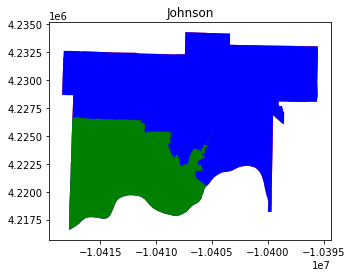

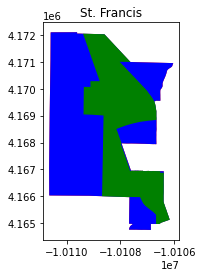

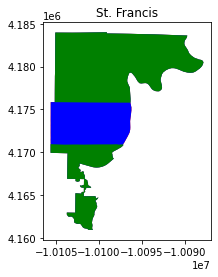

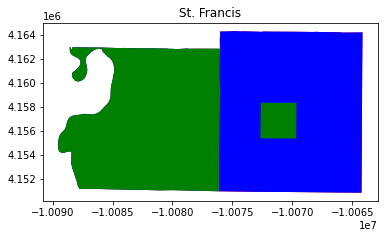

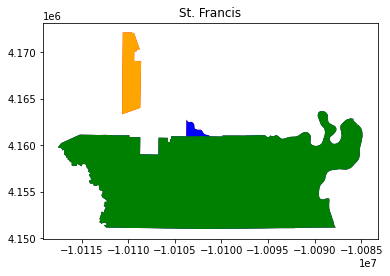

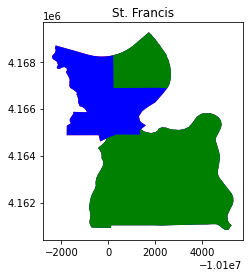

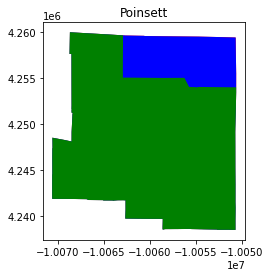

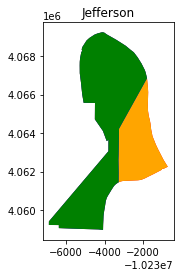

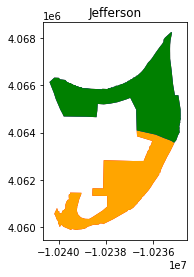

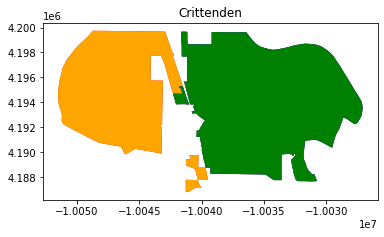

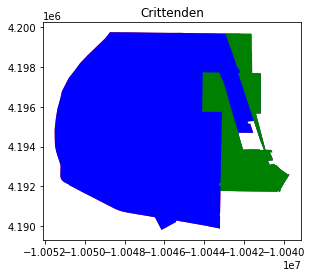

In [223]:
count = 0
area_list = []
for i in range(0,len(source_geoms)):
    try:
        diff = source_geoms.iloc[[i]].symmetric_difference(vest_geoms.iloc[[i]])
        intersection = source_geoms.iloc[[i]].intersection(vest_geoms.iloc[[i]])
        area = float(diff.area/10e6)
        area_list.append(area)
            #print("Area is " + str(area))

        if (area > .5):
            count += 1
            name = source_geoms.iat[i,0]
            print(str(count)+") For " + name + " difference in area is " + str(area))
            if (intersection.iloc[0].is_empty):
                base = diff.plot(color="red")
                source_geoms.iloc[[i]].plot(color="orange",ax=base)
                vest_geoms.iloc[[i]].plot(color="blue",ax=base)
                base.set_title(name)
            else:
                base = diff.plot(color="red")
                source_geoms.iloc[[i]].plot(color="orange",ax=base)
                vest_geoms.iloc[[i]].plot(color="blue",ax=base)
                intersection.plot(color="green",ax=base)
                base.set_title(name)
    except:
        print("Not able to run code for: ", source_geoms.iat[i,0])
        #diff = source_geoms.iloc[[i]].symmetric_difference(vest_geoms.iloc[[i]])


In [224]:
df = pd.DataFrame(area_list)
print(df.shape)

print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")

(2523, 1)
2353 precincts w/ a difference of 0 km^2
141 precincts w/ a difference between 0 and .1 km^2
18 precincts w/ a difference between .1 and .5 km^2
3 precincts w/ a difference between .5 and 1 km^2
2 precincts w/ a difference between 1 and 2 km^2
1 precincts w/ a difference between 2 and 5 km^2
5 precincts w/ a difference greater than 5 km^2
